In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('swami_vivekananda_letters_complete.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Index                 762 non-null    int64  
 1   volume                762 non-null    float64
 2   Name                  762 non-null    object 
 3   Category              760 non-null    object 
 4   Type                  761 non-null    object 
 5   Date                  759 non-null    object 
 6   Place                 755 non-null    object 
 7   Source                0 non-null      float64
 8   Audience              758 non-null    object 
 9   Language              759 non-null    object 
 10  section               762 non-null    object 
 11  genre                 762 non-null    object 
 12  href                  762 non-null    object 
 13  full_url              762 non-null    object 
 14  filename              762 non-null    object 
 15  has_html              7

In [2]:
# ============================================================================
# COMPREHENSIVE NETWORK ANALYSIS SETUP CELL
# This cell prepares all data structures needed for network analysis
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE NETWORK ANALYSIS SETUP")
print("="*80)

# ============================================================================
# STEP 1: LOAD AND CLEAN CSV DATA
# ============================================================================
print("\n[STEP 1/8] Loading CSV and removing duplicates...")

# Load the dataset
letters = pd.read_csv("swami_vivekananda_letters_complete.csv")
print(f"  Initial rows: {len(letters)}")

# Remove duplicates by full_url
letters = letters.drop_duplicates(subset=['full_url'], keep='first')
print(f"  After removing URL duplicates: {len(letters)}")

# Remove rows with no URL
letters = letters[letters['full_url'].notna() & (letters['full_url'] != '')]
print(f"  After removing rows with no URL: {len(letters)}")

# ============================================================================
# STEP 2: CLEAN AUDIENCE NAMES (FUZZY MATCHING)
# ============================================================================
print("\n[STEP 2/8] Cleaning audience names...")

# Strip whitespace from Audience column
letters['Audience'] = letters['Audience'].astype(str).str.strip()

# Define name corrections based on common issues
audience_mapping = {
    # Spelling variations
    'Chakravarti, Sharat Chandra': 'Chakravarty, Sharat Chandra',
    'Chakravarty, Sharat': 'Chakravarty, Sharat Chandra',

    # Trailing/leading whitespace issues
    'Perumal, Alasinga ': 'Perumal, Alasinga',
    ' Perumal, Alasinga': 'Perumal, Alasinga',

    # Common misspellings
    'Legget, Francis H': 'Leggett, Francis H',
    'Leggett, Francis H.': 'Leggett, Francis H',

    'Ghosal, Sarala': 'Ghoshal, Sarala',
    'Ghoshal, Sarla': 'Ghoshal, Sarala',

    'Sha, Lala Badri': 'Sah, Lala Badri',
    'Shah, Lala Badri': 'Sah, Lala Badri',

    # Other variations
    'Hale, Mrs. G. W.': 'Hale, G. W. Mrs.',
    'Hale, Mrs G. W.': 'Hale, G. W. Mrs.',

    'MacLeod, Miss Josephine': 'MacLeod, Josephine',

    'Bull, Miss Sarah': 'Bull, Sarah',

    'Sturdy, E. T.': 'Sturdy, E.T.',
    'Sturdy, E.T': 'Sturdy, E.T.',
}

# Apply corrections
letters['Audience_clean'] = letters['Audience'].replace(audience_mapping)

print(f"  Applied {len(audience_mapping)} name corrections")
print(f"  Unique recipients after cleaning: {letters['Audience_clean'].nunique()}")

# ============================================================================
# STEP 3: PARSE AND VALIDATE DATES
# ============================================================================
print("\n[STEP 3/8] Parsing and validating dates...")

# Parse dates - extract year as primary component
def parse_date_year(date_str):
    """Extract year from date string, handling various formats"""
    if pd.isna(date_str) or date_str == '':
        return None

    date_str = str(date_str).strip()

    # Try to parse yyyy/mm/dd or yyyy-mm-dd
    for sep in ['/', '-']:
        if sep in date_str:
            parts = date_str.split(sep)
            if len(parts) >= 1:
                try:
                    year = int(parts[0])
                    return year
                except:
                    pass

    # Try to extract 4-digit year from anywhere in string
    year_match = re.search(r'(18|19|20)\d{2}', date_str)
    if year_match:
        return int(year_match.group())

    return None

letters['year'] = letters['Date'].apply(parse_date_year)

# Validate years are in expected range (1888-1902)
valid_years = letters['year'].notna() & (letters['year'] >= 1888) & (letters['year'] <= 1902)
print(f"  Dates with valid years (1888-1902): {valid_years.sum()}/{len(letters)}")

# Show year distribution
if letters['year'].notna().sum() > 0:
    year_counts = letters['year'].value_counts().sort_index()
    print(f"  Year range: {letters['year'].min():.0f} to {letters['year'].max():.0f}")

# ============================================================================
# STEP 4: ASSIGN TEMPORAL PERIODS
# ============================================================================
print("\n[STEP 4/8] Assigning temporal periods...")

def assign_period(year):
    """Assign period based on Swamiji's life phases"""
    if pd.isna(year):
        return 'Unknown'

    if 1888 <= year < 1893:
        return 'Period1_India_1888-1893'
    elif 1893 <= year < 1897:
        return 'Period2_West_1893-1897'
    elif 1897 <= year < 1899:
        return 'Period3_India_1897-1899'
    elif 1899 <= year <= 1902:
        return 'Period4_West_Final_1899-1902'
    else:
        return 'Unknown'

letters['period'] = letters['year'].apply(assign_period)

period_counts = letters['period'].value_counts()
print("  Period distribution:")
for period in ['Period1_India_1888-1893', 'Period2_West_1893-1897',
               'Period3_India_1897-1899', 'Period4_West_Final_1899-1902', 'Unknown']:
    if period in period_counts:
        print(f"    {period}: {period_counts[period]}")

# Create all_letters dataframe
all_letters = letters.copy()
print(f"\n  ✓ Created all_letters dataframe with {len(all_letters)} rows")

# ============================================================================
# STEP 5: DEFINE FOCUS CORRESPONDENTS
# ============================================================================
print("\n[STEP 5/8] Defining focus correspondents...")

# Core focus correspondents (top recipients based on letter counts)
focus_correspondents = [
    'Bull, Sarah',
    'MacLeod, Josephine',
    'Hale, G. W. Mrs.',
    'Hale, Mary',
    'Hale, Sisters',
    'Christine, Sister',
    'Nivedita, Sister',
    'Sturdy, E.T.',
    'Perumal, Alasinga',
    'Brahmananda, Swami',
    'Desai, Viaharidas Haridas',
    'Halboister, Marie',
    'Leggett, Francis Mrs.',
    'McKindley, Isabelle',
    'Maharaja of Khetri (Singh, Ajit)',
]

# Extended focus correspondents (adds a few more key people)
extended_focus_correspondents = focus_correspondents + [
    'Goodwin, J.J.',
    'Leggett, Francis H',
]

print(f"  Core focus correspondents: {len(focus_correspondents)}")
print(f"  Extended focus correspondents: {len(extended_focus_correspondents)}")

# Filter letters to focus correspondents
focus_letters = all_letters[all_letters['Audience_clean'].isin(extended_focus_correspondents)].copy()
print(f"  Letters to focus correspondents: {len(focus_letters)}")

# ============================================================================
# STEP 6: LOAD SPACY NER MODEL
# ============================================================================
print("\n[STEP 6/8] Loading spaCy NER model...")

try:
    import spacy
    try:
        nlp = spacy.load('en_core_web_sm')
        print("  ✓ Loaded en_core_web_sm")
    except:
        print("  Downloading en_core_web_sm...")
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'],
                      capture_output=True)
        nlp = spacy.load('en_core_web_sm')
        print("  ✓ Downloaded and loaded en_core_web_sm")
except Exception as e:
    print(f"  ⚠ Warning: Could not load spaCy: {e}")
    print("  You may need to install spaCy: !pip install spacy")
    nlp = None

# ============================================================================
# STEP 7: EXTRACT PERSON MENTIONS WITH NER
# ============================================================================
print("\n[STEP 7/8] Extracting person mentions from ALL letters...")

if nlp is not None and len(all_letters) > 0:
    all_mentions = []
    processed = 0

    # Process ALL letters, not just focus correspondents
    for idx, row in all_letters.iterrows():
        processed += 1
        if processed % 50 == 0:
            print(f"  Processing {processed}/{len(all_letters)} letters...")

        if pd.notna(row['body_text']) and len(str(row['body_text'])) > 10:
            try:
                # Limit text length to avoid memory issues
                text = str(row['body_text'])[:50000]
                doc = nlp(text)

                for ent in doc.ents:
                    if ent.label_ == 'PERSON':
                        name = ent.text.strip()
                        # Filter out very short names or common titles
                        if len(name) > 2 and name.lower() not in ['sir', 'mr', 'mrs', 'miss', 'dr', 'swami', 'sister', 'the']:
                            all_mentions.append({
                                'name': name,
                                'letter_id': idx,
                                'letter_date': row['Date'],
                                'recipient': row['Audience_clean'],
                                'language': row.get('Language', 'Unknown'),
                                'period': row['period']
                            })
            except Exception as e:
                # Skip problematic letters
                continue

    mentions_df = pd.DataFrame(all_mentions)
    print(f"\n  ✓ Extracted {len(mentions_df)} person mentions")
    print(f"  ✓ Unique names found: {mentions_df['name'].nunique()}")
else:
    mentions_df = pd.DataFrame()
    print("  ⚠ Skipped NER extraction (spaCy not available or no letters)")

# ============================================================================
# STEP 8: CREATE NICKNAME MAPPING AND RESOLVE NAMES
# ============================================================================
print("\n[STEP 8/8] Creating nickname mapping and resolving names...")

# Comprehensive nickname mapping
nickname_mapping = {
    # Western correspondents - formal names
    'Bull': 'Bull, Sarah',
    'Ole Bull': 'Bull, Sarah',
    'Sarah Bull': 'Bull, Sarah',

    'Joe': 'MacLeod, Josephine',
    'JOE': 'MacLeod, Josephine',
    'Josephine': 'MacLeod, Josephine',
    'Jo': 'MacLeod, Josephine',

    'G. W. Hale': 'Hale, G. W. Mrs.',
    'Mrs. Hale': 'Hale, G. W. Mrs.',
    'Mrs Hale': 'Hale, G. W. Mrs.',

    'Mary': 'Hale, Mary',
    'Mary Hale': 'Hale, Mary',

    'Christine': 'Christine, Sister',
    'Sister Christine': 'Christine, Sister',

    # Sister Nivedita - IMPORTANT: Multiple mappings
    'Nivedita': 'Nivedita, Sister',
    'Sister Nivedita': 'Nivedita, Sister',
    'Margaret Noble': 'Nivedita, Sister',
    'Margaret E. Noble': 'Nivedita, Sister',
    'Noble': 'Nivedita, Sister',
    'MARGOT': 'Nivedita, Sister',
    'Miss Noble': 'Nivedita, Sister',

    'ALASINGA': 'Perumal, Alasinga',
    'Alasinga': 'Perumal, Alasinga',
    'Alasinga Perumal': 'Perumal, Alasinga',

    'E. T. Sturdy': 'Sturdy, E.T.',
    'Sturdy': 'Sturdy, E.T.',
    'E.T. Sturdy': 'Sturdy, E.T.',

    'Dewanji': 'Desai, Viaharidas Haridas',
    'Diwanji': 'Desai, Viaharidas Haridas',
    'Dewan': 'Desai, Viaharidas Haridas',
    'Diwan': 'Desai, Viaharidas Haridas',
    'Haridas Desai': 'Desai, Viaharidas Haridas',
    'Haridas': 'Desai, Viaharidas Haridas',
    'Biharidas': 'Desai, Viaharidas Haridas',

    'Khetri': 'Maharaja of Khetri (Singh, Ajit)',
    'Ajit Singh': 'Maharaja of Khetri (Singh, Ajit)',
    'Maharaja': 'Maharaja of Khetri (Singh, Ajit)',

    'Goodwin': 'Goodwin, J.J.',
    'J.J. Goodwin': 'Goodwin, J.J.',

    'Leggett': 'Leggett, Francis H',
    'Francis Leggett': 'Leggett, Francis H',

    # Swamis and disciples - pre-monastic names
    'Swami Brahmananda': 'Brahmananda, Swami',
    'Brahmananda': 'Brahmananda, Swami',
    'Rakhal': 'Brahmananda, Swami',
    'Rakhal Maharaj': 'Brahmananda, Swami',

    'Swami Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Shashi': 'Ramakrishnananda, Swami',

    'Swami Akhandananda': 'Akhandananda, Swami',
    'Akhandananda': 'Akhandananda, Swami',
    'Gangadhar': 'Akhandananda, Swami',

    'Swami Turiyananda': 'Turiyananda, Swami',
    'Turiyananda': 'Turiyananda, Swami',
    'Hari': 'Turiyananda, Swami',
    'Hari Maharaj': 'Turiyananda, Swami',

    'Swami Shivananda': 'Shivananda, Swami',
    'Shivananda': 'Shivananda, Swami',
    'Tarak': 'Shivananda, Swami',

    'Swami Premananda': 'Premananda, Swami',
    'Premananda': 'Premananda, Swami',
    'Baburam': 'Premananda, Swami',

    'Swami Saradananda': 'Saradananda, Swami',
    'Saradananda': 'Saradananda, Swami',
    'Sharat': 'Saradananda, Swami',

    'Swami Abhedananda': 'Abhedananda, Swami',
    'Abhedananda': 'Abhedananda, Swami',
    'Kali': 'Abhedananda, Swami',
    'Kali Maharaj': 'Abhedananda, Swami',

    'Swami Advaitananda': 'Advaitananda, Swami',
    'Advaitananda': 'Advaitananda, Swami',
    'Gopal': 'Advaitananda, Swami',

    'Swami Niranjanananda': 'Niranjanananda, Swami',
    'Niranjanananda': 'Niranjanananda, Swami',
    'Niranjan': 'Niranjanananda, Swami',

    'Swami Trigunatitananda': 'Trigunatitananda, Swami',
    'Trigunatitananda': 'Trigunatitananda, Swami',
    'Sarada': 'Trigunatitananda, Swami',

    'Swami Yogananda': 'Yogananda, Swami',
    'Yogananda': 'Yogananda, Swami',
    'Yogen': 'Yogananda, Swami',

    # Holy Mother and Master
    'Sri Ramakrishna': 'Ramakrishna, Sri',
    'Ramakrishna': 'Ramakrishna, Sri',
    'Master': 'Ramakrishna, Sri',
    'The Master': 'Ramakrishna, Sri',

    'Holy Mother': 'Sarada Devi, Sri',
    'Sri Sarada Devi': 'Sarada Devi, Sri',

    # Other notable mentions
    'Müller': 'Müller, Max',
    'Max Müller': 'Müller, Max',
    'Professor Müller': 'Müller, Max',

    'Harriet': 'Hale, G. W. Mrs.',

    'Balaram Babu': 'Bose, Balaram',
    'Babu Balaram Bose': 'Bose, Balaram',
    'Balaram Bose': 'Bose, Balaram',

    'Pavhari Baba': 'Pavhari Baba',
    'Pavhâri Bâbâ': 'Pavhari Baba',
    'Babaji': 'Pavhari Baba',

    'Sevier': 'Sevier, Capt. and Mrs.',
    'Seviers': 'Sevier, Capt. and Mrs.',

    'Funkey': 'Funke, Mary Mrs.',
    'Funke': 'Funke, Mary Mrs.',

    'Adams': 'Adams, Milward Mr. and Mrs.',
    'Milward Adams': 'Adams, Milward Mr. and Mrs.',
}

# Apply nickname mapping to mentions
if len(mentions_df) > 0:
    mentions_df['resolved_name'] = mentions_df['name'].replace(nickname_mapping)

    # Keep only mentions that resolved to someone meaningful
    # (Either in extended_focus_correspondents or well-known figures)
    resolved_mentions_df = mentions_df.copy()

    print(f"  ✓ Applied nickname mapping to {len(mentions_df)} mentions")
    print(f"  ✓ Unique resolved names: {resolved_mentions_df['resolved_name'].nunique()}")

    # Show top mentioned people
    top_mentioned = resolved_mentions_df['resolved_name'].value_counts().head(15)
    print("\n  Top 15 mentioned people:")
    for name, count in top_mentioned.items():
        print(f"    {name}: {count}")
else:
    resolved_mentions_df = pd.DataFrame()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SETUP COMPLETE - SUMMARY")
print("="*80)
print(f"✓ all_letters: {len(all_letters)} letters")
print(f"✓ focus_correspondents: {len(focus_correspondents)} people")
print(f"✓ extended_focus_correspondents: {len(extended_focus_correspondents)} people")
print(f"✓ mentions_df: {len(mentions_df)} extracted mentions")
print(f"✓ resolved_mentions_df: {len(resolved_mentions_df)} resolved mentions")
print(f"✓ nlp: spaCy NER model {'loaded' if nlp else 'NOT loaded'}")
print(f"✓ nickname_mapping: {len(nickname_mapping)} mappings")
print("="*80)

# Create period labels for visualization
period_labels = {
    'Period1_India_1888-1893': 'India 1888-1893',
    'Period2_West_1893-1897': 'West 1893-1897',
    'Period3_India_1897-1899': 'India 1897-1899',
    'Period4_West_Final_1899-1902': 'West & Final Years 1899-1902'
}

print("\nAll variables ready for Recipient-Mention analysis!")

COMPREHENSIVE NETWORK ANALYSIS SETUP

[STEP 1/8] Loading CSV and removing duplicates...
  Initial rows: 762
  After removing URL duplicates: 762
  After removing rows with no URL: 762

[STEP 2/8] Cleaning audience names...
  Applied 16 name corrections
  Unique recipients after cleaning: 110

[STEP 3/8] Parsing and validating dates...
  Dates with valid years (1888-1902): 759/762
  Year range: 1888 to 1902

[STEP 4/8] Assigning temporal periods...
  Period distribution:
    Period1_India_1888-1893: 60
    Period2_West_1893-1897: 351
    Period3_India_1897-1899: 121
    Period4_West_Final_1899-1902: 227
    Unknown: 3

  ✓ Created all_letters dataframe with 762 rows

[STEP 5/8] Defining focus correspondents...
  Core focus correspondents: 15
  Extended focus correspondents: 17
  Letters to focus correspondents: 516

[STEP 6/8] Loading spaCy NER model...
  ✓ Loaded en_core_web_sm

[STEP 7/8] Extracting person mentions from ALL letters...
  Processing 50/762 letters...
  Processing 100/76

In [3]:
# ============================================================================
# RECIPIENT-MENTION ANALYSIS WITH SENTIMENT
# Complete analysis: extraction → sentiment → theme → statistics
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("RECIPIENT-MENTION ANALYSIS WITH SENTIMENT")
print("="*80)

# ============================================================================
# STEP 1: EXTRACT SENTENCE CONTEXTS FOR MENTIONS
# ============================================================================
print("\n[STEP 1/6] Extracting sentence contexts for each mention...")

def extract_sentence_context(text, entity_text, entity_start):
    """
    Extract the sentence containing the entity mention.
    Returns the full sentence for sentiment analysis.
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # Use spaCy for sentence tokenization
    try:
        doc = nlp(text[:50000])  # Limit text length

        # Find which sentence contains this entity
        for sent in doc.sents:
            if entity_start >= sent.start_char and entity_start < sent.end_char:
                return sent.text.strip()

        # Fallback: return empty if not found
        return ""
    except:
        # Fallback: simple sentence extraction
        # Find sentence boundaries around the mention
        start = max(0, entity_start - 200)
        end = min(len(text), entity_start + 200)
        snippet = text[start:end]

        # Find sentence boundaries
        sentences = re.split(r'[.!?]+', snippet)
        for sent in sentences:
            if entity_text in sent:
                return sent.strip()

        return snippet.strip()

print("  Extracting sentence contexts from letter bodies...")

# Create enhanced mentions dataframe with sentence context
recipient_mentions = []
processed = 0

for idx, row in all_letters.iterrows():
    processed += 1
    if processed % 50 == 0:
        print(f"  Processing {processed}/{len(all_letters)} letters...")

    if pd.notna(row['body_text']) and len(str(row['body_text'])) > 10:
        try:
            text = str(row['body_text'])[:50000]
            doc = nlp(text)

            for ent in doc.ents:
                if ent.label_ == 'PERSON':
                    name = ent.text.strip()

                    # Filter out very short names or common titles
                    if len(name) > 2 and name.lower() not in ['sir', 'mr', 'mrs', 'miss', 'dr', 'swami', 'sister', 'the']:
                        # Resolve nickname
                        resolved = nickname_mapping.get(name, name)

                        # Extract sentence context
                        sentence = extract_sentence_context(text, ent.text, ent.start_char)

                        recipient_mentions.append({
                            'letter_id': idx,
                            'recipient': row['Audience_clean'],
                            'mentioned_person': resolved,
                            'original_name': name,
                            'sentence_context': sentence,
                            'letter_date': row['Date'],
                            'year': row['year'],
                            'period': row['period'],
                            'language': row.get('Language', 'Unknown')
                        })
        except Exception as e:
            continue

recipient_mention_df = pd.DataFrame(recipient_mentions)

print(f"\n  ✓ Extracted {len(recipient_mention_df)} mention-recipient pairs")
print(f"  ✓ Unique recipients: {recipient_mention_df['recipient'].nunique()}")
print(f"  ✓ Unique mentioned persons: {recipient_mention_df['mentioned_person'].nunique()}")

# ============================================================================
# STEP 2: BASIC STATISTICS - FREQUENCY COUNTS
# ============================================================================
print("\n[STEP 2/6] Computing frequency statistics...")

# Create frequency matrix: recipient × mentioned_person
frequency_matrix = recipient_mention_df.groupby(['recipient', 'mentioned_person']).size().reset_index(name='frequency')

print(f"  ✓ Created frequency matrix: {len(frequency_matrix)} unique pairs")

# Top mentioned people overall
top_mentioned_overall = recipient_mention_df['mentioned_person'].value_counts().head(20)
print("\n  Top 20 most mentioned people overall:")
for i, (person, count) in enumerate(top_mentioned_overall.items(), 1):
    print(f"    {i:2d}. {person}: {count}")

# Top recipients (who received most letters with mentions)
top_recipients = recipient_mention_df['recipient'].value_counts().head(20)
print("\n  Top 20 recipients (by number of mentions in their letters):")
for i, (person, count) in enumerate(top_recipients.items(), 1):
    print(f"    {i:2d}. {person}: {count}")

# ============================================================================
# STEP 3: INSTALL AND LOAD TRANSFORMERS FOR SENTIMENT ANALYSIS
# ============================================================================
print("\n[STEP 3/6] Setting up transformer models for sentiment analysis...")

try:
    from transformers import pipeline
    print("  ✓ Transformers library already installed")
except ImportError:
    print("  Installing transformers library...")
    import subprocess
    subprocess.run(['pip', 'install', 'transformers', 'torch', '--quiet'], check=False)
    from transformers import pipeline
    print("  ✓ Installed transformers library")

# Load sentiment analysis model
print("  Loading sentiment analysis model (this may take a moment)...")
try:
    # Using cardiffnlp's Twitter RoBERTa model - good at nuanced sentiment
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        top_k=None  # Return all scores
    )
    print("  ✓ Loaded cardiffnlp/twitter-roberta-base-sentiment-latest")
except Exception as e:
    print(f"  ⚠ Could not load specific model, using default: {e}")
    sentiment_analyzer = pipeline("sentiment-analysis", top_k=None)
    print("  ✓ Loaded default sentiment model")

# ============================================================================
# STEP 4: APPLY SENTIMENT ANALYSIS
# ============================================================================
print("\n[STEP 4/6] Applying sentiment analysis to sentence contexts...")
print("  This will take several minutes for all mentions...")

def analyze_sentiment_batch(texts, batch_size=32):
    """Analyze sentiment in batches for efficiency"""
    results = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Filter out empty texts
        valid_batch = [(idx, text) for idx, text in enumerate(batch) if text and len(text.strip()) > 5]

        if valid_batch:
            valid_indices, valid_texts = zip(*valid_batch)

            try:
                batch_results = sentiment_analyzer(list(valid_texts), truncation=True, max_length=512)

                # Process results
                for local_idx, result in enumerate(batch_results):
                    global_idx = i + valid_indices[local_idx]

                    # Extract scores
                    if isinstance(result, list):
                        # Multiple scores returned
                        scores = {item['label']: item['score'] for item in result}

                        # Map labels to our categories
                        positive_score = scores.get('positive', scores.get('POSITIVE', scores.get('LABEL_2', 0)))
                        negative_score = scores.get('negative', scores.get('NEGATIVE', scores.get('LABEL_0', 0)))
                        neutral_score = scores.get('neutral', scores.get('NEUTRAL', scores.get('LABEL_1', 0)))

                        # Determine dominant sentiment
                        max_label = max(scores.items(), key=lambda x: x[1])[0]

                        # Normalize label names
                        if max_label in ['positive', 'POSITIVE', 'LABEL_2']:
                            sentiment_label = 'positive'
                        elif max_label in ['negative', 'NEGATIVE', 'LABEL_0']:
                            sentiment_label = 'negative'
                        else:
                            sentiment_label = 'neutral'

                        # Compute compound score (-1 to 1)
                        compound = positive_score - negative_score

                    else:
                        # Single result returned
                        sentiment_label = result['label'].lower()
                        compound = result['score'] if sentiment_label == 'positive' else -result['score']
                        positive_score = result['score'] if sentiment_label == 'positive' else 0
                        negative_score = result['score'] if sentiment_label == 'negative' else 0
                        neutral_score = result['score'] if sentiment_label == 'neutral' else 0

                    results.append({
                        'sentiment_label': sentiment_label,
                        'sentiment_score': compound,
                        'positive_score': positive_score,
                        'negative_score': negative_score,
                        'neutral_score': neutral_score
                    })
            except Exception as e:
                # If batch fails, add neutral sentiment for all
                for _ in range(len(valid_indices)):
                    results.append({
                        'sentiment_label': 'neutral',
                        'sentiment_score': 0.0,
                        'positive_score': 0.0,
                        'negative_score': 0.0,
                        'neutral_score': 1.0
                    })

        if (i + batch_size) % 320 == 0:
            print(f"    Processed {min(i + batch_size, len(texts))}/{len(texts)} sentences...")

    return results

# Apply sentiment analysis
sentiment_results = analyze_sentiment_batch(recipient_mention_df['sentence_context'].tolist())

# Add sentiment columns to dataframe
sentiment_df = pd.DataFrame(sentiment_results)
recipient_mention_df = pd.concat([recipient_mention_df.reset_index(drop=True), sentiment_df], axis=1)

print(f"\n  ✓ Sentiment analysis complete!")
print(f"  ✓ Sentiment distribution:")
print(recipient_mention_df['sentiment_label'].value_counts())

# # ============================================================================
# # STEP 5: ZERO-SHOT THEME CLASSIFICATION
# # ============================================================================
# print("\n[STEP 5/6] Applying theme classification...")

# # Load zero-shot classification model
# print("  Loading zero-shot classifier...")
# try:
#     theme_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
#     print("  ✓ Loaded facebook/bart-large-mnli")
# except Exception as e:
#     print(f"  ⚠ Could not load theme classifier: {e}")
#     theme_classifier = None

# # Define themes
# candidate_themes = [
#     "spiritual matters and religious teachings",
#     "health concerns and medical issues",
#     "organizational work and mission activities",
#     "travel updates and journey plans",
#     "personal affection and friendship",
#     "financial matters and fundraising"
# ]

# theme_labels = [
#     "spiritual",
#     "health",
#     "organizational",
#     "travel",
#     "personal",
#     "financial"
# ]

# def classify_theme_batch(texts, batch_size=16):
#     """Classify themes in batches"""
#     if theme_classifier is None:
#         return ['unknown'] * len(texts)

#     results = []

#     for i in range(0, len(texts), batch_size):
#         batch = texts[i:i+batch_size]

#         # Filter out empty texts
#         valid_batch = [(idx, text) for idx, text in enumerate(batch) if text and len(text.strip()) > 5]

#         if valid_batch:
#             valid_indices, valid_texts = zip(*valid_batch)

#             try:
#                 batch_results = theme_classifier(
#                     list(valid_texts),
#                     candidate_themes,
#                     truncation=True,
#                     max_length=512
#                 )

#                 for result in batch_results:
#                     # Get the top theme
#                     top_theme_idx = candidate_themes.index(result['labels'][0])
#                     results.append(theme_labels[top_theme_idx])

#             except Exception as e:
#                 # If batch fails, add unknown theme
#                 for _ in range(len(valid_indices)):
#                     results.append('unknown')

#         if (i + batch_size) % 160 == 0:
#             print(f"    Classified {min(i + batch_size, len(texts))}/{len(texts)} sentences...")

#     return results

# print("  Classifying themes (this will take several minutes)...")
# themes = classify_theme_batch(recipient_mention_df['sentence_context'].tolist())
# recipient_mention_df['theme'] = themes

# print(f"\n  ✓ Theme classification complete!")
# print(f"  ✓ Theme distribution:")
# print(recipient_mention_df['theme'].value_counts())

# # ============================================================================
# # STEP 6: AGGREGATE STATISTICS WITH SENTIMENT AND THEME
# # ============================================================================
# print("\n[STEP 6/6] Computing aggregate statistics...")

# # Create enhanced frequency matrix with sentiment
# sentiment_summary = recipient_mention_df.groupby(['recipient', 'mentioned_person']).agg({
#     'letter_id': 'count',  # frequency
#     'sentiment_score': ['mean', 'std'],
#     'sentiment_label': lambda x: x.value_counts().to_dict(),
#     'theme': lambda x: x.value_counts().to_dict(),
#     'sentence_context': lambda x: list(x)[:3]  # Keep first 3 examples
# }).reset_index()

# # Flatten column names
# sentiment_summary.columns = ['recipient', 'mentioned_person', 'frequency',
#                              'avg_sentiment', 'std_sentiment',
#                              'sentiment_distribution', 'theme_distribution',
#                              'example_sentences']

# print(f"  ✓ Created sentiment summary: {len(sentiment_summary)} unique pairs")

# # Add sentiment category based on average score
# def categorize_sentiment(score):
#     if pd.isna(score):
#         return 'neutral'
#     if score > 0.2:
#         return 'positive'
#     elif score < -0.2:
#         return 'negative'
#     else:
#         return 'neutral'

# sentiment_summary['sentiment_category'] = sentiment_summary['avg_sentiment'].apply(categorize_sentiment)

# print("\n  ✓ Sentiment category distribution:")
# print(sentiment_summary['sentiment_category'].value_counts())

# # Show some interesting examples
# print("\n  Example: Most positive mentions")
# most_positive = sentiment_summary.nlargest(10, 'avg_sentiment')[
#     ['recipient', 'mentioned_person', 'frequency', 'avg_sentiment']
# ]
# print(most_positive.to_string(index=False))

# print("\n  Example: Most negative mentions")
# most_negative = sentiment_summary.nsmallest(10, 'avg_sentiment')[
#     ['recipient', 'mentioned_person', 'frequency', 'avg_sentiment']
# ]
# print(most_negative.to_string(index=False))

# # ============================================================================
# # SAVE RESULTS
# # ============================================================================
# print("\n" + "="*80)
# print("SAVING RESULTS")
# print("="*80)

# # Save detailed mention data
# recipient_mention_df.to_csv('recipient_mention_detailed.csv', index=False)
# print("  ✓ Saved: recipient_mention_detailed.csv")

# # Save sentiment summary
# sentiment_summary.to_csv('recipient_mention_sentiment_summary.csv', index=False)
# print("  ✓ Saved: recipient_mention_sentiment_summary.csv")

# # ============================================================================
# # FINAL SUMMARY
# # ============================================================================
# print("\n" + "="*80)
# print("ANALYSIS COMPLETE - SUMMARY")
# print("="*80)
# print(f"✓ Total mention instances: {len(recipient_mention_df)}")
# print(f"✓ Unique recipient-mention pairs: {len(sentiment_summary)}")
# print(f"✓ Unique recipients: {recipient_mention_df['recipient'].nunique()}")
# print(f"✓ Unique mentioned persons: {recipient_mention_df['mentioned_person'].nunique()}")
# print(f"✓ Sentiment analyzed: {(~recipient_mention_df['sentiment_score'].isna()).sum()} sentences")
# print(f"✓ Themes classified: {(recipient_mention_df['theme'] != 'unknown').sum()} sentences")
# print("="*80)

# print("\nDataframes available:")
# print("  - recipient_mention_df: Detailed mention data with sentiment and theme")
# print("  - sentiment_summary: Aggregated statistics per recipient-mention pair")
# print("  - frequency_matrix: Simple frequency counts")

RECIPIENT-MENTION ANALYSIS WITH SENTIMENT

[STEP 1/6] Extracting sentence contexts for each mention...
  Extracting sentence contexts from letter bodies...
  Processing 50/762 letters...
  Processing 100/762 letters...
  Processing 150/762 letters...
  Processing 200/762 letters...
  Processing 250/762 letters...
  Processing 300/762 letters...
  Processing 350/762 letters...
  Processing 400/762 letters...
  Processing 450/762 letters...
  Processing 500/762 letters...
  Processing 550/762 letters...
  Processing 600/762 letters...
  Processing 650/762 letters...
  Processing 700/762 letters...
  Processing 750/762 letters...

  ✓ Extracted 3619 mention-recipient pairs
  ✓ Unique recipients: 100
  ✓ Unique mentioned persons: 1217

[STEP 2/6] Computing frequency statistics...
  ✓ Created frequency matrix: 1984 unique pairs

  Top 20 most mentioned people overall:
     1. Bull, Sarah: 153
     2. MacLeod, Josephine: 89
     3. Hale, Mary: 88
     4. Leggett, Francis H: 79
     5. Hale, 

  ✓ Transformers library already installed
  Loading sentiment analysis model (this may take a moment)...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


  ✓ Loaded cardiffnlp/twitter-roberta-base-sentiment-latest

[STEP 4/6] Applying sentiment analysis to sentence contexts...
  This will take several minutes for all mentions...
    Processed 320/3619 sentences...
    Processed 640/3619 sentences...
    Processed 960/3619 sentences...
    Processed 1280/3619 sentences...
    Processed 1600/3619 sentences...
    Processed 1920/3619 sentences...
    Processed 2240/3619 sentences...
    Processed 2560/3619 sentences...
    Processed 2880/3619 sentences...
    Processed 3200/3619 sentences...
    Processed 3520/3619 sentences...

  ✓ Sentiment analysis complete!
  ✓ Sentiment distribution:
sentiment_label
neutral     2206
positive    1004
negative     399
Name: count, dtype: int64

[STEP 5/6] Applying theme classification...
  Loading zero-shot classifier...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


  ✓ Loaded facebook/bart-large-mnli
  Classifying themes (this will take several minutes)...
    Classified 160/3619 sentences...


KeyboardInterrupt: 

In [5]:
# ============================================================================
# STEP 6: AGGREGATE STATISTICS WITH SENTIMENT (NO THEME)
# ============================================================================
print("\n[STEP 6/6] Computing aggregate statistics...")

# Create enhanced frequency matrix with sentiment
sentiment_summary = recipient_mention_df.groupby(['recipient', 'mentioned_person']).agg({
    'letter_id': 'count',  # frequency
    'sentiment_score': ['mean', 'std'],
    'sentiment_label': lambda x: x.value_counts().to_dict(),
    'sentence_context': lambda x: list(x)[:3]  # Keep first 3 examples
}).reset_index()

# Flatten column names
sentiment_summary.columns = ['recipient', 'mentioned_person', 'frequency',
                             'avg_sentiment', 'std_sentiment',
                             'sentiment_distribution',
                             'example_sentences']

print(f"  ✓ Created sentiment summary: {len(sentiment_summary)} unique pairs")

# Add sentiment category based on average score
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    if score > 0.2:
        return 'positive'
    elif score < -0.2:
        return 'negative'
    else:
        return 'neutral'

sentiment_summary['sentiment_category'] = sentiment_summary['avg_sentiment'].apply(categorize_sentiment)

print("\n  ✓ Sentiment category distribution:")
print(sentiment_summary['sentiment_category'].value_counts())

# Show some interesting examples
print("\n  Example: Most positive mentions")
most_positive = sentiment_summary.nlargest(10, 'avg_sentiment')[
    ['recipient', 'mentioned_person', 'frequency', 'avg_sentiment']
]
print(most_positive.to_string(index=False))

print("\n  Example: Most negative mentions")
most_negative = sentiment_summary.nsmallest(10, 'avg_sentiment')[
    ['recipient', 'mentioned_person', 'frequency', 'avg_sentiment']
]
print(most_negative.to_string(index=False))

# ============================================================================
# SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save detailed mention data
recipient_mention_df.to_csv('recipient_mention_detailed.csv', index=False)
print("  ✓ Saved: recipient_mention_detailed.csv")

# Save sentiment summary
sentiment_summary.to_csv('recipient_mention_sentiment_summary.csv', index=False)
print("  ✓ Saved: recipient_mention_sentiment_summary.csv")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*80)
print(f"✓ Total mention instances: {len(recipient_mention_df)}")
print(f"✓ Unique recipient-mention pairs: {len(sentiment_summary)}")
print(f"✓ Unique recipients: {recipient_mention_df['recipient'].nunique()}")
print(f"✓ Unique mentioned persons: {recipient_mention_df['mentioned_person'].nunique()}")
print(f"✓ Sentiment analyzed: {(~recipient_mention_df['sentiment_score'].isna()).sum()} sentences")
print("="*80)

print("\nDataframes available:")
print("  - recipient_mention_df: Detailed mention data with sentiment")
print("  - sentiment_summary: Aggregated statistics per recipient-mention pair")
print("  - frequency_matrix: Simple frequency counts")


[STEP 6/6] Computing aggregate statistics...
  ✓ Created sentiment summary: 1984 unique pairs

  ✓ Sentiment category distribution:
sentiment_category
neutral     898
positive    774
negative    312
Name: count, dtype: int64

  Example: Most positive mentions
            recipient  mentioned_person  frequency  avg_sentiment
   Turiyananda, Swami               Dâl          1       0.985709
        Hale, Sisters               Sam          1       0.984829
     Hale, G. W. Mrs. Harriet McKindley          1       0.982731
     Hale, G. W. Mrs.  Francis W. Breed          1       0.981629
  McKindley, Isabelle     Lepel Griffin          1       0.981326
     Waldo, S.E. Miss  MISS S. E. WALDO          1       0.980419
Sturges, Mrs. William   William Sturges          1       0.980296
         Sturdy, E.T.            Gospel          1       0.979942
     Hale, G. W. Mrs.       Helen Gould          1       0.979694
          Bull, Sarah           Hammond          1       0.978932

  Example: M

In [9]:
nickname_mapping['Hariprasanna'] = 'Vijnanananda, Swami'

In [10]:
# ============================================================================
# RECIPIENT-MENTION VISUALIZATIONS - FREQUENCY ANALYSIS
# Static visualizations for document inclusion
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

print("="*80)
print("RECIPIENT-MENTION FREQUENCY VISUALIZATIONS")
print("="*80)

# ============================================================================
# STEP 1: CREATE VALID PERSON NAMES SET
# ============================================================================
print("\n[Step 1] Creating set of valid person names...")

# Get all valid person names from:
# 1. All recipients in audience_clean
# 2. All values in nickname_mapping (both keys and values)
# 3. Extended focus correspondents list

valid_persons = set()

# Add all recipients
valid_persons.update(all_letters['Audience_clean'].dropna().unique())

# Add all mapped names from nickname_mapping (values only - the canonical names)
valid_persons.update(nickname_mapping.values())

# Add focus correspondents
valid_persons.update(extended_focus_correspondents)

# Add some known religious figures that should be included
valid_persons.add('Ramakrishna, Sri')
valid_persons.add('Sarada Devi, Sri')

# Remove any None or empty strings
valid_persons = {name for name in valid_persons if name and pd.notna(name) and str(name).strip()}

print(f"  ✓ Total valid person names: {len(valid_persons)}")
print(f"  ✓ Sample valid names: {list(valid_persons)[:10]}")

# ============================================================================
# STEP 2: FILTER MENTIONS - ONLY VALID PERSONS, EXCLUDE SELF-REFERENCES
# ============================================================================
print("\n[Step 2] Filtering mentions - only valid persons, excluding self-references...")

# Filter to only include mentions that are in valid_persons set
filtered_mentions = recipient_mention_df[
    (recipient_mention_df['mentioned_person'].isin(valid_persons)) &
    (recipient_mention_df['mentioned_person'] != recipient_mention_df['recipient'])
].copy()

print(f"  ✓ Original mentions: {len(recipient_mention_df)}")
print(f"  ✓ After filtering to valid persons only: {len(filtered_mentions)}")
print(f"  ✓ Removed invalid mentions (places, concepts, etc.): {len(recipient_mention_df) - len(filtered_mentions)}")

# Show what was removed
removed_mentions = recipient_mention_df[~recipient_mention_df.index.isin(filtered_mentions.index)]
removed_names = removed_mentions['mentioned_person'].value_counts().head(20)
print("\n  Top 20 removed 'mentions' (not actual persons):")
for name, count in removed_names.items():
    print(f"    - {name}: {count}")

# ============================================================================
# STEP 3: RECREATE SENTIMENT SUMMARY WITH VALID MENTIONS ONLY
# ============================================================================
print("\n[Step 3] Recreating sentiment summary with valid mentions only...")

sentiment_summary_filtered = filtered_mentions.groupby(['recipient', 'mentioned_person']).agg({
    'letter_id': 'count',  # frequency
    'sentiment_score': ['mean', 'std'],
    'sentiment_label': lambda x: x.value_counts().to_dict(),
    'sentence_context': lambda x: list(x)[:3]  # Keep first 3 examples
}).reset_index()

sentiment_summary_filtered.columns = ['recipient', 'mentioned_person', 'frequency',
                             'avg_sentiment', 'std_sentiment',
                             'sentiment_distribution',
                             'example_sentences']

def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    if score > 0.2:
        return 'positive'
    elif score < -0.2:
        return 'negative'
    else:
        return 'neutral'

sentiment_summary_filtered['sentiment_category'] = sentiment_summary_filtered['avg_sentiment'].apply(categorize_sentiment)

print(f"  ✓ Filtered sentiment summary pairs: {len(sentiment_summary_filtered)}")

# ============================================================================
# STEP 4: GET TOP 10 FOR FOCUSED ANALYSIS
# ============================================================================
print("\n[Step 4] Selecting top 10 recipients and mentioned persons...")

# Get top recipients by total mentions (excluding self-references, valid persons only)
top_recipients_list = filtered_mentions['recipient'].value_counts().head(10).index.tolist()

# Get top mentioned people overall (excluding self-references, valid persons only)
top_mentioned_list = filtered_mentions['mentioned_person'].value_counts().head(10).index.tolist()

print(f"  ✓ Top 10 recipients:")
for i, name in enumerate(top_recipients_list, 1):
    count = filtered_mentions[filtered_mentions['recipient'] == name].shape[0]
    print(f"    {i:2d}. {name}: {count}")

print(f"\n  ✓ Top 10 mentioned persons:")
for i, name in enumerate(top_mentioned_list, 1):
    count = filtered_mentions[filtered_mentions['mentioned_person'] == name].shape[0]
    print(f"    {i:2d}. {name}: {count}")

# Filter sentiment_summary for these top people
viz_summary = sentiment_summary_filtered[
    (sentiment_summary_filtered['recipient'].isin(top_recipients_list)) &
    (sentiment_summary_filtered['mentioned_person'].isin(top_mentioned_list))
].copy()

print(f"\n  ✓ Filtered pairs for visualization: {len(viz_summary)}")

# ============================================================================
# VISUALIZATION 1: MAIN FREQUENCY HEATMAP (TOP 10 × TOP 10)
# ============================================================================
print("\n[Visualization 1] Creating main frequency heatmap (Top 10 × Top 10)...")

# Create pivot table for heatmap
heatmap_data = viz_summary.pivot_table(
    index='mentioned_person',
    columns='recipient',
    values='frequency',
    fill_value=0
)

# Sort by total frequency
heatmap_data = heatmap_data.loc[
    heatmap_data.sum(axis=1).sort_values(ascending=False).index,
    heatmap_data.sum(axis=0).sort_values(ascending=False).index
]

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='g',
    cmap='YlOrRd',
    cbar_kws={'label': 'Number of Mentions'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax,
    square=False,
    vmin=0
)

ax.set_title('Frequency of Mentions: Who Swamiji Mentioned to Each Recipient\n(Top 10 Recipients × Top 10 Mentioned Persons, Valid Persons Only, Self-References Excluded)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Recipient (TO whom Swamiji wrote)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mentioned Person (ABOUT whom)', fontsize=12, fontweight='bold')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('viz1_frequency_heatmap.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz1_frequency_heatmap.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: TOP MENTIONED PEOPLE OVERALL
# ============================================================================
print("\n[Visualization 2] Creating top mentioned people bar chart...")

top_mentioned_counts = filtered_mentions['mentioned_person'].value_counts().head(20)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(range(len(top_mentioned_counts)), top_mentioned_counts.values, color='steelblue', edgecolor='black', linewidth=0.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_mentioned_counts.values)):
    ax.text(val + 3, i, str(val), va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(len(top_mentioned_counts)))
ax.set_yticklabels(top_mentioned_counts.index)
ax.set_xlabel('Total Number of Mentions Across All Letters', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Most Mentioned People in Swamiji\'s Letters\n(Valid Persons Only, Self-References Excluded)',
             fontsize=13, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('viz2_top_mentioned_overall.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz2_top_mentioned_overall.png")
plt.show()

# ============================================================================
# VISUALIZATION 3: TOP RECIPIENTS BY MENTION DIVERSITY
# ============================================================================
print("\n[Visualization 3] Creating recipient mention diversity analysis...")

# Calculate diversity: how many unique people mentioned to each recipient
recipient_diversity = filtered_mentions.groupby('recipient').agg({
    'mentioned_person': 'nunique',
    'letter_id': 'count'
}).reset_index()
recipient_diversity.columns = ['recipient', 'unique_people_mentioned', 'total_mentions']
recipient_diversity = recipient_diversity.sort_values('unique_people_mentioned', ascending=False).head(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Unique people mentioned
bars1 = ax1.barh(range(len(recipient_diversity)), recipient_diversity['unique_people_mentioned'].values,
                 color='coral', edgecolor='black', linewidth=0.5)
for i, (bar, val) in enumerate(zip(bars1, recipient_diversity['unique_people_mentioned'].values)):
    ax1.text(val + 1, i, str(val), va='center', fontsize=9, fontweight='bold')

ax1.set_yticks(range(len(recipient_diversity)))
ax1.set_yticklabels(recipient_diversity['recipient'])
ax1.set_xlabel('Number of Unique People Mentioned', fontsize=11, fontweight='bold')
ax1.set_title('Mention Diversity: Unique People Mentioned\nto Each Recipient (Valid Persons Only)', fontsize=12, fontweight='bold', pad=15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Right: Total mentions
bars2 = ax2.barh(range(len(recipient_diversity)), recipient_diversity['total_mentions'].values,
                 color='mediumpurple', edgecolor='black', linewidth=0.5)
for i, (bar, val) in enumerate(zip(bars2, recipient_diversity['total_mentions'].values)):
    ax2.text(val + 2, i, str(val), va='center', fontsize=9, fontweight='bold')

ax2.set_yticks(range(len(recipient_diversity)))
ax2.set_yticklabels(recipient_diversity['recipient'])
ax2.set_xlabel('Total Number of Mentions', fontsize=11, fontweight='bold')
ax2.set_title('Total Mentions in Letters\nto Each Recipient (Valid Persons Only)', fontsize=12, fontweight='bold', pad=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('viz3_recipient_diversity.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz3_recipient_diversity.png")
plt.show()

# ============================================================================
# VISUALIZATION 4: TOP MENTIONS FOR EACH KEY RECIPIENT (FACETED)
# ============================================================================
print("\n[Visualization 4] Creating faceted bar charts for key recipients...")

# Select 6 most important recipients
key_recipients = filtered_mentions['recipient'].value_counts().head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, recipient in enumerate(key_recipients):
    ax = axes[idx]

    # Get top 10 mentioned to this recipient
    recipient_data = filtered_mentions[filtered_mentions['recipient'] == recipient]
    top_mentions = recipient_data['mentioned_person'].value_counts().head(10)

    bars = ax.barh(range(len(top_mentions)), top_mentions.values,
                   color='teal', edgecolor='black', linewidth=0.5)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_mentions.values)):
        ax.text(val + 0.3, i, str(val), va='center', fontsize=8, fontweight='bold')

    ax.set_yticks(range(len(top_mentions)))
    ax.set_yticklabels(top_mentions.index, fontsize=9)
    ax.set_xlabel('Number of Mentions', fontsize=9)
    ax.set_title(f'TO: {recipient}', fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

fig.suptitle('Top 10 People Mentioned in Letters to Each Key Recipient\n(Valid Persons Only, Self-References Excluded)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('viz4_faceted_recipients.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz4_faceted_recipients.png")
plt.show()

# ============================================================================
# VISUALIZATION 5: NETWORK-STYLE BIPARTITE VISUALIZATION
# ============================================================================
print("\n[Visualization 5] Creating bipartite network visualization...")

# Select top 15 recipients and top 15 mentioned for cleaner viz
top_15_recipients = filtered_mentions['recipient'].value_counts().head(15).index.tolist()
top_15_mentioned = filtered_mentions['mentioned_person'].value_counts().head(15).index.tolist()

network_data = sentiment_summary_filtered[
    (sentiment_summary_filtered['recipient'].isin(top_15_recipients)) &
    (sentiment_summary_filtered['mentioned_person'].isin(top_15_mentioned)) &
    (sentiment_summary_filtered['frequency'] >= 2)  # Only show connections with 2+ mentions
].copy()

fig, ax = plt.subplots(figsize=(16, 10))

# Position recipients on left, mentioned on right
recipients_unique = sorted(network_data['recipient'].unique())
mentioned_unique = sorted(network_data['mentioned_person'].unique())

recipient_positions = {name: (0, i) for i, name in enumerate(recipients_unique)}
mentioned_positions = {name: (1, i) for i, name in enumerate(mentioned_unique)}

# Draw connections
max_freq = network_data['frequency'].max()
for _, row in network_data.iterrows():
    x1, y1 = recipient_positions[row['recipient']]
    x2, y2 = mentioned_positions[row['mentioned_person']]

    # Line width proportional to frequency
    linewidth = 0.5 + (row['frequency'] / max_freq) * 4
    alpha = 0.3 + (row['frequency'] / max_freq) * 0.5

    ax.plot([x1, x2], [y1, y2], color='steelblue', linewidth=linewidth, alpha=alpha, zorder=1)

# Draw recipient nodes
for name, (x, y) in recipient_positions.items():
    ax.scatter(x, y, s=300, color='coral', edgecolor='black', linewidth=2, zorder=3)
    ax.text(x - 0.02, y, name, ha='right', va='center', fontsize=9, fontweight='bold')

# Draw mentioned nodes
for name, (x, y) in mentioned_positions.items():
    ax.scatter(x, y, s=300, color='lightgreen', edgecolor='black', linewidth=2, zorder=3)
    ax.text(x + 0.02, y, name, ha='left', va='center', fontsize=9, fontweight='bold')

ax.set_xlim(-0.4, 1.4)
ax.set_ylim(-1, max(len(recipients_unique), len(mentioned_unique)))
ax.axis('off')
ax.set_title('Bipartite Network: Recipients ← → Mentioned Persons\n(Line thickness = frequency, 2+ mentions only, Valid Persons Only)',
             fontsize=13, fontweight='bold', pad=20)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='coral', markersize=12,
           label='Recipients (TO)', markeredgecolor='black', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=12,
           label='Mentioned Persons (ABOUT)', markeredgecolor='black', markeredgewidth=2),
]
ax.legend(handles=legend_elements, loc='upper center', fontsize=10, ncol=2,
         bbox_to_anchor=(0.5, -0.02), frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('viz5_bipartite_network.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz5_bipartite_network.png")
plt.show()

# ============================================================================
# VISUALIZATION 6: MENTION FREQUENCY DISTRIBUTION
# ============================================================================
print("\n[Visualization 6] Creating frequency distribution analysis...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of mention frequencies
freq_dist = sentiment_summary_filtered['frequency'].value_counts().sort_index()

ax1.bar(freq_dist.index, freq_dist.values, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Number of Mentions per Pair', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Recipient-Mention Pairs', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Mention Frequencies\n(Valid Persons Only)',
             fontsize=12, fontweight='bold')
ax1.set_xlim(0, 20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Cumulative distribution
cumsum = freq_dist.sort_index().cumsum()
total = cumsum.iloc[-1]

ax2.plot(cumsum.index, (cumsum / total) * 100, marker='o', color='darkgreen', linewidth=2, markersize=4)
ax2.axhline(y=50, color='red', linestyle='--', label='50% threshold', linewidth=1.5)
ax2.axhline(y=80, color='orange', linestyle='--', label='80% threshold', linewidth=1.5)
ax2.set_xlabel('Number of Mentions per Pair', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Percentage of Pairs', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Distribution\n(Valid Persons Only)',
             fontsize=12, fontweight='bold')
ax2.set_xlim(0, 20)
ax2.set_ylim(0, 105)
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(fontsize=9)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('viz6_frequency_distribution.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz6_frequency_distribution.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "="*80)
print("FREQUENCY ANALYSIS SUMMARY (VALID PERSONS ONLY, SELF-REFERENCES EXCLUDED)")
print("="*80)

print("\nKey Statistics:")
print(f"  • Total valid person mentions: {len(filtered_mentions)}")
print(f"  • Unique recipient-mention pairs: {len(sentiment_summary_filtered)}")
print(f"  • Pairs mentioned only once: {(sentiment_summary_filtered['frequency'] == 1).sum()} ({(sentiment_summary_filtered['frequency'] == 1).sum()/len(sentiment_summary_filtered)*100:.1f}%)")
print(f"  • Pairs mentioned 5+ times: {(sentiment_summary_filtered['frequency'] >= 5).sum()} ({(sentiment_summary_filtered['frequency'] >= 5).sum()/len(sentiment_summary_filtered)*100:.1f}%)")
print(f"  • Pairs mentioned 10+ times: {(sentiment_summary_filtered['frequency'] >= 10).sum()} ({(sentiment_summary_filtered['frequency'] >= 10).sum()/len(sentiment_summary_filtered)*100:.1f}%)")
print(f"  • Maximum mentions in a single pair: {sentiment_summary_filtered['frequency'].max()}")

most_frequent_pair = sentiment_summary_filtered.nlargest(1, 'frequency').iloc[0]
print(f"\nMost frequent mention:")
print(f"  • {most_frequent_pair['mentioned_person']} mentioned to {most_frequent_pair['recipient']}: {most_frequent_pair['frequency']} times")

print("\n✓ All frequency visualizations complete!")
print("="*80)

Output hidden; open in https://colab.research.google.com to view.

DEVANAGARI SCRIPT USAGE ANALYSIS

[Step 1] Detecting Devanagari characters in letters...
  ✓ Total letters: 762
  ✓ Letters with Devanagari: 40
  ✓ Letters without Devanagari: 722
  ✓ Percentage with Devanagari: 5.2%

[Step 2] Analyzing Devanagari usage by recipient...

  Top 15 recipients by number of letters with Devanagari:
    Brahmananda, Swami: 6/40 letters (15.0%)
    Ramakrishnananda, Swami: 5/20 letters (25.0%)
    Akhandananda, Swami: 4/10 letters (40.0%)
    Mitra, Pramadadas: 4/33 letters (12.1%)
    Brother Disciples, Swami: 3/5 letters (60.0%)
    Bose, Balaram: 2/10 letters (20.0%)
    Perumal, Alasinga: 2/41 letters (4.9%)
    Trigunatitananda, Swami: 2/5 letters (40.0%)
    Maharaja of Khetri (Singh, Ajit): 1/13 letters (7.7%)
    Abhedananda, Swami: 1/5 letters (20.0%)
    Desai, Viaharidas Haridas: 1/13 letters (7.7%)
    Saradananda, Swami: 1/4 letters (25.0%)
    Shivananda, Swami: 1/3 letters (33.3%)
    Shuddhananda, Swami: 1/4 letters (25.0%)
    nan: 1/4 letter

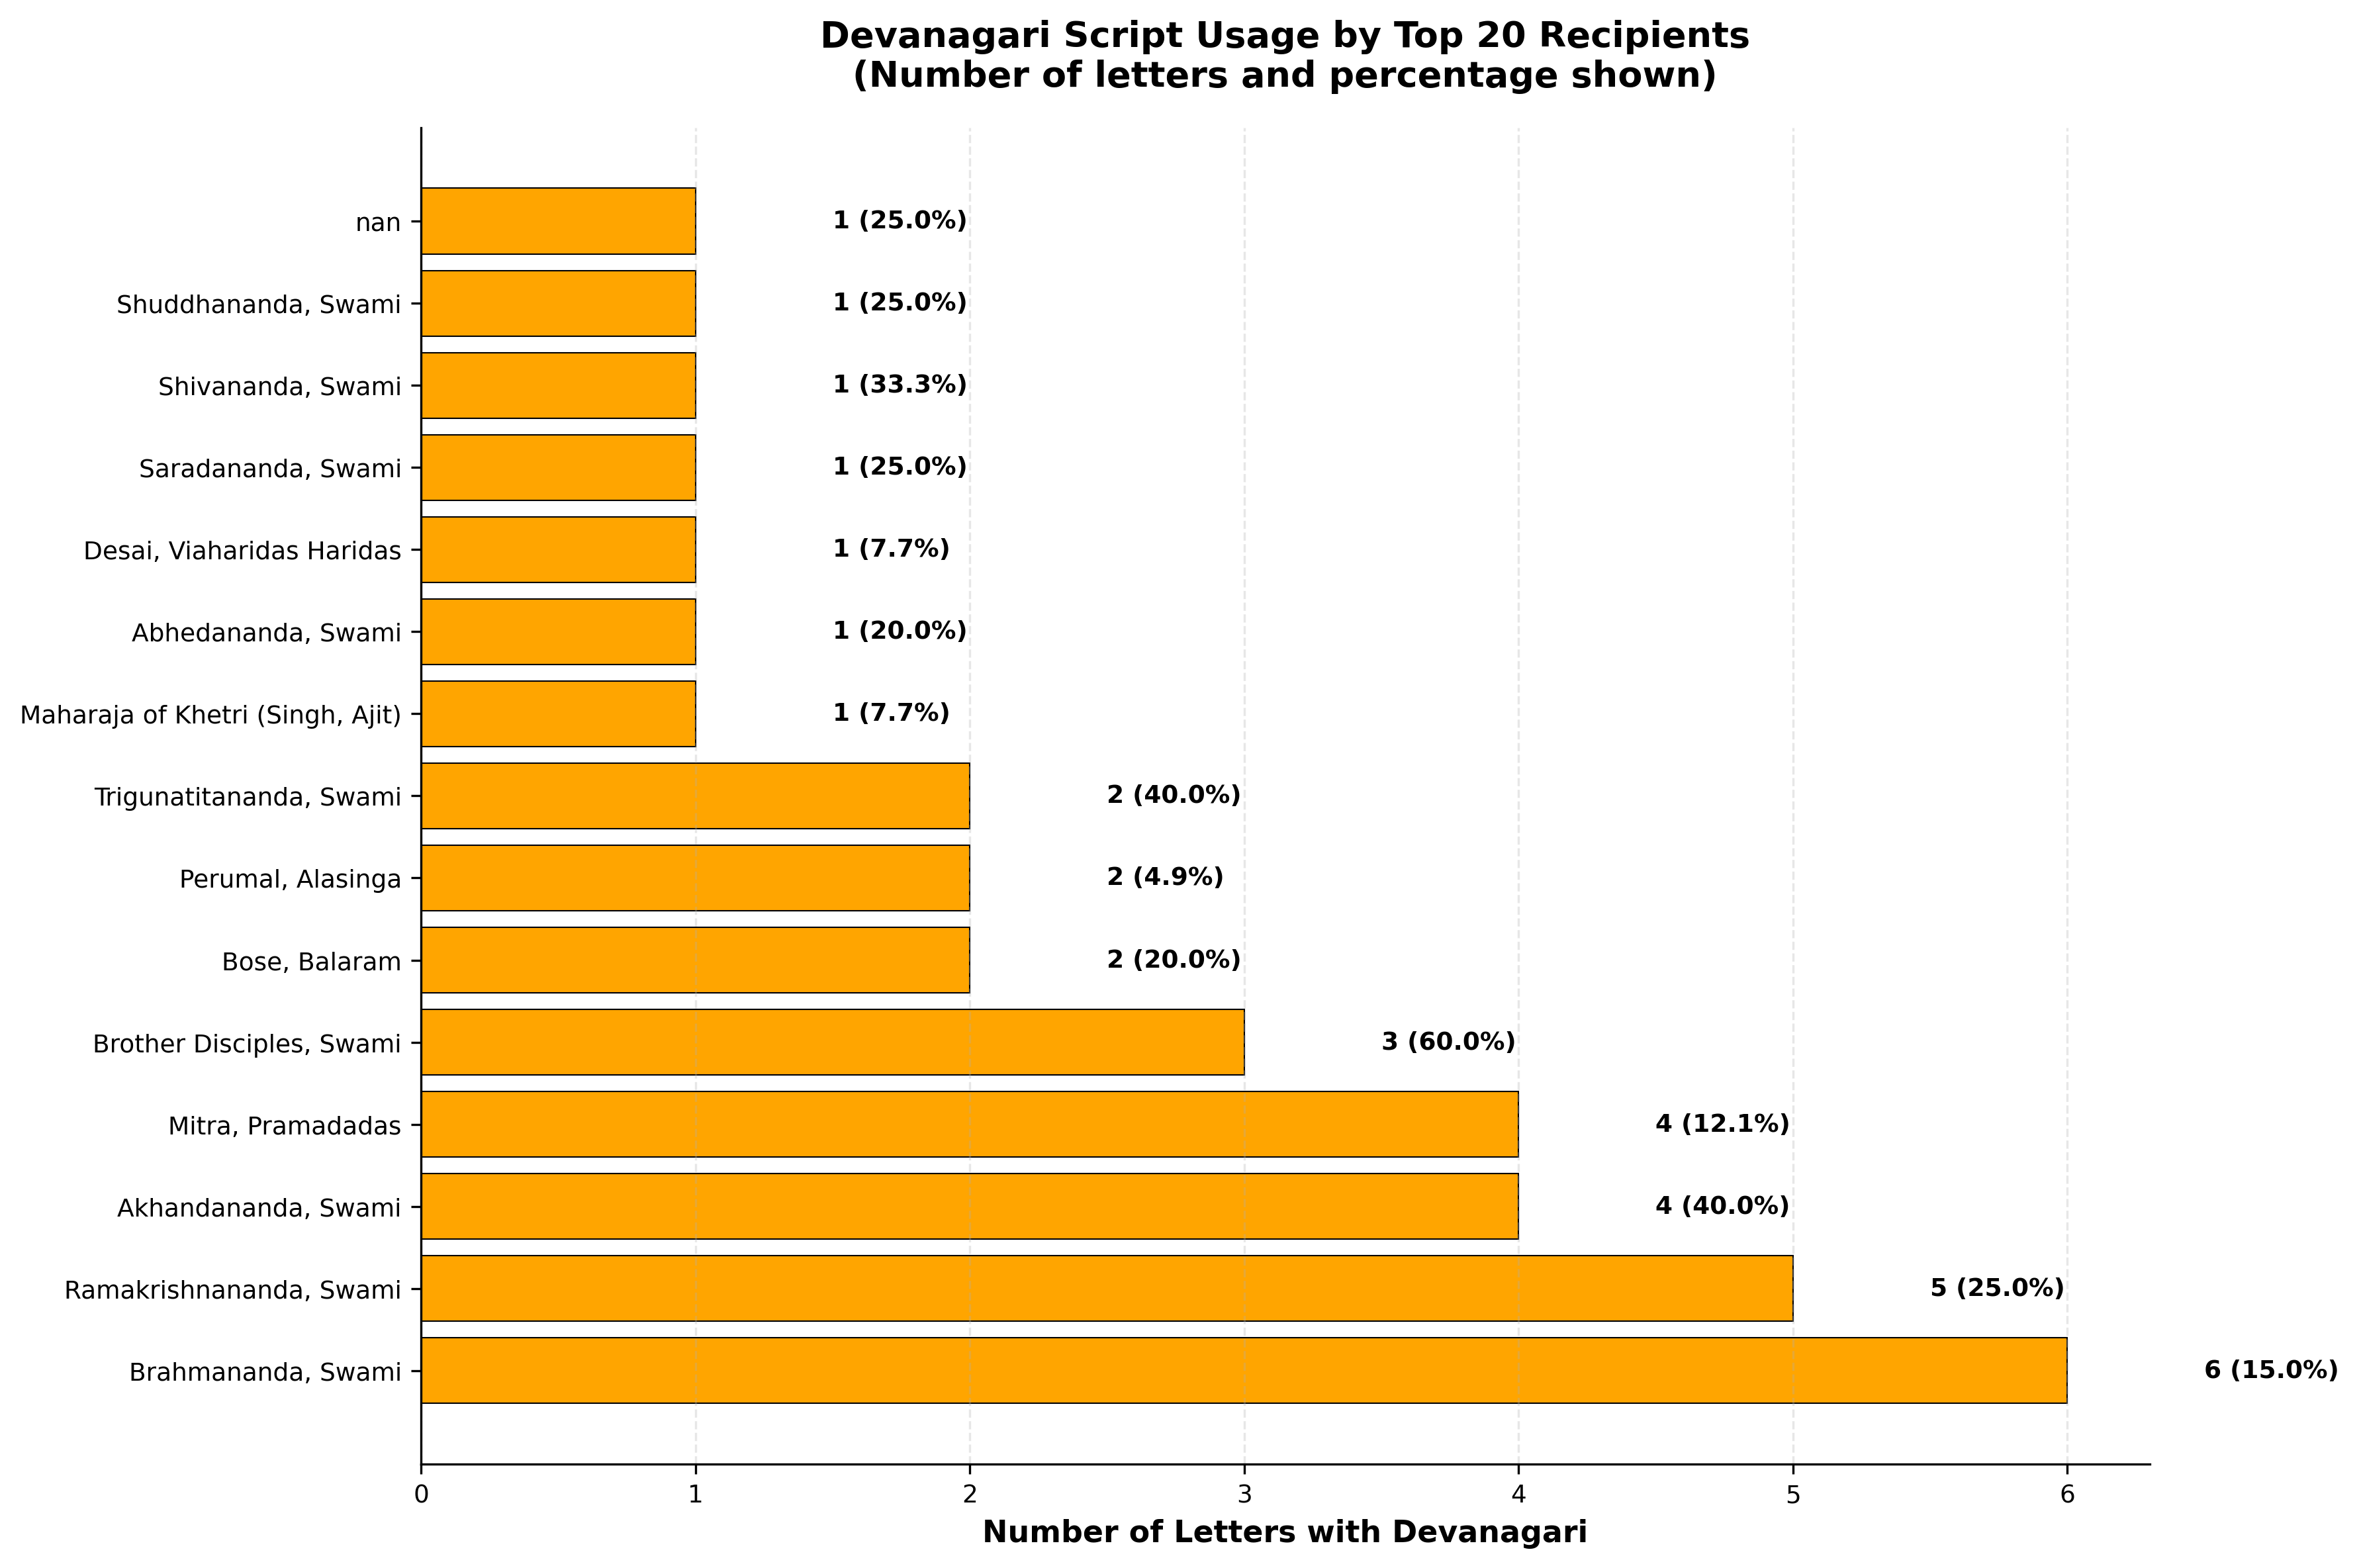


[Visualization 2] Creating year-wise Devanagari usage chart...
  ✓ Saved: viz_devanagari_by_year.png


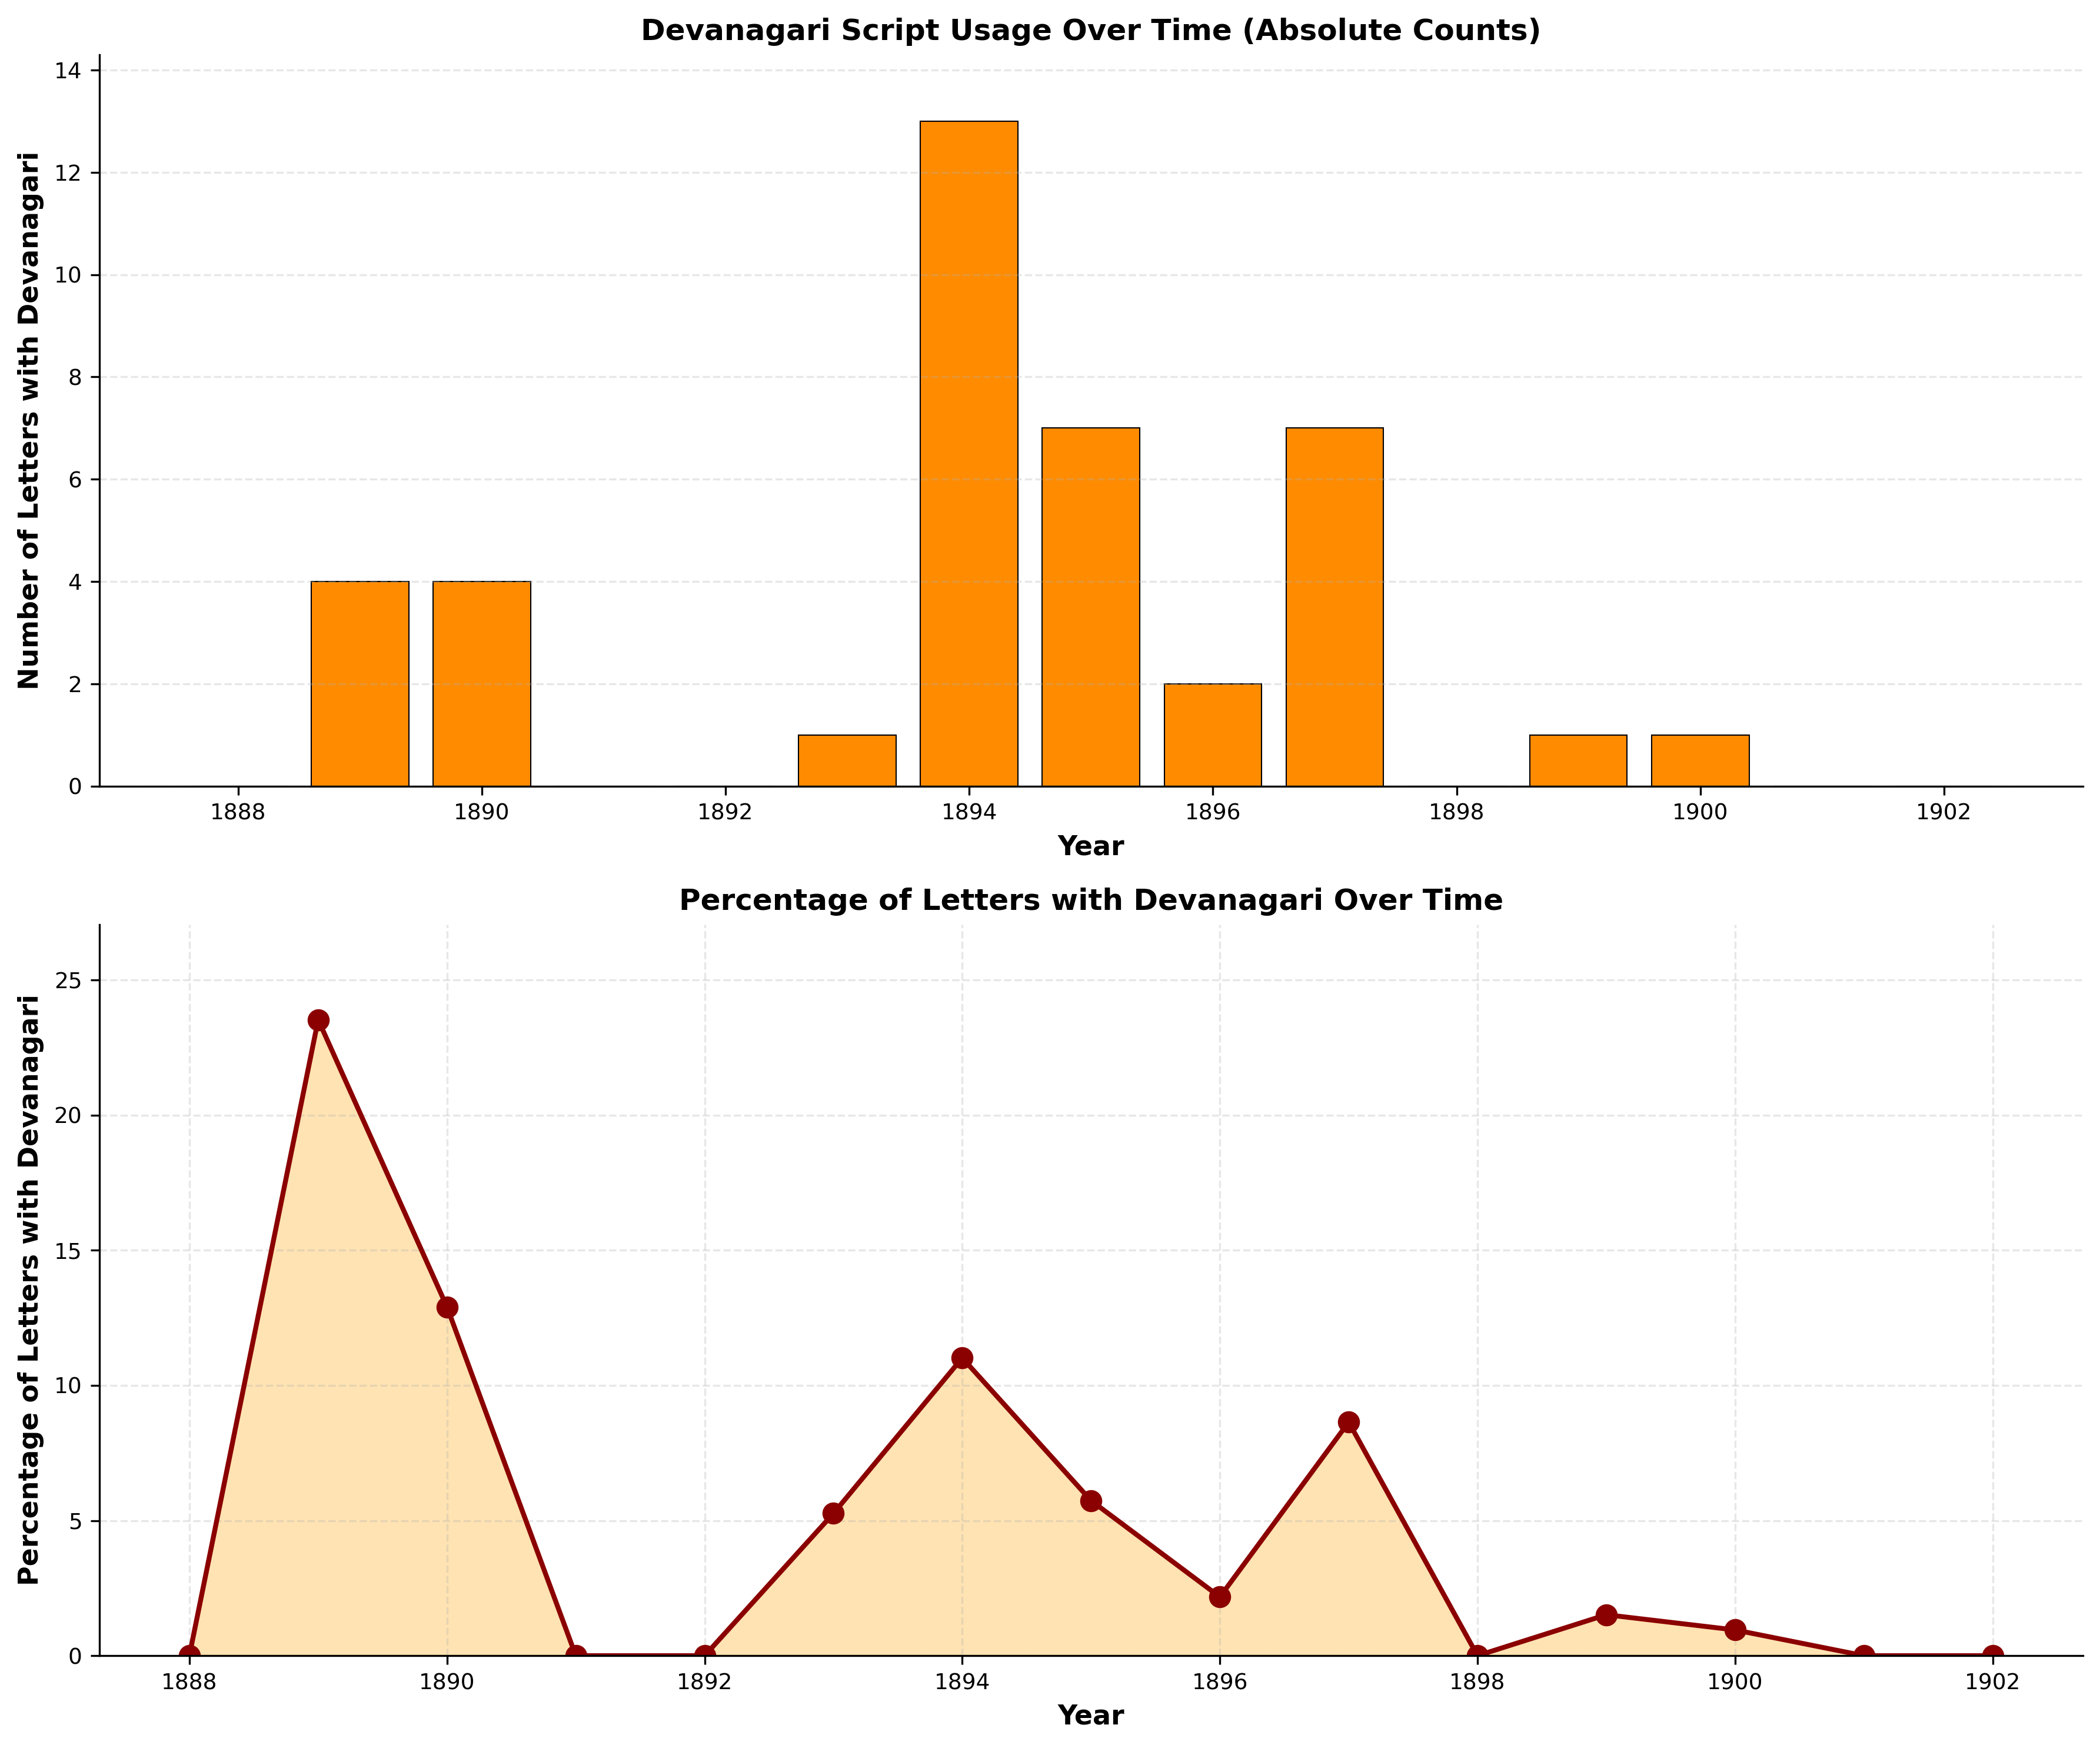


[Visualization 3] Creating period-wise Devanagari usage chart...
  ✓ Saved: viz_devanagari_by_period.png


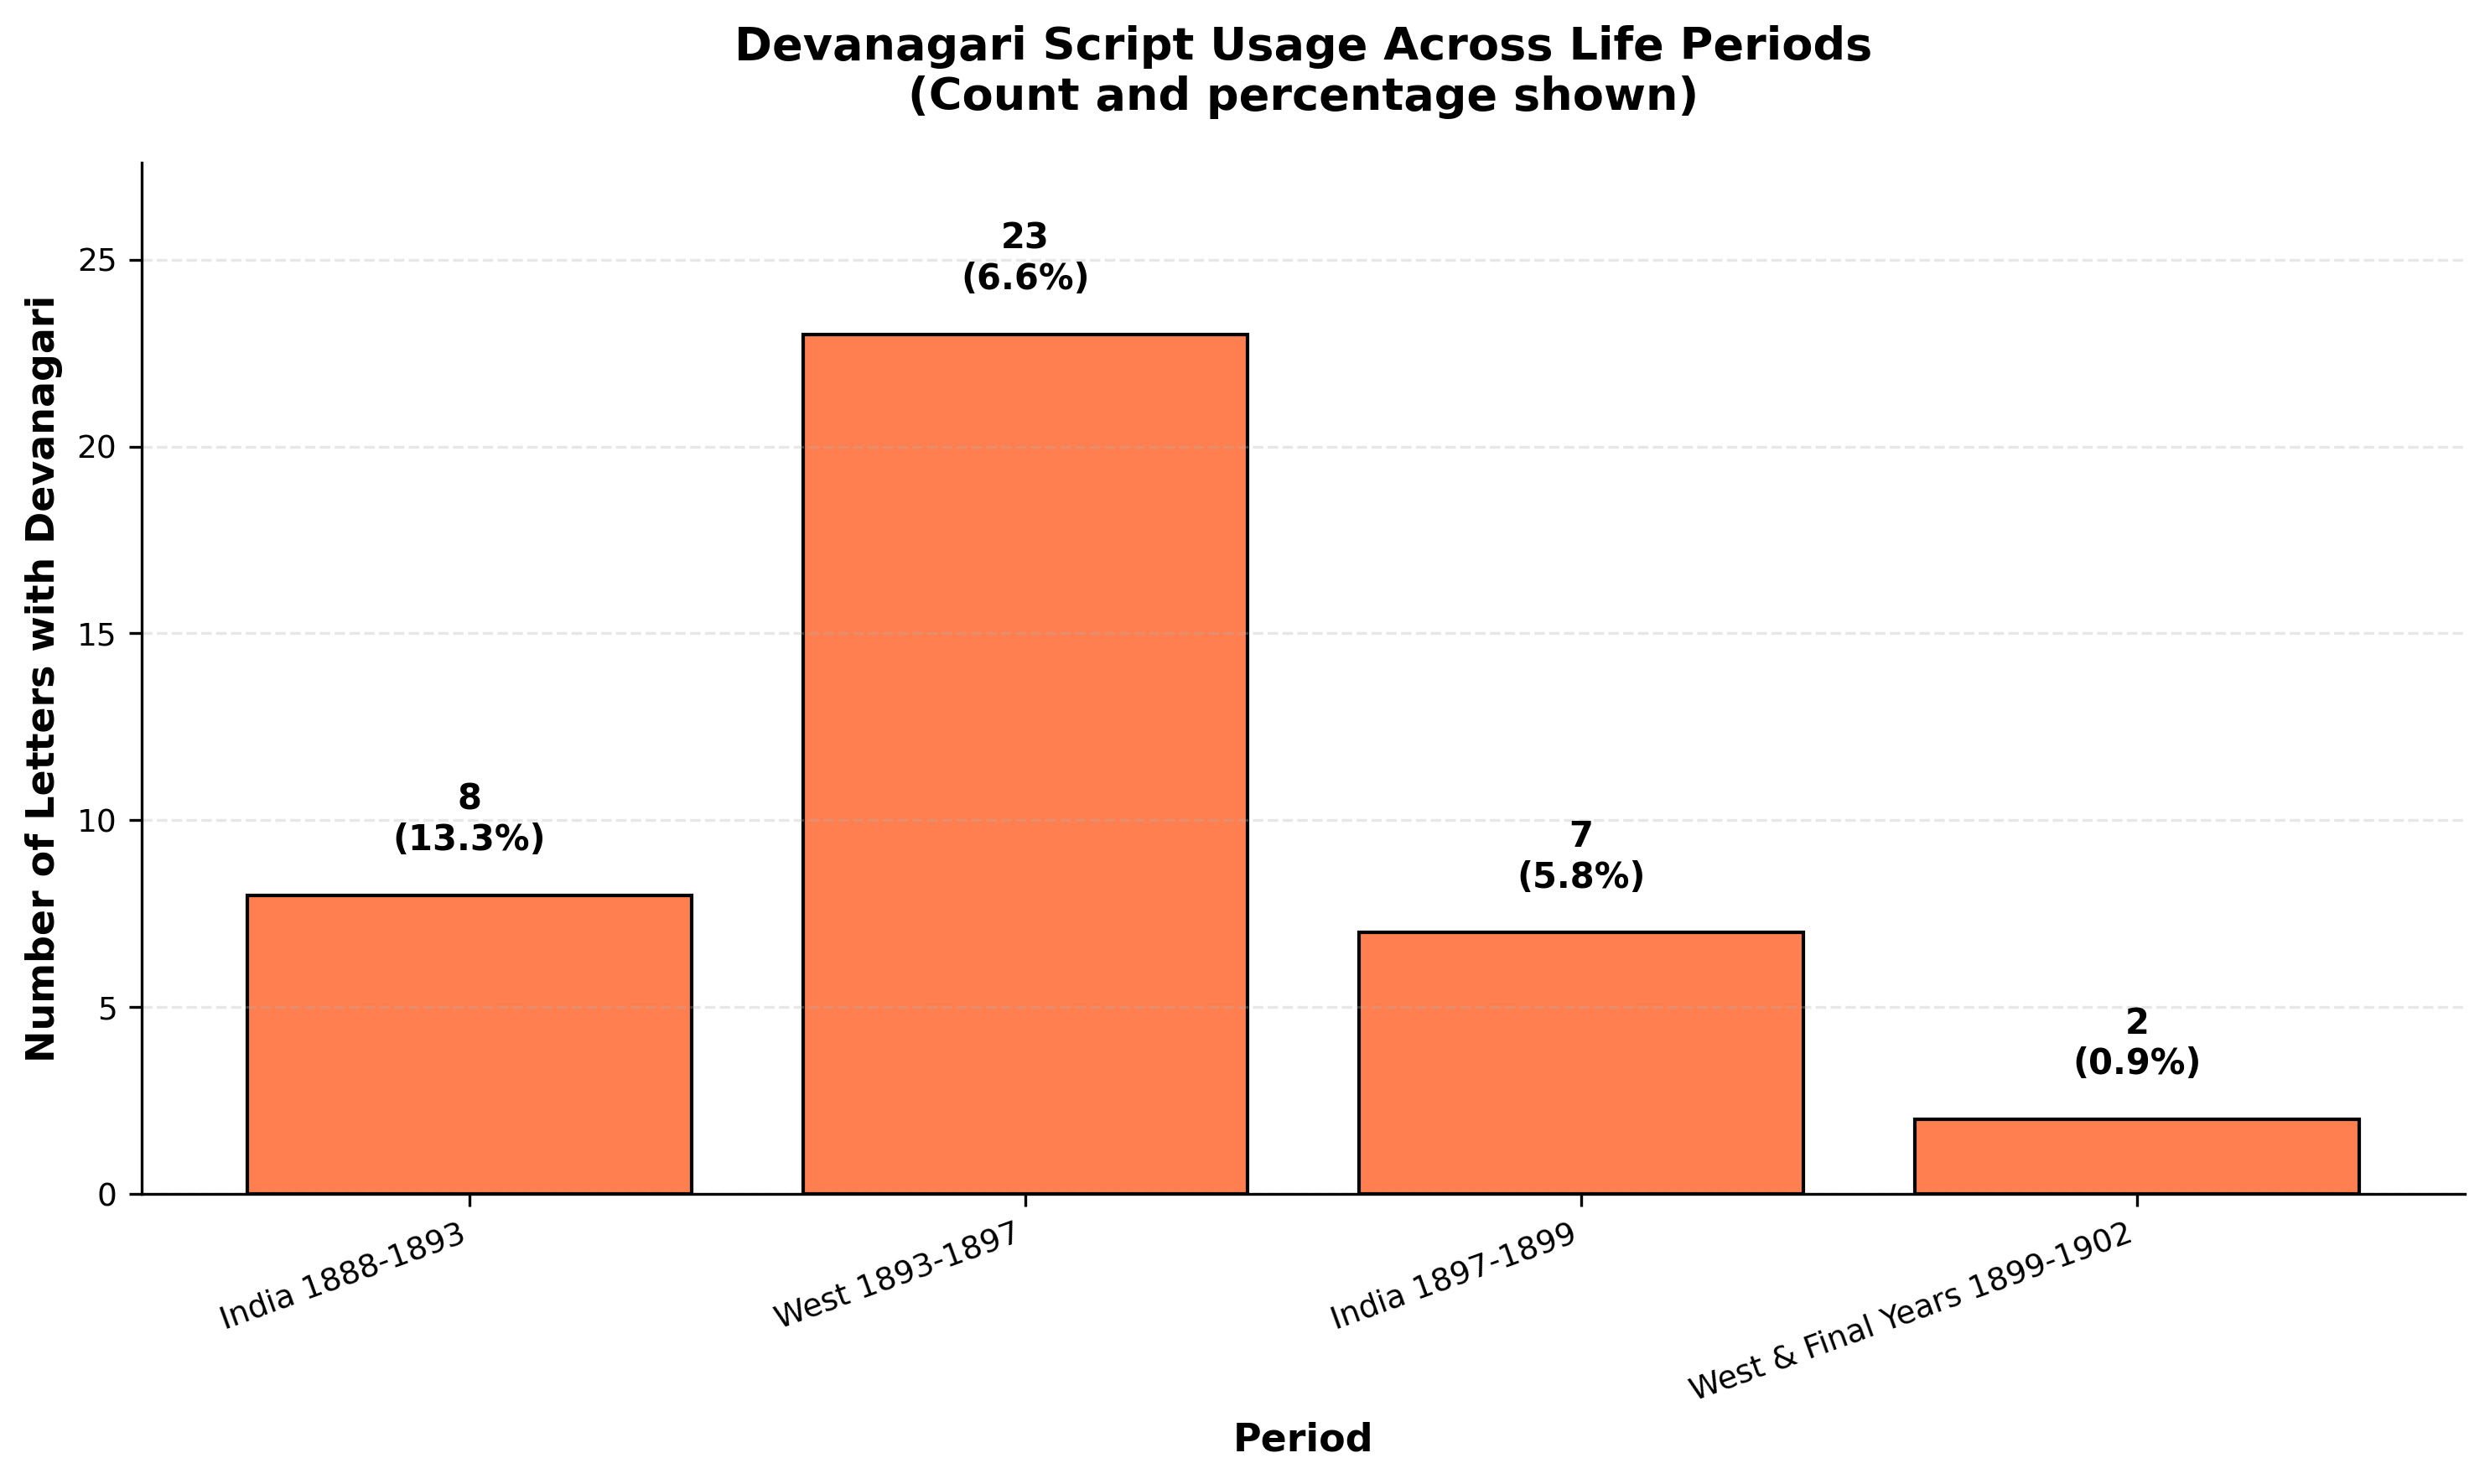


[Visualization 4] Creating region-wise Devanagari usage chart...
  ✓ Saved: viz_devanagari_by_region.png


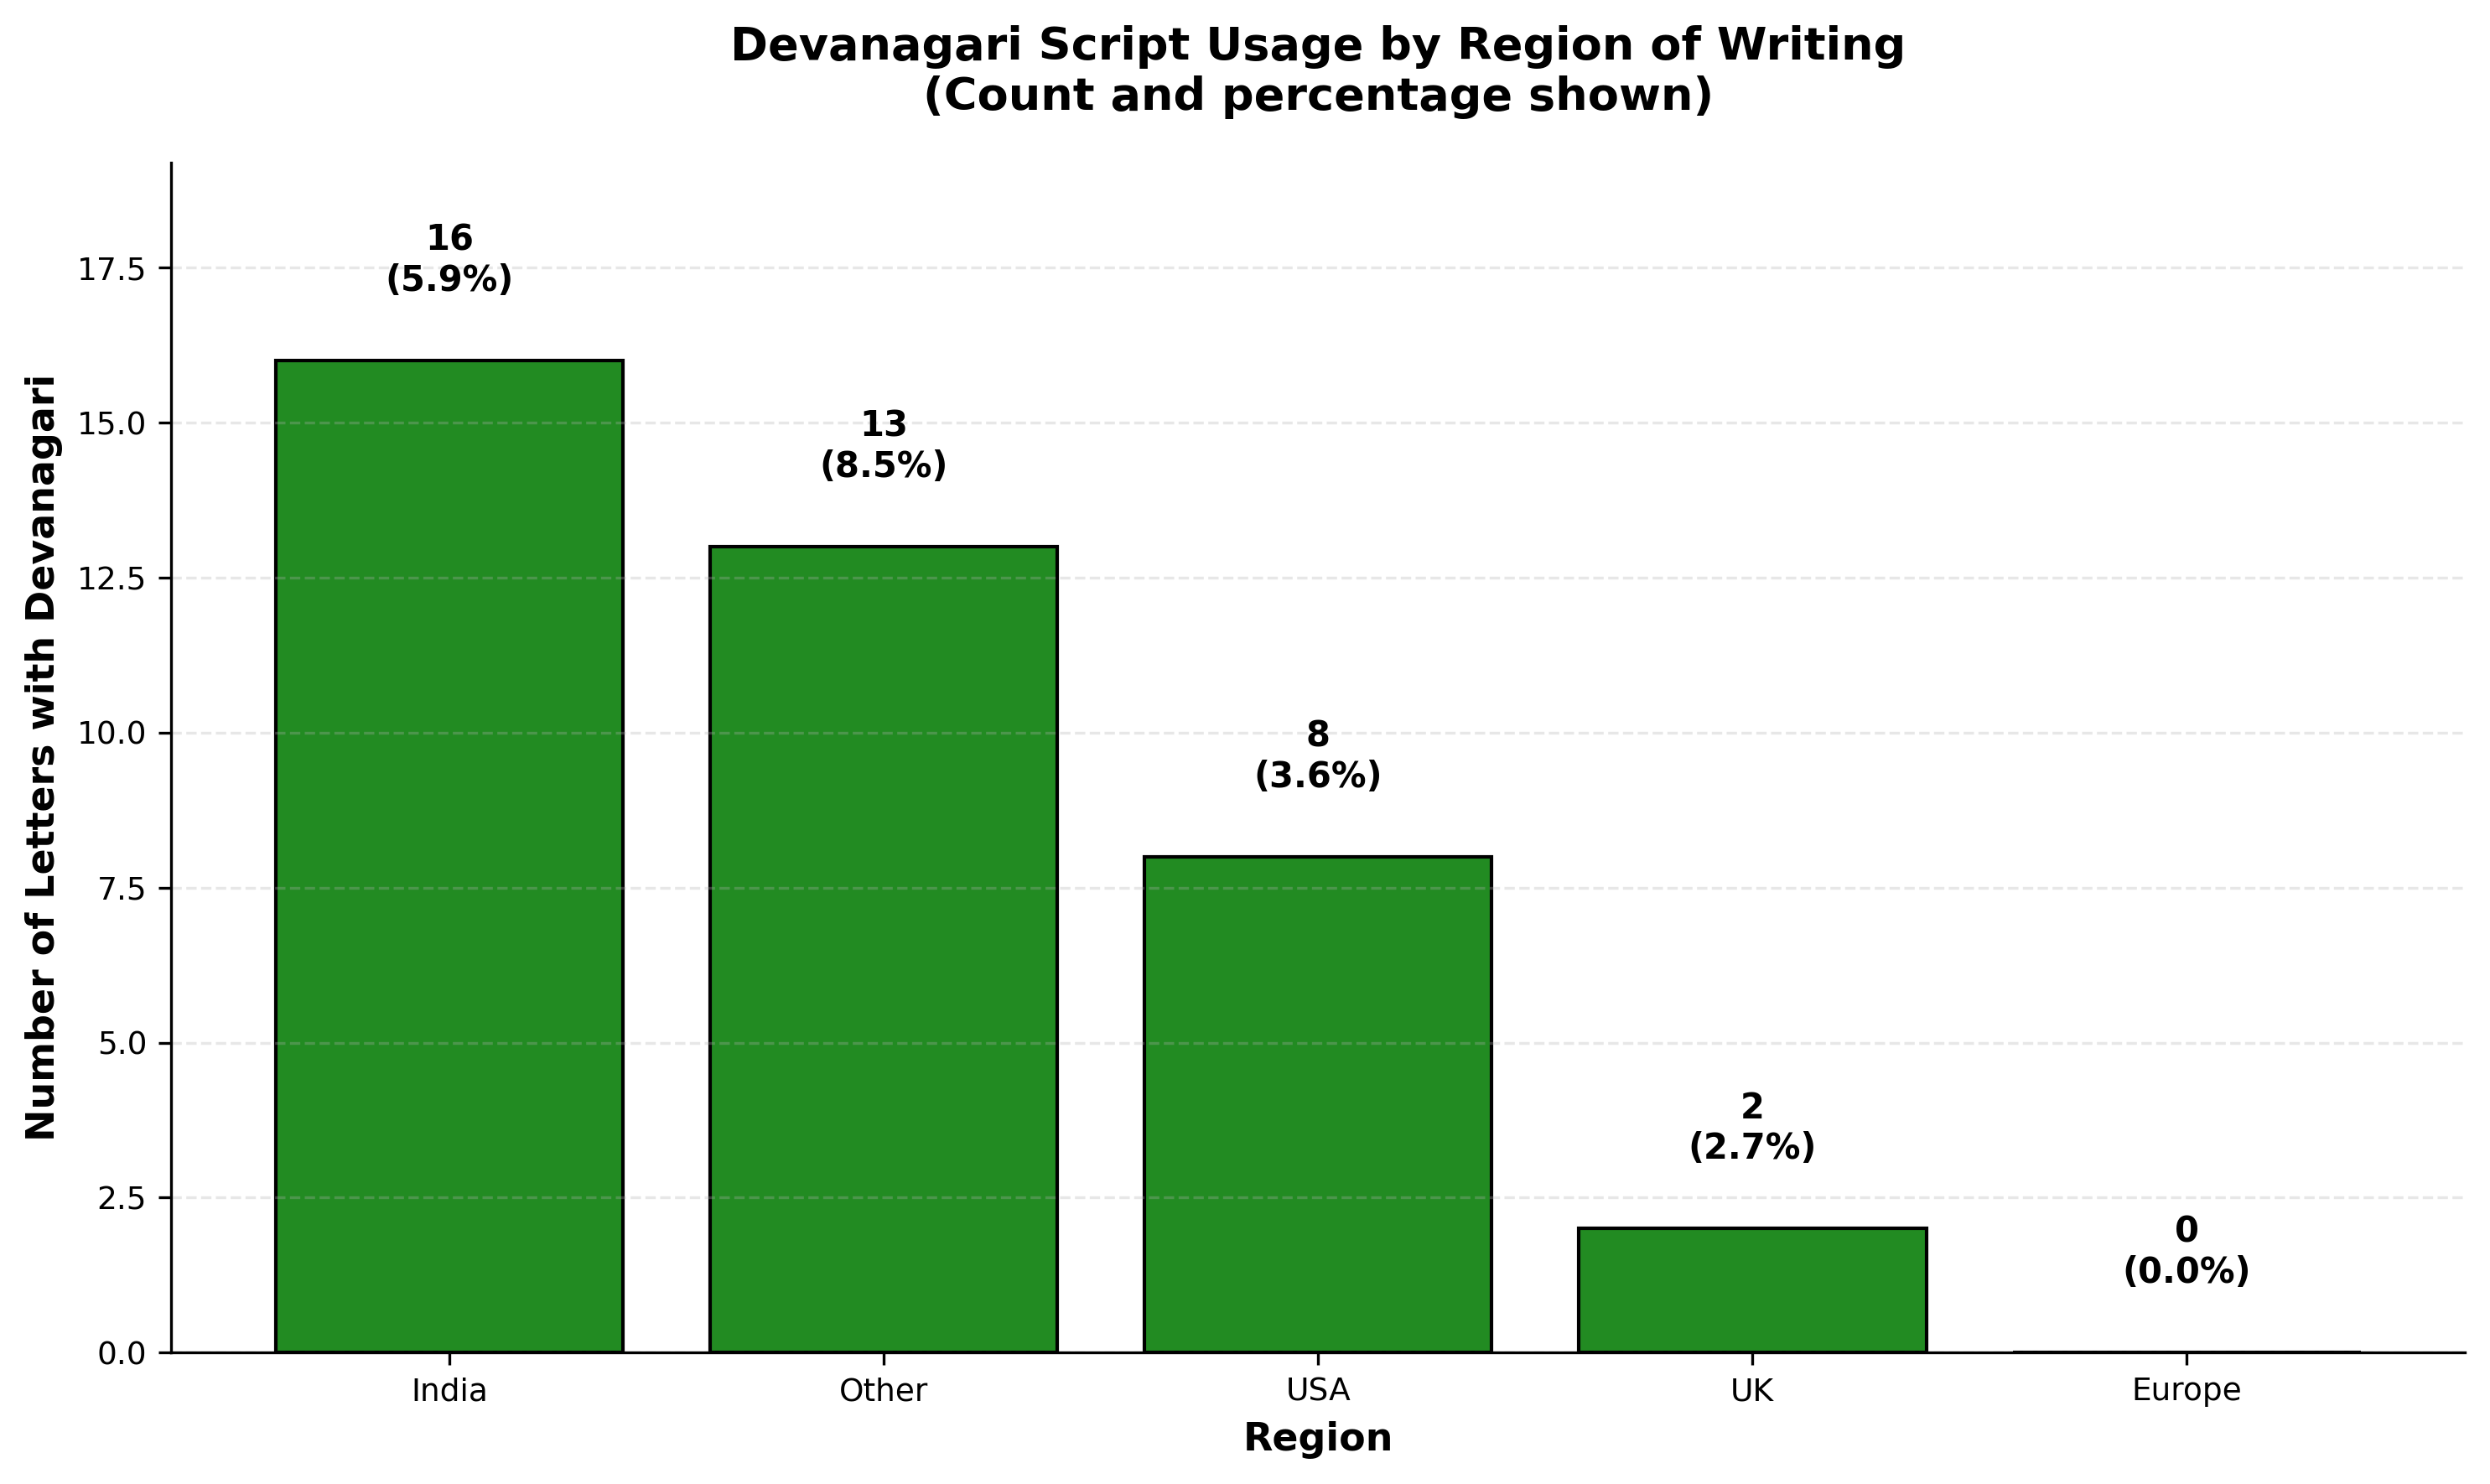


[Step 6] Extracting example sentences with Devanagari...

  Sample examples of Devanagari usage (5 from different recipients):

1. Letter: XXIV Kali


ValueError: Invalid format specifier '.0f if pd.notna(row['Year']) else 'Unknown'' for object of type 'float'

In [12]:
# ============================================================================
# DEVANAGARI SCRIPT USAGE ANALYSIS
# Analyze when and to whom Swamiji used Devanagari script
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DEVANAGARI SCRIPT USAGE ANALYSIS")
print("="*80)

# ============================================================================
# STEP 1: DETECT DEVANAGARI CHARACTERS IN LETTER BODIES
# ============================================================================
print("\n[Step 1] Detecting Devanagari characters in letters...")

def contains_devanagari(text):
    """Check if text contains Devanagari Unicode characters"""
    if pd.isna(text):
        return False

    text = str(text)
    # Devanagari Unicode range: U+0900 to U+097F
    devanagari_pattern = re.compile(r'[\u0900-\u097F]')
    return bool(devanagari_pattern.search(text))

def count_devanagari_chars(text):
    """Count number of Devanagari characters in text"""
    if pd.isna(text):
        return 0

    text = str(text)
    devanagari_pattern = re.compile(r'[\u0900-\u097F]')
    return len(devanagari_pattern.findall(text))

def extract_devanagari_sentences(text):
    """Extract sentences containing Devanagari characters"""
    if pd.isna(text):
        return []

    text = str(text)
    devanagari_pattern = re.compile(r'[\u0900-\u097F]')

    # Split into sentences
    sentences = re.split(r'[.!?]+', text)

    # Find sentences with Devanagari
    devanagari_sentences = []
    for sent in sentences:
        if devanagari_pattern.search(sent):
            devanagari_sentences.append(sent.strip())

    return devanagari_sentences

# Apply detection to all letters
all_letters['has_devanagari'] = all_letters['body_text'].apply(contains_devanagari)
all_letters['devanagari_char_count'] = all_letters['body_text'].apply(count_devanagari_chars)
all_letters['devanagari_sentences'] = all_letters['body_text'].apply(extract_devanagari_sentences)

# Calculate percentage of Devanagari in each letter
all_letters['total_char_count'] = all_letters['body_text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
all_letters['devanagari_percentage'] = (all_letters['devanagari_char_count'] / all_letters['total_char_count'] * 100).fillna(0)

print(f"  ✓ Total letters: {len(all_letters)}")
print(f"  ✓ Letters with Devanagari: {all_letters['has_devanagari'].sum()}")
print(f"  ✓ Letters without Devanagari: {(~all_letters['has_devanagari']).sum()}")
print(f"  ✓ Percentage with Devanagari: {all_letters['has_devanagari'].sum()/len(all_letters)*100:.1f}%")

# ============================================================================
# STEP 2: ANALYZE BY RECIPIENT
# ============================================================================
print("\n[Step 2] Analyzing Devanagari usage by recipient...")

recipient_devanagari = all_letters.groupby('Audience_clean').agg({
    'has_devanagari': ['sum', 'count'],
    'devanagari_char_count': 'sum',
    'devanagari_percentage': 'mean'
}).reset_index()

recipient_devanagari.columns = ['recipient', 'letters_with_devanagari', 'total_letters',
                                'total_devanagari_chars', 'avg_devanagari_percentage']
recipient_devanagari['percentage_letters_with_devanagari'] = (
    recipient_devanagari['letters_with_devanagari'] / recipient_devanagari['total_letters'] * 100
)

# Filter recipients with at least 3 letters AND at least one letter with Devanagari
recipient_devanagari = recipient_devanagari[
    (recipient_devanagari['total_letters'] >= 3) &
    (recipient_devanagari['letters_with_devanagari'] > 0)
].copy()
recipient_devanagari = recipient_devanagari.sort_values('letters_with_devanagari', ascending=False)

print(f"\n  Top 15 recipients by number of letters with Devanagari:")
for i, row in recipient_devanagari.head(15).iterrows():
    print(f"    {row['recipient']}: {row['letters_with_devanagari']:.0f}/{row['total_letters']:.0f} letters ({row['percentage_letters_with_devanagari']:.1f}%)")

# ============================================================================
# STEP 3: ANALYZE BY YEAR
# ============================================================================
print("\n[Step 3] Analyzing Devanagari usage by year...")

year_devanagari = all_letters[all_letters['year'].notna()].groupby('year').agg({
    'has_devanagari': ['sum', 'count'],
    'devanagari_char_count': 'sum',
    'devanagari_percentage': 'mean'
}).reset_index()

year_devanagari.columns = ['year', 'letters_with_devanagari', 'total_letters',
                          'total_devanagari_chars', 'avg_devanagari_percentage']
year_devanagari['percentage_letters_with_devanagari'] = (
    year_devanagari['letters_with_devanagari'] / year_devanagari['total_letters'] * 100
)

print(f"\n  Devanagari usage by year:")
for i, row in year_devanagari.iterrows():
    print(f"    {row['year']:.0f}: {row['letters_with_devanagari']:.0f}/{row['total_letters']:.0f} letters ({row['percentage_letters_with_devanagari']:.1f}%)")

# ============================================================================
# STEP 4: ANALYZE BY PERIOD
# ============================================================================
print("\n[Step 4] Analyzing Devanagari usage by period...")

period_devanagari = all_letters[all_letters['period'] != 'Unknown'].groupby('period').agg({
    'has_devanagari': ['sum', 'count'],
    'devanagari_char_count': 'sum',
    'devanagari_percentage': 'mean'
}).reset_index()

period_devanagari.columns = ['period', 'letters_with_devanagari', 'total_letters',
                            'total_devanagari_chars', 'avg_devanagari_percentage']
period_devanagari['percentage_letters_with_devanagari'] = (
    period_devanagari['letters_with_devanagari'] / period_devanagari['total_letters'] * 100
)

print(f"\n  Devanagari usage by period:")
for i, row in period_devanagari.iterrows():
    period_label = period_labels.get(row['period'], row['period'])
    print(f"    {period_label}: {row['letters_with_devanagari']:.0f}/{row['total_letters']:.0f} letters ({row['percentage_letters_with_devanagari']:.1f}%)")

# ============================================================================
# STEP 5: ANALYZE BY PLACE (COUNTRY/REGION)
# ============================================================================
print("\n[Step 5] Analyzing Devanagari usage by place...")

# Extract country/region from Place column (simplified)
def extract_region(place):
    """Extract region from place string"""
    if pd.isna(place):
        return 'Unknown'

    place = str(place).strip()

    # Indian cities/regions
    indian_places = ['Calcutta', 'Madras', 'Bombay', 'Almora', 'Baranagore', 'Belur',
                     'Khetri', 'Kashmir', 'India', 'Darjeeling', 'Trivandrum', 'Madura']

    # Western cities
    us_places = ['New York', 'Chicago', 'Boston', 'Detroit', 'Los Angeles', 'Thousand Island',
                'Ridgely', 'Camp Percy']
    uk_places = ['London', 'England']
    europe_places = ['Paris', 'Switzerland', 'Berlin', 'Rome', 'Vienna']

    for indian in indian_places:
        if indian.lower() in place.lower():
            return 'India'

    for us in us_places:
        if us.lower() in place.lower():
            return 'USA'

    for uk in uk_places:
        if uk.lower() in place.lower():
            return 'UK'

    for euro in europe_places:
        if euro.lower() in place.lower():
            return 'Europe'

    return 'Other'

all_letters['region'] = all_letters['Place'].apply(extract_region)

place_devanagari = all_letters[all_letters['region'] != 'Unknown'].groupby('region').agg({
    'has_devanagari': ['sum', 'count'],
    'devanagari_char_count': 'sum',
    'devanagari_percentage': 'mean'
}).reset_index()

place_devanagari.columns = ['region', 'letters_with_devanagari', 'total_letters',
                           'total_devanagari_chars', 'avg_devanagari_percentage']
place_devanagari['percentage_letters_with_devanagari'] = (
    place_devanagari['letters_with_devanagari'] / place_devanagari['total_letters'] * 100
)

place_devanagari = place_devanagari.sort_values('letters_with_devanagari', ascending=False)

print(f"\n  Devanagari usage by region:")
for i, row in place_devanagari.iterrows():
    print(f"    {row['region']}: {row['letters_with_devanagari']:.0f}/{row['total_letters']:.0f} letters ({row['percentage_letters_with_devanagari']:.1f}%)")

# ============================================================================
# VISUALIZATION 1: DEVANAGARI USAGE BY TOP RECIPIENTS
# ============================================================================
print("\n[Visualization 1] Creating recipient Devanagari usage chart...")

top_recipients_dev = recipient_devanagari.head(20)

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(range(len(top_recipients_dev)), top_recipients_dev['letters_with_devanagari'],
               color='orange', edgecolor='black', linewidth=0.5)

# Add value labels with percentages
for i, row in enumerate(top_recipients_dev.itertuples()):
    ax.text(row.letters_with_devanagari + 0.5, i,
            f'{row.letters_with_devanagari:.0f} ({row.percentage_letters_with_devanagari:.1f}%)',
            va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(len(top_recipients_dev)))
ax.set_yticklabels(top_recipients_dev['recipient'])
ax.set_xlabel('Number of Letters with Devanagari', fontsize=11, fontweight='bold')
ax.set_title('Devanagari Script Usage by Top 20 Recipients\n(Number of letters and percentage shown)',
             fontsize=13, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('viz_devanagari_by_recipient.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz_devanagari_by_recipient.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: DEVANAGARI USAGE BY YEAR
# ============================================================================
print("\n[Visualization 2] Creating year-wise Devanagari usage chart...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top: Absolute counts
x = year_devanagari['year']
ax1.bar(x, year_devanagari['letters_with_devanagari'], color='darkorange',
        edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Year', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Letters with Devanagari', fontsize=11, fontweight='bold')
ax1.set_title('Devanagari Script Usage Over Time (Absolute Counts)',
              fontsize=12, fontweight='bold')
ax1.set_ylim(0, year_devanagari['letters_with_devanagari'].max() * 1.1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Bottom: Percentage
ax2.plot(x, year_devanagari['percentage_letters_with_devanagari'],
         marker='o', color='darkred', linewidth=2, markersize=8)
ax2.fill_between(x, 0, year_devanagari['percentage_letters_with_devanagari'],
                 alpha=0.3, color='orange')

ax2.set_xlabel('Year', fontsize=11, fontweight='bold')
ax2.set_ylabel('Percentage of Letters with Devanagari', fontsize=11, fontweight='bold')
ax2.set_title('Percentage of Letters with Devanagari Over Time',
              fontsize=12, fontweight='bold')
ax2.set_ylim(0, year_devanagari['percentage_letters_with_devanagari'].max() * 1.15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('viz_devanagari_by_year.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz_devanagari_by_year.png")
plt.show()

# ============================================================================
# VISUALIZATION 3: DEVANAGARI USAGE BY PERIOD
# ============================================================================
print("\n[Visualization 3] Creating period-wise Devanagari usage chart...")

# Sort periods chronologically
period_order = ['Period1_India_1888-1893', 'Period2_West_1893-1897',
                'Period3_India_1897-1899', 'Period4_West_Final_1899-1902']
period_devanagari['period'] = pd.Categorical(period_devanagari['period'],
                                             categories=period_order, ordered=True)
period_devanagari = period_devanagari.sort_values('period')

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(period_devanagari))
bars = ax.bar(x, period_devanagari['letters_with_devanagari'],
              color='coral', edgecolor='black', linewidth=1)

# Add percentage labels
for i, row in enumerate(period_devanagari.itertuples()):
    pct = row.percentage_letters_with_devanagari
    ax.text(i, row.letters_with_devanagari + 1,
            f'{row.letters_with_devanagari:.0f}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Period', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Letters with Devanagari', fontsize=11, fontweight='bold')
ax.set_title('Devanagari Script Usage Across Life Periods\n(Count and percentage shown)',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels([period_labels[p] for p in period_devanagari['period']], rotation=20, ha='right')
ax.set_ylim(0, period_devanagari['letters_with_devanagari'].max() * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('viz_devanagari_by_period.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz_devanagari_by_period.png")
plt.show()

# ============================================================================
# VISUALIZATION 4: DEVANAGARI USAGE BY REGION
# ============================================================================
print("\n[Visualization 4] Creating region-wise Devanagari usage chart...")

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(place_devanagari))
bars = ax.bar(x, place_devanagari['letters_with_devanagari'],
              color='forestgreen', edgecolor='black', linewidth=1)

# Add percentage labels
for i, row in enumerate(place_devanagari.itertuples()):
    pct = row.percentage_letters_with_devanagari
    ax.text(i, row.letters_with_devanagari + 1,
            f'{row.letters_with_devanagari:.0f}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Region', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Letters with Devanagari', fontsize=11, fontweight='bold')
ax.set_title('Devanagari Script Usage by Region of Writing\n(Count and percentage shown)',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(place_devanagari['region'])
ax.set_ylim(0, place_devanagari['letters_with_devanagari'].max() * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('viz_devanagari_by_region.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: viz_devanagari_by_region.png")
plt.show()

# ============================================================================
# STEP 6: EXTRACT EXAMPLE SENTENCES WITH DEVANAGARI
# ============================================================================
print("\n[Step 6] Extracting example sentences with Devanagari...")

# Get letters with Devanagari
devanagari_letters = all_letters[all_letters['has_devanagari']].copy()

# Create examples dataframe
examples = []
for idx, row in devanagari_letters.iterrows():
    if len(row['devanagari_sentences']) > 0:
        # Take first sentence with Devanagari
        first_sentence = row['devanagari_sentences'][0]
        # Limit sentence length for readability
        if len(first_sentence) > 200:
            first_sentence = first_sentence[:200] + "..."

        examples.append({
            'Letter_Name': row['Name'],
            'Year': row['year'],
            'Recipient': row['Audience_clean'],
            'Sentence_with_Devanagari': first_sentence,
            'URL': row['full_url']
        })

examples_df = pd.DataFrame(examples)

# Sample examples from different recipients
print("\n  Sample examples of Devanagari usage (5 from different recipients):")
print("="*100)

# Get diverse sample
sampled = examples_df.groupby('Recipient').first().reset_index().head(5)

for i, row in sampled.iterrows():
    print(f"\n{i+1}. Letter: {row['Letter_Name']}")
    print(f"   Year: {row['Year']:.0f if pd.notna(row['Year']) else 'Unknown'}")
    print(f"   To: {row['Recipient']}")
    print(f"   Sentence: {row['Sentence_with_Devanagari']}")
    print(f"   URL: {row['URL']}")
    print("-"*100)

# Save full examples to CSV
examples_df.to_csv('devanagari_examples.csv', index=False)
print(f"\n  ✓ Saved all {len(examples_df)} examples to: devanagari_examples.csv")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("DEVANAGARI USAGE SUMMARY")
print("="*80)

print(f"\nOverall Statistics:")
print(f"  • Total letters analyzed: {len(all_letters)}")
print(f"  • Letters with Devanagari: {all_letters['has_devanagari'].sum()} ({all_letters['has_devanagari'].sum()/len(all_letters)*100:.1f}%)")
print(f"  • Total Devanagari characters used: {all_letters['devanagari_char_count'].sum()}")
print(f"  • Average Devanagari % per letter (when present): {all_letters[all_letters['has_devanagari']]['devanagari_percentage'].mean():.2f}%")

print(f"\nRecipient with most Devanagari letters:")
top_dev_recipient = recipient_devanagari.iloc[0]
print(f"  • {top_dev_recipient['recipient']}: {top_dev_recipient['letters_with_devanagari']:.0f} letters ({top_dev_recipient['percentage_letters_with_devanagari']:.1f}%)")

print(f"\nYear with most Devanagari usage:")
top_dev_year = year_devanagari.nlargest(1, 'letters_with_devanagari').iloc[0]
print(f"  • {top_dev_year['year']:.0f}: {top_dev_year['letters_with_devanagari']:.0f} letters ({top_dev_year['percentage_letters_with_devanagari']:.1f}%)")

print("\n✓ All Devanagari analysis complete!")
print("="*80)

In [13]:
# ============================================================================
# PRINT DEVANAGARI EXAMPLES
# Display example sentences with Devanagari script from various recipients
# ============================================================================

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DEVANAGARI USAGE EXAMPLES")
print("="*80)

# Get letters with Devanagari
devanagari_letters = all_letters[all_letters['has_devanagari']].copy()

# Create examples dataframe
examples = []
for idx, row in devanagari_letters.iterrows():
    if len(row['devanagari_sentences']) > 0:
        # Take first sentence with Devanagari
        first_sentence = row['devanagari_sentences'][0]
        # Limit sentence length for readability
        if len(first_sentence) > 200:
            first_sentence = first_sentence[:200] + "..."

        examples.append({
            'Letter_Name': row['Name'],
            'Year': row['year'],
            'Recipient': row['Audience_clean'],
            'Sentence_with_Devanagari': first_sentence,
            'URL': row['full_url']
        })

examples_df = pd.DataFrame(examples)

# Save full examples to CSV
examples_df.to_csv('devanagari_examples.csv', index=False)
print(f"✓ Saved all {len(examples_df)} examples to: devanagari_examples.csv")

# Sample examples from different recipients
print("\n" + "="*80)
print("SAMPLE EXAMPLES FROM DIFFERENT RECIPIENTS")
print("="*80)

# Get diverse sample - one from each unique recipient
sampled = examples_df.groupby('Recipient').first().reset_index().head(10)

for i, row in sampled.iterrows():
    year_str = f"{int(row['Year'])}" if pd.notna(row['Year']) else "Unknown"

    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}")
    print(f"{'='*80}")
    print(f"Letter Name: {row['Letter_Name']}")
    print(f"Year: {year_str}")
    print(f"Recipient: {row['Recipient']}")
    print(f"\nSentence with Devanagari:")
    print(f"  {row['Sentence_with_Devanagari']}")
    print(f"\nURL: {row['URL']}")

# Additional examples grouped by recipient
print("\n\n" + "="*80)
print("MORE EXAMPLES - TOP 5 RECIPIENTS WITH MOST DEVANAGARI LETTERS")
print("="*80)

top_recipients = examples_df['Recipient'].value_counts().head(5).index

for recipient in top_recipients:
    recipient_examples = examples_df[examples_df['Recipient'] == recipient].head(3)

    print(f"\n{'='*80}")
    print(f"TO: {recipient} ({len(examples_df[examples_df['Recipient'] == recipient])} letters with Devanagari)")
    print(f"{'='*80}")

    for j, row in enumerate(recipient_examples.iterrows(), 1):
        row = row[1]  # Get the actual row data
        year_str = f"{int(row['Year'])}" if pd.notna(row['Year']) else "Unknown"

        print(f"\n  Example {j}:")
        print(f"  Letter: {row['Letter_Name']} ({year_str})")
        print(f"  Sentence: {row['Sentence_with_Devanagari'][:150]}...")
        print(f"  URL: {row['URL']}")

print("\n" + "="*80)
print("✓ Examples printed successfully!")
print("="*80)

DEVANAGARI USAGE EXAMPLES
✓ Saved all 40 examples to: devanagari_examples.csv

SAMPLE EXAMPLES FROM DIFFERENT RECIPIENTS

EXAMPLE 1
Letter Name: XXIV Kali
Year: 1894
Recipient: Abhedananda, Swami

Sentence with Devanagari:
  "शिवा वः सन्तु पन्थानः — May blessings attend your path

URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_7/epistles_third_series/24_kali.htm

EXAMPLE 2
Letter Name: LV Akhandananda
Year: 1894
Recipient: Akhandananda, Swami

Sentence with Devanagari:
  You have read —"मातृदेवो भव, पितृदेवो भव— Look upon your mother as God, look upon your father as God" — but I say"दरिद्रदेवो भव, मूर्खदेवो भव— The poor, the illiterate, the ignorant, the afflicted — l...

URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_6/epistles_second_series/055_akhandananda.htm

EXAMPLE 3
Letter Name: XV Sir
Year: 1890
Recipient: Bose, Balaram

Sentence with Devanagari:
  "आत्मानं सततं रक्षेत् — One must save oneself under any circumstances

URL: https://www.ramakris

In [14]:
print("Hello!")

Hello!


In [20]:
# ============================================================================
# COMPLETE EMBEDDING ANALYSIS - DATA PREPARATION TO VISUALIZATION
# Reproduces exact embeddings and creates main visualizations
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE EMBEDDING ANALYSIS")
print("="*80)

# ============================================================================
# STEP 1: LOAD AND CLEAN DATA FROM SCRATCH
# ============================================================================
print("\n[STEP 1] Loading and cleaning data from CSV...")

# Load the dataset
letters = pd.read_csv("swami_vivekananda_letters_complete.csv")
print(f"  Initial rows: {len(letters)}")

# Remove duplicates by full_url
letters = letters.drop_duplicates(subset=['full_url'], keep='first')
print(f"  After removing URL duplicates: {len(letters)}")

# Remove rows with no URL
letters = letters[letters['full_url'].notna() & (letters['full_url'] != '')]
print(f"  After removing rows with no URL: {len(letters)}")

# Clean audience names
letters['Audience'] = letters['Audience'].astype(str).str.strip()

audience_mapping = {
    'Chakravarti, Sharat Chandra': 'Chakravarty, Sharat Chandra',
    'Chakravarty, Sharat': 'Chakravarty, Sharat Chandra',
    'Perumal, Alasinga ': 'Perumal, Alasinga',
    ' Perumal, Alasinga': 'Perumal, Alasinga',
    'Legget, Francis H': 'Leggett, Francis H',
    'Leggett, Francis H.': 'Leggett, Francis H',
    'Ghosal, Sarala': 'Ghoshal, Sarala',
    'Ghoshal, Sarla': 'Ghoshal, Sarala',
    'Sha, Lala Badri': 'Sah, Lala Badri',
    'Shah, Lala Badri': 'Sah, Lala Badri',
    'Hale, Mrs. G. W.': 'Hale, G. W. Mrs.',
    'Hale, Mrs G. W.': 'Hale, G. W. Mrs.',
    'MacLeod, Miss Josephine': 'MacLeod, Josephine',
    'Bull, Miss Sarah': 'Bull, Sarah',
    'Sturdy, E. T.': 'Sturdy, E.T.',
    'Sturdy, E.T': 'Sturdy, E.T.',
}

letters['Audience_clean'] = letters['Audience'].replace(audience_mapping)

# Parse year
def parse_date_year(date_str):
    if pd.isna(date_str) or date_str == '':
        return None
    date_str = str(date_str).strip()
    for sep in ['/', '-']:
        if sep in date_str:
            parts = date_str.split(sep)
            if len(parts) >= 1:
                try:
                    return int(parts[0])
                except:
                    pass
    year_match = re.search(r'(18|19|20)\d{2}', date_str)
    if year_match:
        return int(year_match.group())
    return None

letters['year'] = letters['Date'].apply(parse_date_year)

# Assign periods
def assign_period(year):
    if pd.isna(year):
        return 'Unknown'
    if 1888 <= year < 1893:
        return 'Period1_India_1888-1893'
    elif 1893 <= year < 1897:
        return 'Period2_West_1893-1897'
    elif 1897 <= year < 1899:
        return 'Period3_India_1897-1899'
    elif 1899 <= year <= 1902:
        return 'Period4_West_Final_1899-1902'
    else:
        return 'Unknown'

letters['period'] = letters['year'].apply(assign_period)

all_letters = letters.copy()
print(f"  ✓ Created all_letters dataframe: {len(all_letters)} rows")

# ============================================================================
# STEP 2: DEFINE FOCUS CORRESPONDENTS AND FILTER
# ============================================================================
# print("\n[STEP 2] Filtering to focus correspondents...")

# extended_focus_correspondents = [
#     'Bull, Sarah',
#     'MacLeod, Josephine',
#     'Hale, G. W. Mrs.',
#     'Hale, Mary',
#     'Hale, Sisters',
#     'Christine, Sister',
#     'Nivedita, Sister',
#     'Sturdy, E.T.',
#     'Perumal, Alasinga',
#     'Brahmananda, Swami',
#     'Desai, Viaharidas Haridas',
#     'Halboister, Marie',
#     'Leggett, Francis Mrs.',
#     'McKindley, Isabelle',
#     'Maharaja of Khetri (Singh, Ajit)',
#     'Goodwin, J.J.',
#     'Leggett, Francis H',
# ]

# # Filter exactly as original analysis
# letters_with_text = all_letters[
#     (all_letters['body_text'].notna()) &
#     (all_letters['body_text'].str.strip() != '') &
#     (all_letters['Audience_clean'].isin(extended_focus_correspondents))
# ].copy()

letters_with_text = all_letters[
    (all_letters['body_text'].notna()) &
    (all_letters['body_text'].str.strip() != '')
].copy()


# Sort by index for reproducibility
letters_with_text = letters_with_text.sort_index()

# print(f"  ✓ Filtered to focus correspondents: {len(letters_with_text)} letters")
# print(f"  ✓ Unique correspondents: {letters_with_text['Audience_clean'].nunique()}")

print(f"  ✓ All letters loaded: {len(letters_with_text)} letters")
print(f"  ✓ Unique Recipients: {letters_with_text['Audience_clean'].nunique()}")

# Extract corpus (ONLY body text, no metadata)
texts = letters_with_text['body_text'].tolist()
letter_ids = letters_with_text.index.tolist()
recipients = letters_with_text['Audience_clean'].tolist()
dates = letters_with_text['Date'].tolist()
periods = letters_with_text['period'].tolist()

print(f"  ✓ Corpus size: {len(texts)} letters")
print(f"  ✓ Average text length: {np.mean([len(t) for t in texts]):.0f} characters")

# ============================================================================
# STEP 3: INSTALL AND LOAD EMBEDDING MODELS
# ============================================================================
print("\n[STEP 3] Installing required packages...")

try:
    from sentence_transformers import SentenceTransformer
    import umap
    from sklearn.manifold import TSNE
    print("  ✓ All packages already installed")
except ImportError:
    print("  Installing sentence-transformers, umap-learn...")
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'sentence-transformers', 'umap-learn'], check=False)
    from sentence_transformers import SentenceTransformer
    import umap
    from sklearn.manifold import TSNE
    print("  ✓ Packages installed")

# ============================================================================
# STEP 4: GENERATE EMBEDDINGS
# ============================================================================
print("\n[STEP 4] Generating embeddings with sentence-transformers...")
print("  Loading model: all-MiniLM-L6-v2 (384 dimensions)...")

model = SentenceTransformer('all-MiniLM-L6-v2')

print("  Encoding letters (this will take a few minutes)...")
print("  Note: Embeddings are based ONLY on letter body text content")
print("  Metadata (recipient, date, period) is NOT included in embeddings")

embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)

print(f"\n  ✓ Embeddings generated!")
print(f"  ✓ Shape: {embeddings.shape}")
print(f"  ✓ Dimensions: {embeddings.shape[1]}")

# ============================================================================
# STEP 5: DIMENSIONALITY REDUCTION - UMAP
# ============================================================================
print("\n[STEP 5] Reducing dimensions with UMAP...")

reducer_umap = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

embeddings_2d_umap = reducer_umap.fit_transform(embeddings)

print(f"  ✓ UMAP 2D embeddings: {embeddings_2d_umap.shape}")

# ============================================================================
# STEP 6: DIMENSIONALITY REDUCTION - t-SNE
# ============================================================================
print("\n[STEP 6] Computing t-SNE for comparison...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

print(f"  ✓ t-SNE 2D embeddings: {embeddings_2d_tsne.shape}")

# ============================================================================
# STEP 7: CREATE VISUALIZATION DATAFRAME
# ============================================================================
print("\n[STEP 7] Preparing visualization data...")

viz_df = pd.DataFrame({
    'UMAP_1': embeddings_2d_umap[:, 0],
    'UMAP_2': embeddings_2d_umap[:, 1],
    'tSNE_1': embeddings_2d_tsne[:, 0],
    'tSNE_2': embeddings_2d_tsne[:, 1],
    'Recipient': recipients,
    'Period': periods,
    'Date': dates,
    'Letter_ID': letter_ids
})

print(f"  ✓ Visualization dataframe: {viz_df.shape}")

# ============================================================================
# VISUALIZATION 1: UMAP - COLORED BY RECIPIENT
# ============================================================================
print("\n[VISUALIZATION 1] UMAP - Colored by Recipient...")

fig, ax = plt.subplots(figsize=(16, 12))

# Get unique recipients and colors
unique_recipients = sorted(viz_df['Recipient'].unique())
colors_recipients = plt.cm.tab20(np.linspace(0, 1, len(unique_recipients)))
color_map = dict(zip(unique_recipients, colors_recipients))

for recipient in unique_recipients:
    mask = viz_df['Recipient'] == recipient
    ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
               label=recipient[:30], alpha=0.7, s=80,
               color=color_map[recipient], edgecolors='black', linewidth=0.5)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space of Swamiji\'s Letters (UMAP Projection)\nColored by Recipient\n\n' +
             'Letters clustered by semantic similarity based on content alone (384-dimensional embedding → 2D)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_recipient.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: embedding_umap_by_recipient.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: UMAP - COLORED BY PERIOD
# ============================================================================
print("\n[VISUALIZATION 2] UMAP - Colored by Period...")

fig, ax = plt.subplots(figsize=(14, 10))

period_labels = {
    'Period1_India_1888-1893': 'India 1888-1893',
    'Period2_West_1893-1897': 'West 1893-1897',
    'Period3_India_1897-1899': 'India 1897-1899',
    'Period4_West_Final_1899-1902': 'West & Final Years 1899-1902'
}

unique_periods = sorted([p for p in viz_df['Period'].unique() if p != 'Unknown'])
colors_periods = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D']
color_map_period = dict(zip(unique_periods, colors_periods))

for period in unique_periods:
    mask = viz_df['Period'] == period
    ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
               label=period_labels.get(period, period), alpha=0.7, s=80,
               color=color_map_period[period], edgecolors='black', linewidth=0.5)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space of Swamiji\'s Letters (UMAP Projection)\nColored by Time Period\n\n' +
             'Do letters from the same life period cluster together semantically?',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_period.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: embedding_umap_by_period.png")
plt.show()

# ============================================================================
# VISUALIZATION 3: UMAP vs t-SNE COMPARISON
# ============================================================================
print("\n[VISUALIZATION 3] UMAP vs t-SNE Comparison...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# UMAP
for recipient in unique_recipients:
    mask = viz_df['Recipient'] == recipient
    ax1.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
                alpha=0.6, s=60, color=color_map[recipient],
                edgecolors='black', linewidth=0.3)

ax1.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax1.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax1.set_title('UMAP Projection\n(Preserves global structure)',
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# t-SNE
for recipient in unique_recipients:
    mask = viz_df['Recipient'] == recipient
    ax2.scatter(viz_df[mask]['tSNE_1'], viz_df[mask]['tSNE_2'],
                alpha=0.6, s=60, color=color_map[recipient],
                edgecolors='black', linewidth=0.3)

ax2.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax2.set_title('t-SNE Projection\n(Emphasizes local clusters)',
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.suptitle('Dimensionality Reduction Comparison\n384-dimensional semantic space projected to 2D',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('embedding_umap_vs_tsne.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: embedding_umap_vs_tsne.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("EMBEDDING ANALYSIS COMPLETE")
print("="*80)

print(f"\n📊 DATASET:")
print(f"  • Total letters analyzed: {len(texts)}")
print(f"  • Unique correspondents: {len(unique_recipients)}")
print(f"  • Time periods: {len(unique_periods)}")

print(f"\n🔢 EMBEDDINGS:")
print(f"  • Model: all-MiniLM-L6-v2")
print(f"  • Embedding dimensions: {embeddings.shape[1]}")
print(f"  • Based on: Letter body text ONLY (no metadata)")

print(f"\n📉 DIMENSIONALITY REDUCTION:")
print(f"  • UMAP 2D projection: ✓")
print(f"  • t-SNE 2D projection: ✓")
print(f"  • Random seed: 42 (reproducible)")

print(f"\n📁 SAVED FILES:")
print(f"  • embedding_umap_by_recipient.png")
print(f"  • embedding_umap_by_period.png")
print(f"  • embedding_umap_vs_tsne.png")

print("\n" + "="*80)
print("✓ All visualizations generated!")
print("="*80)

Output hidden; open in https://colab.research.google.com to view.


[VISUALIZATION 1] UMAP - Colored by Recipient (Top 15 + Others)...
  Top 15 recipients by letter count:
     1. Bull, Sarah: 77 letters
     2. Christine, Sister: 66 letters
     3. Hale, G. W. Mrs.: 60 letters
     4. Nivedita, Sister: 48 letters
     5. Hale, Mary: 43 letters
     6. MacLeod, Josephine: 41 letters
     7. Perumal, Alasinga: 41 letters
     8. Brahmananda, Swami: 40 letters
     9. Mitra, Pramadadas: 33 letters
    10. Sturdy, E.T.: 31 letters
    11. Ramakrishnananda, Swami: 20 letters
    12. Desai, Viaharidas Haridas: 13 letters
    13. Maharaja of Khetri (Singh, Ajit): 13 letters
    14. Wright, John Henry: 11 letters
    15. McKindley, Isabelle: 10 letters
  ✓ Saved: embedding_umap_by_recipient.png


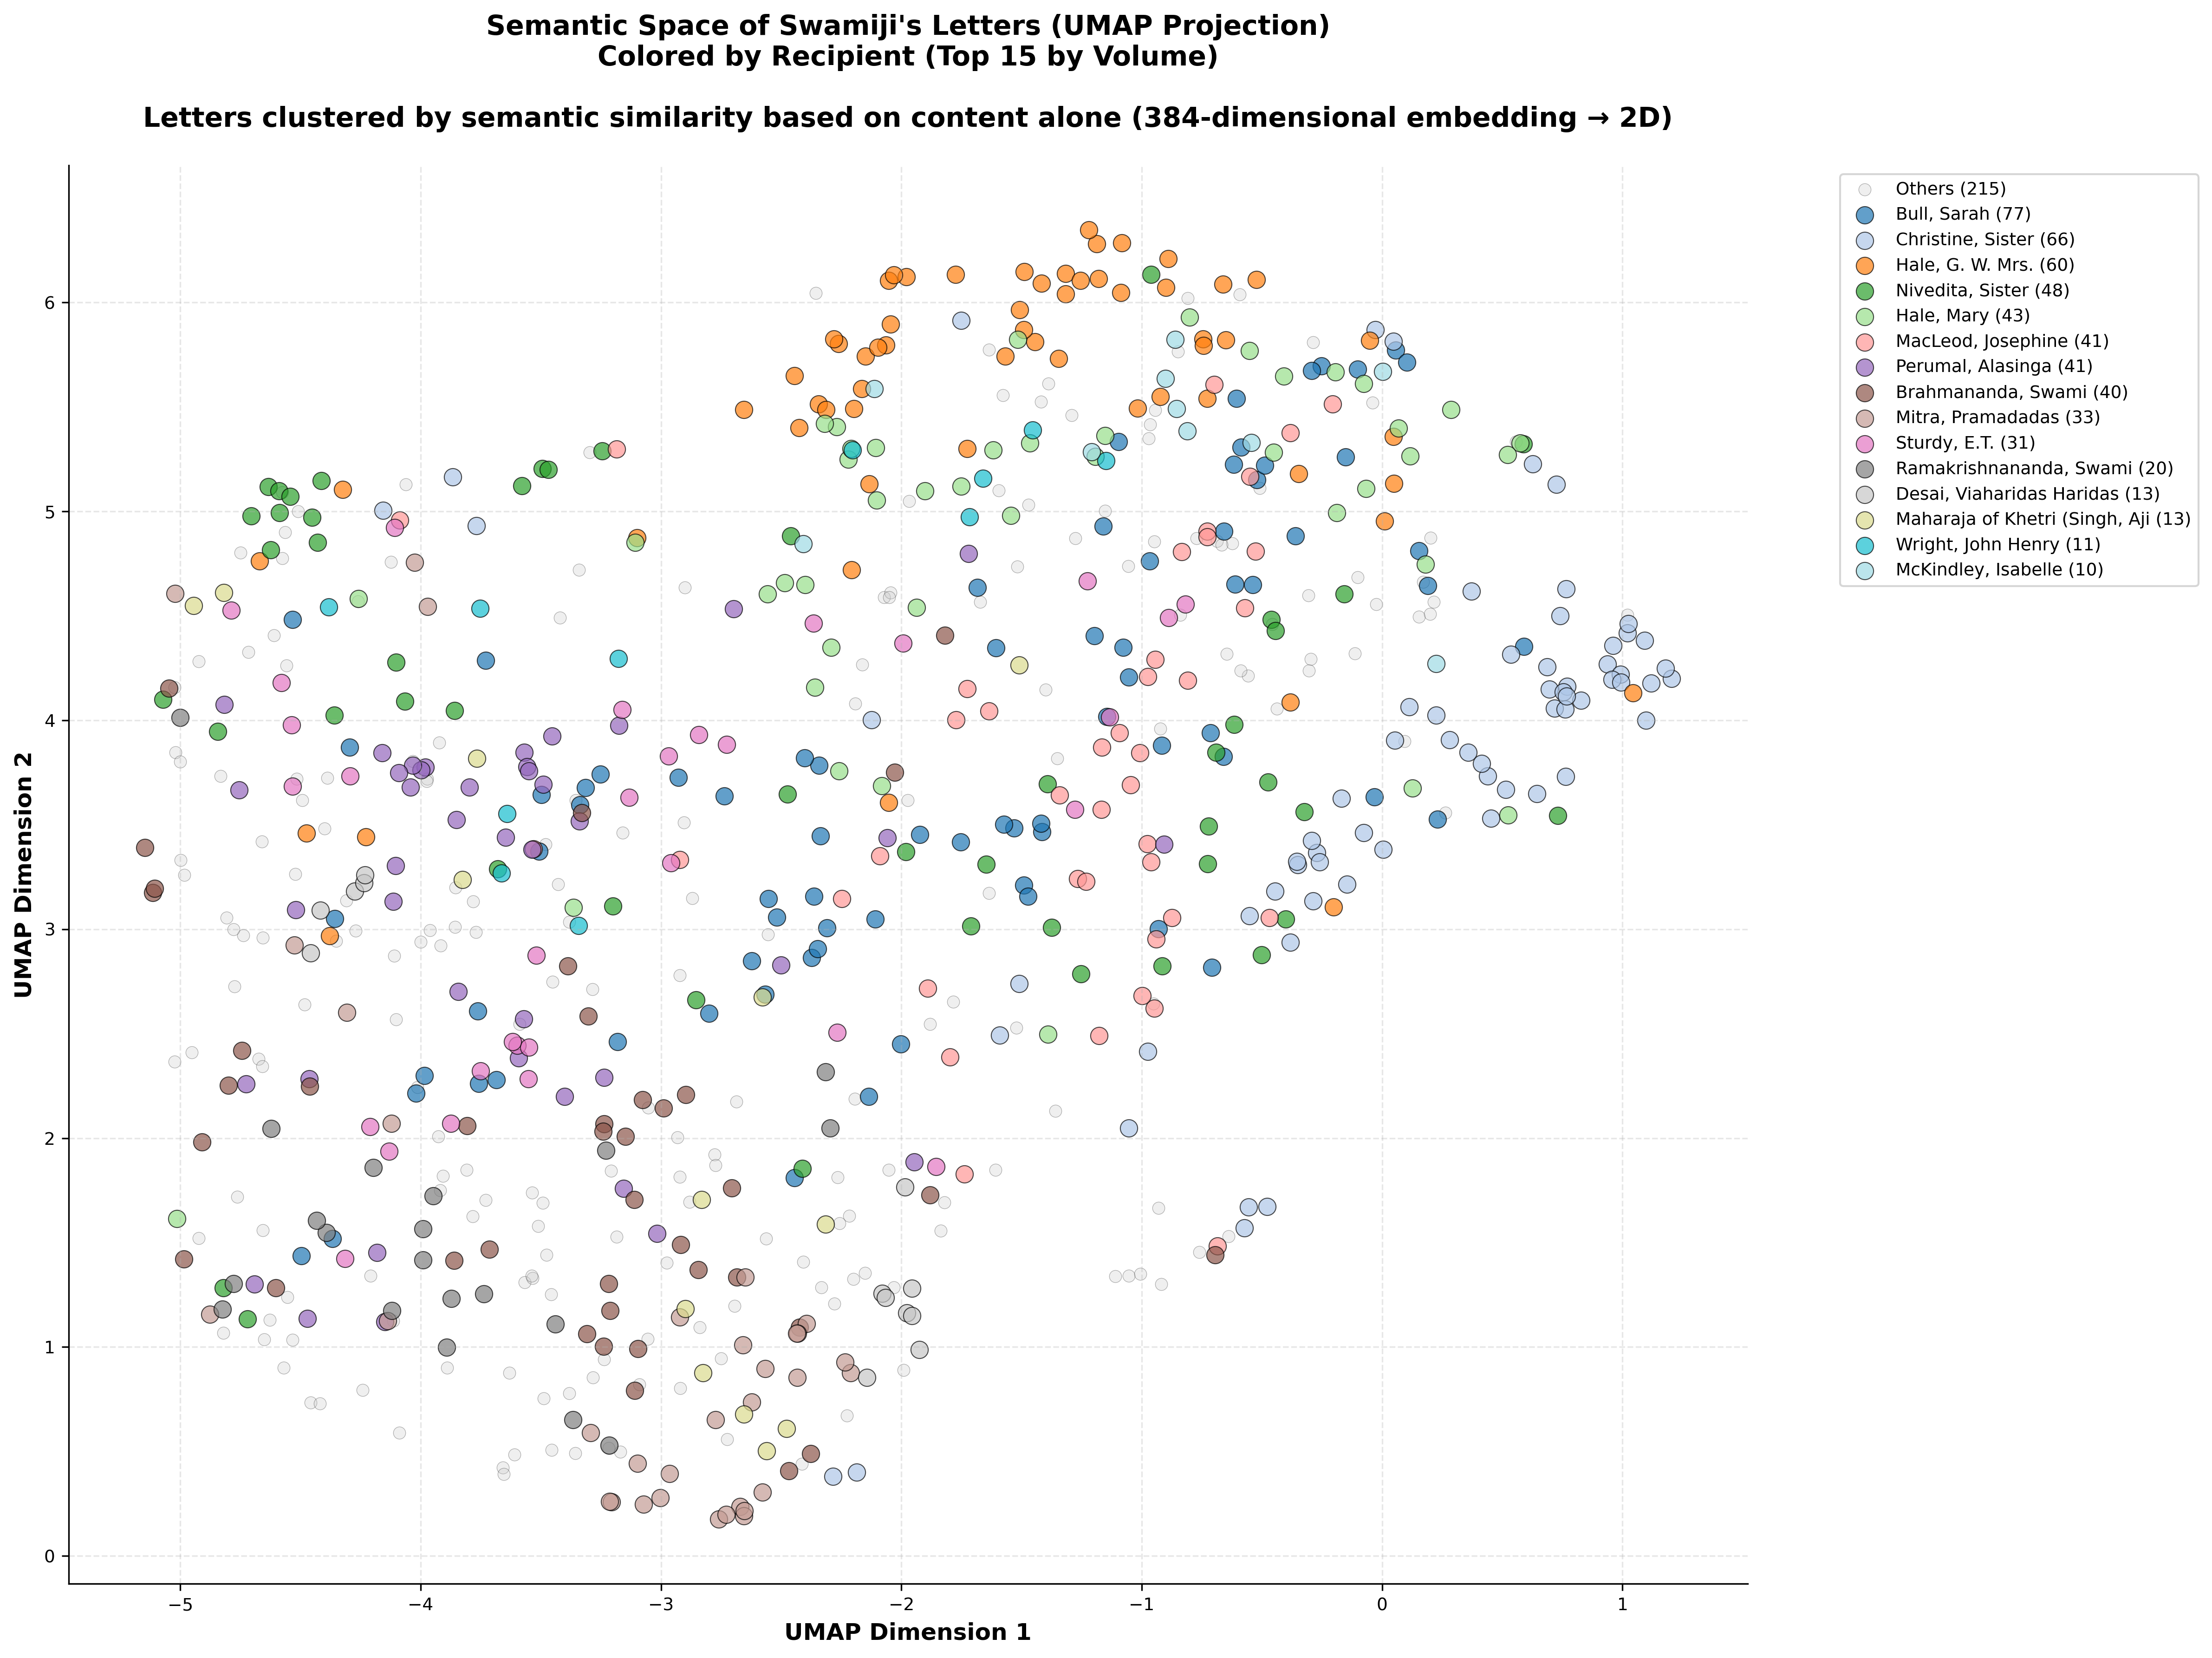

In [21]:
# ============================================================================
# VISUALIZATION 1: UMAP - COLORED BY RECIPIENT (TOP 15 + OTHERS)
# ============================================================================
print("\n[VISUALIZATION 1] UMAP - Colored by Recipient (Top 15 + Others)...")

fig, ax = plt.subplots(figsize=(16, 12))

# Get top 15 recipients by letter count
recipient_counts = viz_df['Recipient'].value_counts()
top_15_recipients = recipient_counts.head(15).index.tolist()

print(f"  Top 15 recipients by letter count:")
for i, (recipient, count) in enumerate(recipient_counts.head(15).items(), 1):
    print(f"    {i:2d}. {recipient}: {count} letters")

# Create a new column with "Others" for non-top-15
viz_df['Recipient_Display'] = viz_df['Recipient'].apply(
    lambda x: x if x in top_15_recipients else 'Others'
)

# Get unique recipients for display
unique_recipients_display = top_15_recipients + ['Others']

# Create color map
colors_recipients = plt.cm.tab20(np.linspace(0, 1, 15))
color_map = dict(zip(top_15_recipients, colors_recipients))
color_map['Others'] = '#CCCCCC'  # Gray for others

# Plot "Others" first (so they're in background)
others_mask = viz_df['Recipient_Display'] == 'Others'
if others_mask.sum() > 0:
    ax.scatter(viz_df[others_mask]['UMAP_1'], viz_df[others_mask]['UMAP_2'],
               label=f'Others ({others_mask.sum()})', alpha=0.3, s=40,
               color='#CCCCCC', edgecolors='black', linewidth=0.3)

# Plot top 15 recipients
for recipient in top_15_recipients:
    mask = viz_df['Recipient_Display'] == recipient
    count = mask.sum()
    ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
               label=f'{recipient[:30]} ({count})', alpha=0.7, s=80,
               color=color_map[recipient], edgecolors='black', linewidth=0.5)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space of Swamiji\'s Letters (UMAP Projection)\nColored by Recipient (Top 15 by Volume)\n\n' +
             'Letters clustered by semantic similarity based on content alone (384-dimensional embedding → 2D)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_recipient.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: embedding_umap_by_recipient.png")
plt.show()


[VISUALIZATION 1] UMAP - Colored by Recipient (Top 15 + Others)...
  Top 15 recipients by letter count:
     1. Bull, Sarah: 77 letters
     2. Christine, Sister: 66 letters
     3. Hale, G. W. Mrs.: 60 letters
     4. Nivedita, Sister: 48 letters
     5. Hale, Mary: 43 letters
     6. MacLeod, Josephine: 41 letters
     7. Perumal, Alasinga: 41 letters
     8. Brahmananda, Swami: 40 letters
     9. Mitra, Pramadadas: 33 letters
    10. Sturdy, E.T.: 31 letters
    11. Ramakrishnananda, Swami: 20 letters
    12. Desai, Viaharidas Haridas: 13 letters
    13. Maharaja of Khetri (Singh, Ajit): 13 letters
    14. Wright, John Henry: 11 letters
    15. McKindley, Isabelle: 10 letters

  Alphabetically sorted for color assignment:
     1. Brahmananda, Swami
     2. Bull, Sarah
     3. Christine, Sister
     4. Desai, Viaharidas Haridas
     5. Hale, G. W. Mrs.
     6. Hale, Mary
     7. MacLeod, Josephine
     8. Maharaja of Khetri (Singh, Ajit)
     9. McKindley, Isabelle
    10. Mitra, Pr

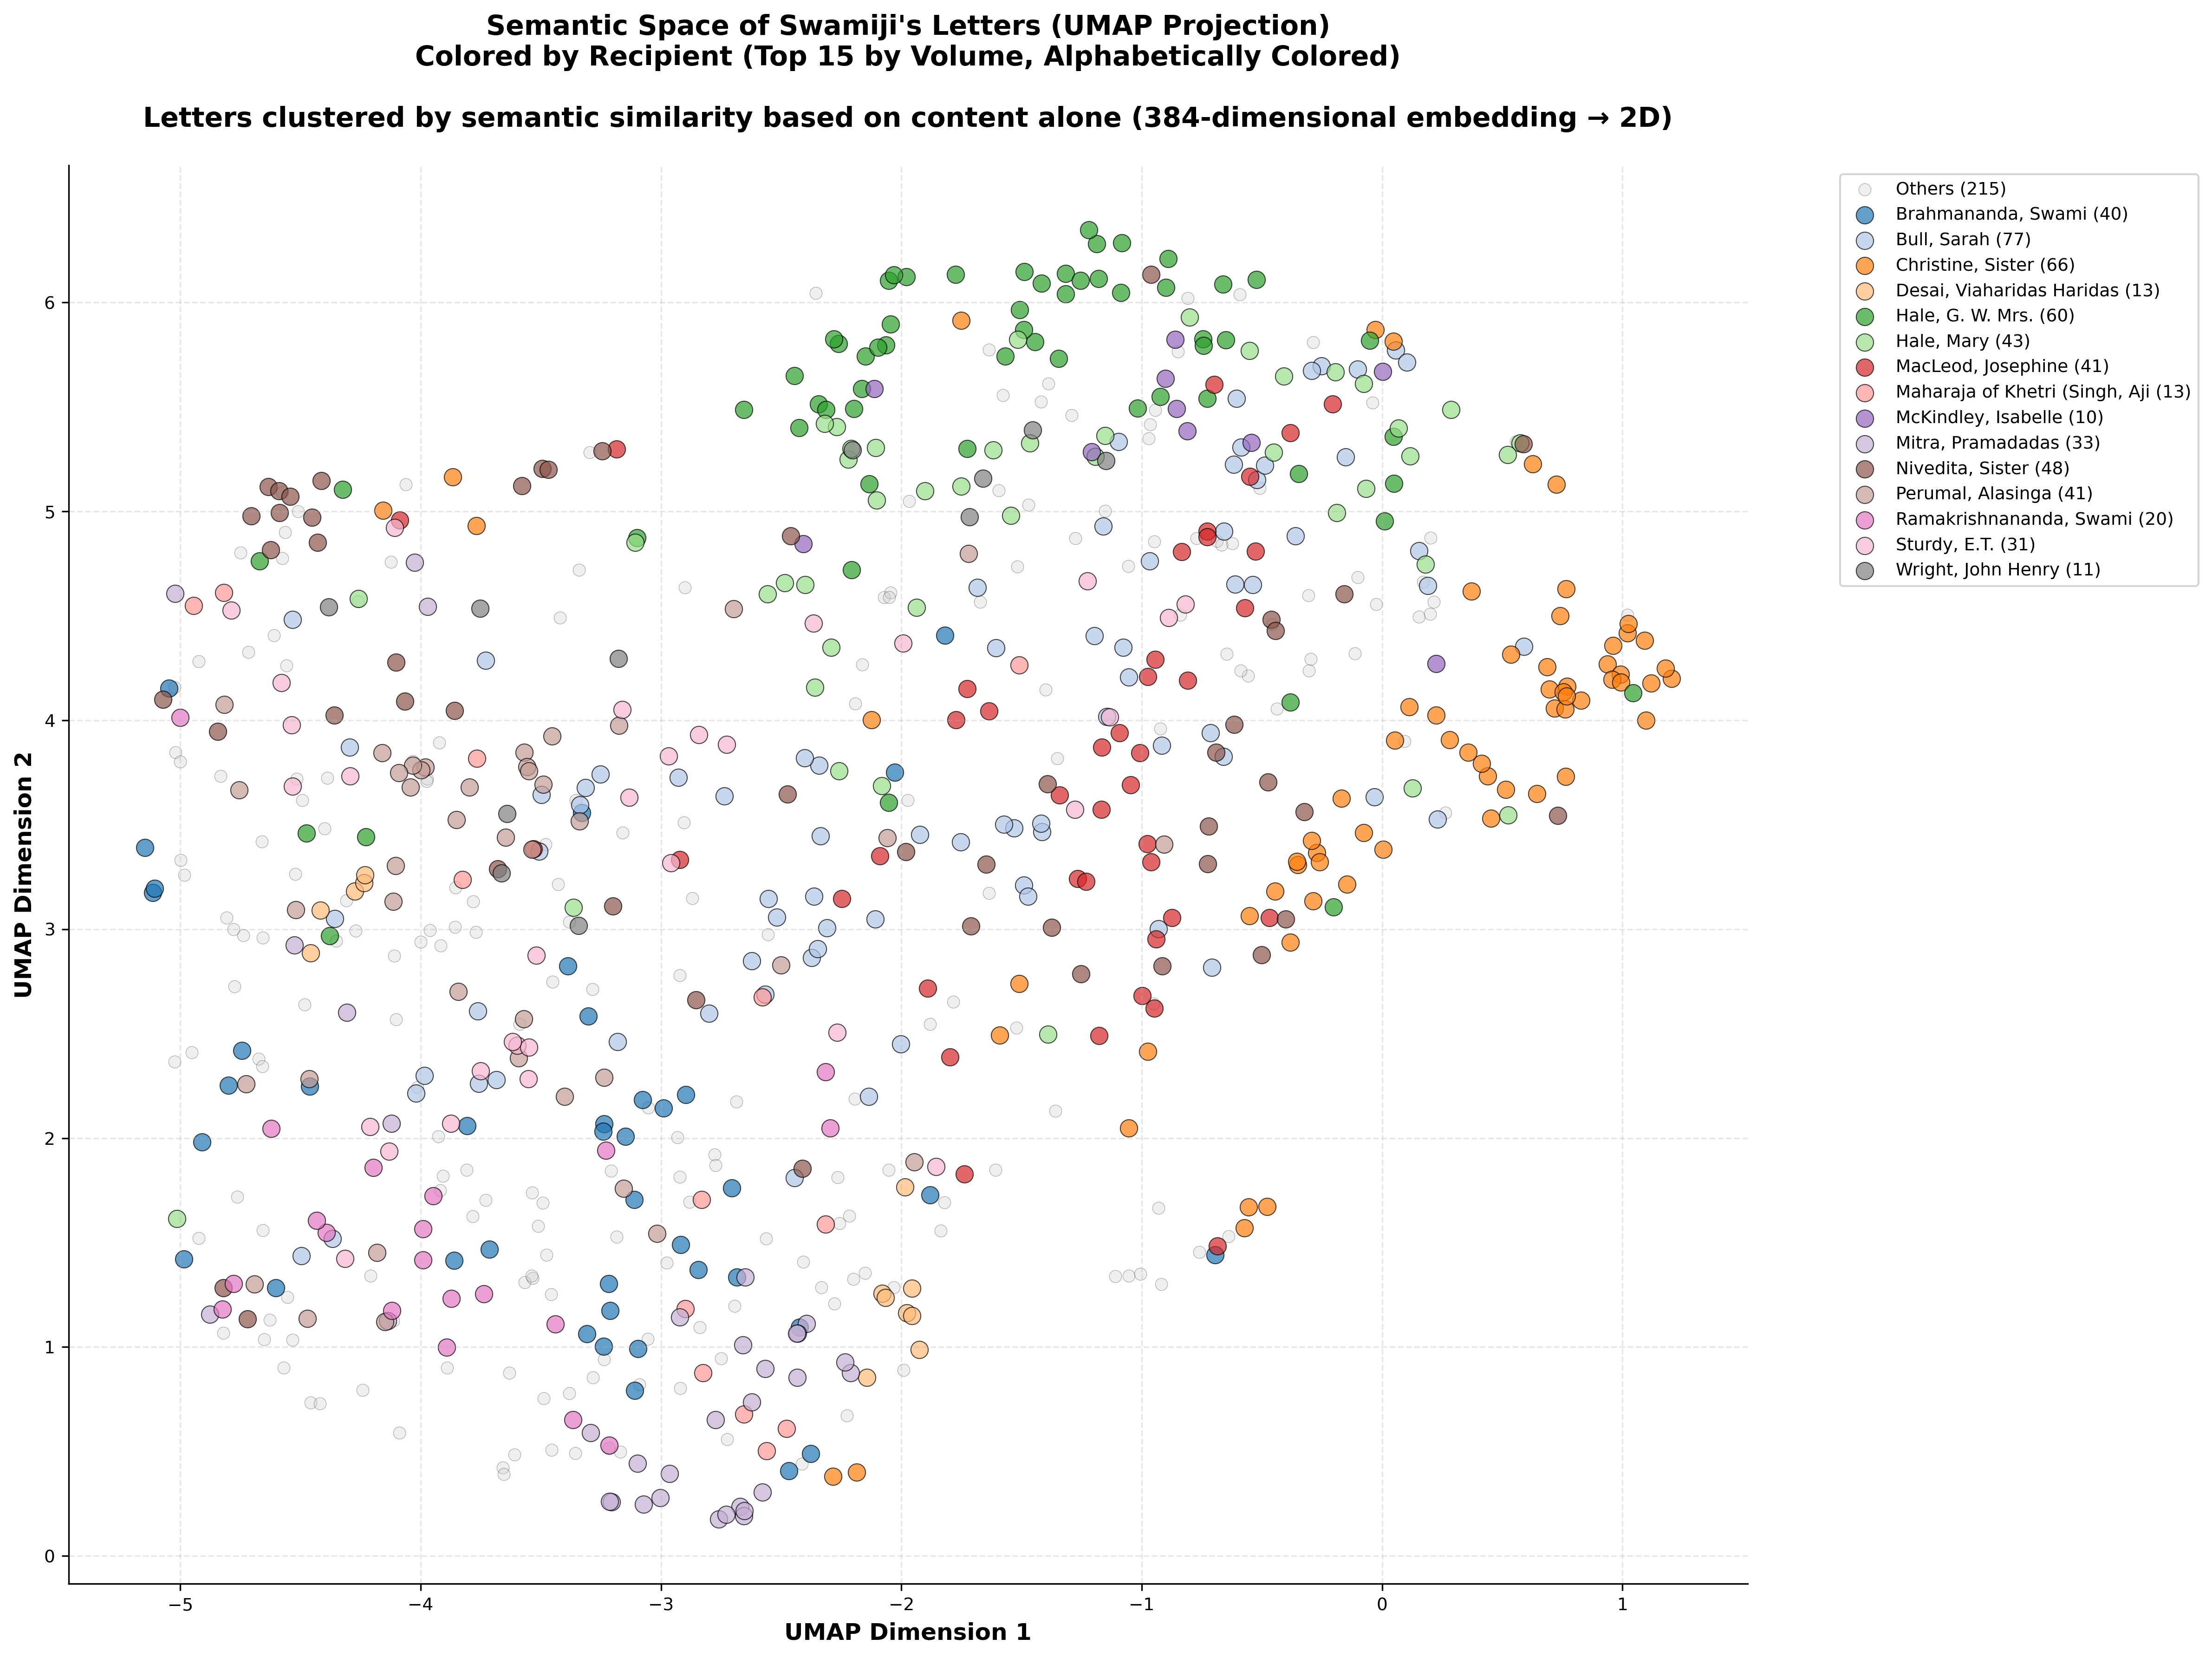

In [23]:
# ============================================================================
# VISUALIZATION 1: UMAP - COLORED BY RECIPIENT (TOP 15 + OTHERS)
# ============================================================================
print("\n[VISUALIZATION 1] UMAP - Colored by Recipient (Top 15 + Others)...")

fig, ax = plt.subplots(figsize=(16, 12))

# Get top 15 recipients by letter count
recipient_counts = viz_df['Recipient'].value_counts()
top_15_recipients = recipient_counts.head(15).index.tolist()

print(f"  Top 15 recipients by letter count:")
for i, (recipient, count) in enumerate(recipient_counts.head(15).items(), 1):
    print(f"    {i:2d}. {recipient}: {count} letters")

# Create a new column with "Others" for non-top-15
viz_df['Recipient_Display'] = viz_df['Recipient'].apply(
    lambda x: x if x in top_15_recipients else 'Others'
)

# Sort recipients alphabetically for color assignment
top_15_recipients_sorted = sorted(top_15_recipients)

print(f"\n  Alphabetically sorted for color assignment:")
for i, recipient in enumerate(top_15_recipients_sorted, 1):
    print(f"    {i:2d}. {recipient}")

# Create color map based on alphabetical order
# This will make similar names (like Hale, Hale) get similar colors
colors_recipients = plt.cm.tab20(np.linspace(0, 1, 20))
color_map = {}

for i, recipient in enumerate(top_15_recipients_sorted):
    color_map[recipient] = colors_recipients[i]

color_map['Others'] = '#CCCCCC'  # Gray for others

# Plot "Others" first (so they're in background)
others_mask = viz_df['Recipient_Display'] == 'Others'
if others_mask.sum() > 0:
    ax.scatter(viz_df[others_mask]['UMAP_1'], viz_df[others_mask]['UMAP_2'],
               label=f'Others ({others_mask.sum()})', alpha=0.3, s=40,
               color='#CCCCCC', edgecolors='black', linewidth=0.3)

# Plot top 15 recipients in alphabetical order for legend consistency
for recipient in top_15_recipients_sorted:
    mask = viz_df['Recipient_Display'] == recipient
    count = mask.sum()
    ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
               label=f'{recipient[:30]} ({count})', alpha=0.7, s=80,
               color=color_map[recipient], edgecolors='black', linewidth=0.5)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space of Swamiji\'s Letters (UMAP Projection)\nColored by Recipient (Top 15 by Volume, Alphabetically Colored)\n\n' +
             'Letters clustered by semantic similarity based on content alone (384-dimensional embedding → 2D)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_recipient.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: embedding_umap_by_recipient.png")
plt.show()


[VISUALIZATION] UMAP - Colored by Language...
  Language distribution (all):
    English: 604 letters
    Bengali: 148 letters
    Sanskrit: 3 letters
    French: 3 letters
     English: 1 letters

  Filtered to valid languages:
    English: 604 letters
    Bengali: 148 letters
    Sanskrit: 3 letters
    French: 3 letters

  Total letters plotted: 758 (excluded 4 NaN/other)

  ✓ Saved: embedding_umap_by_language.png


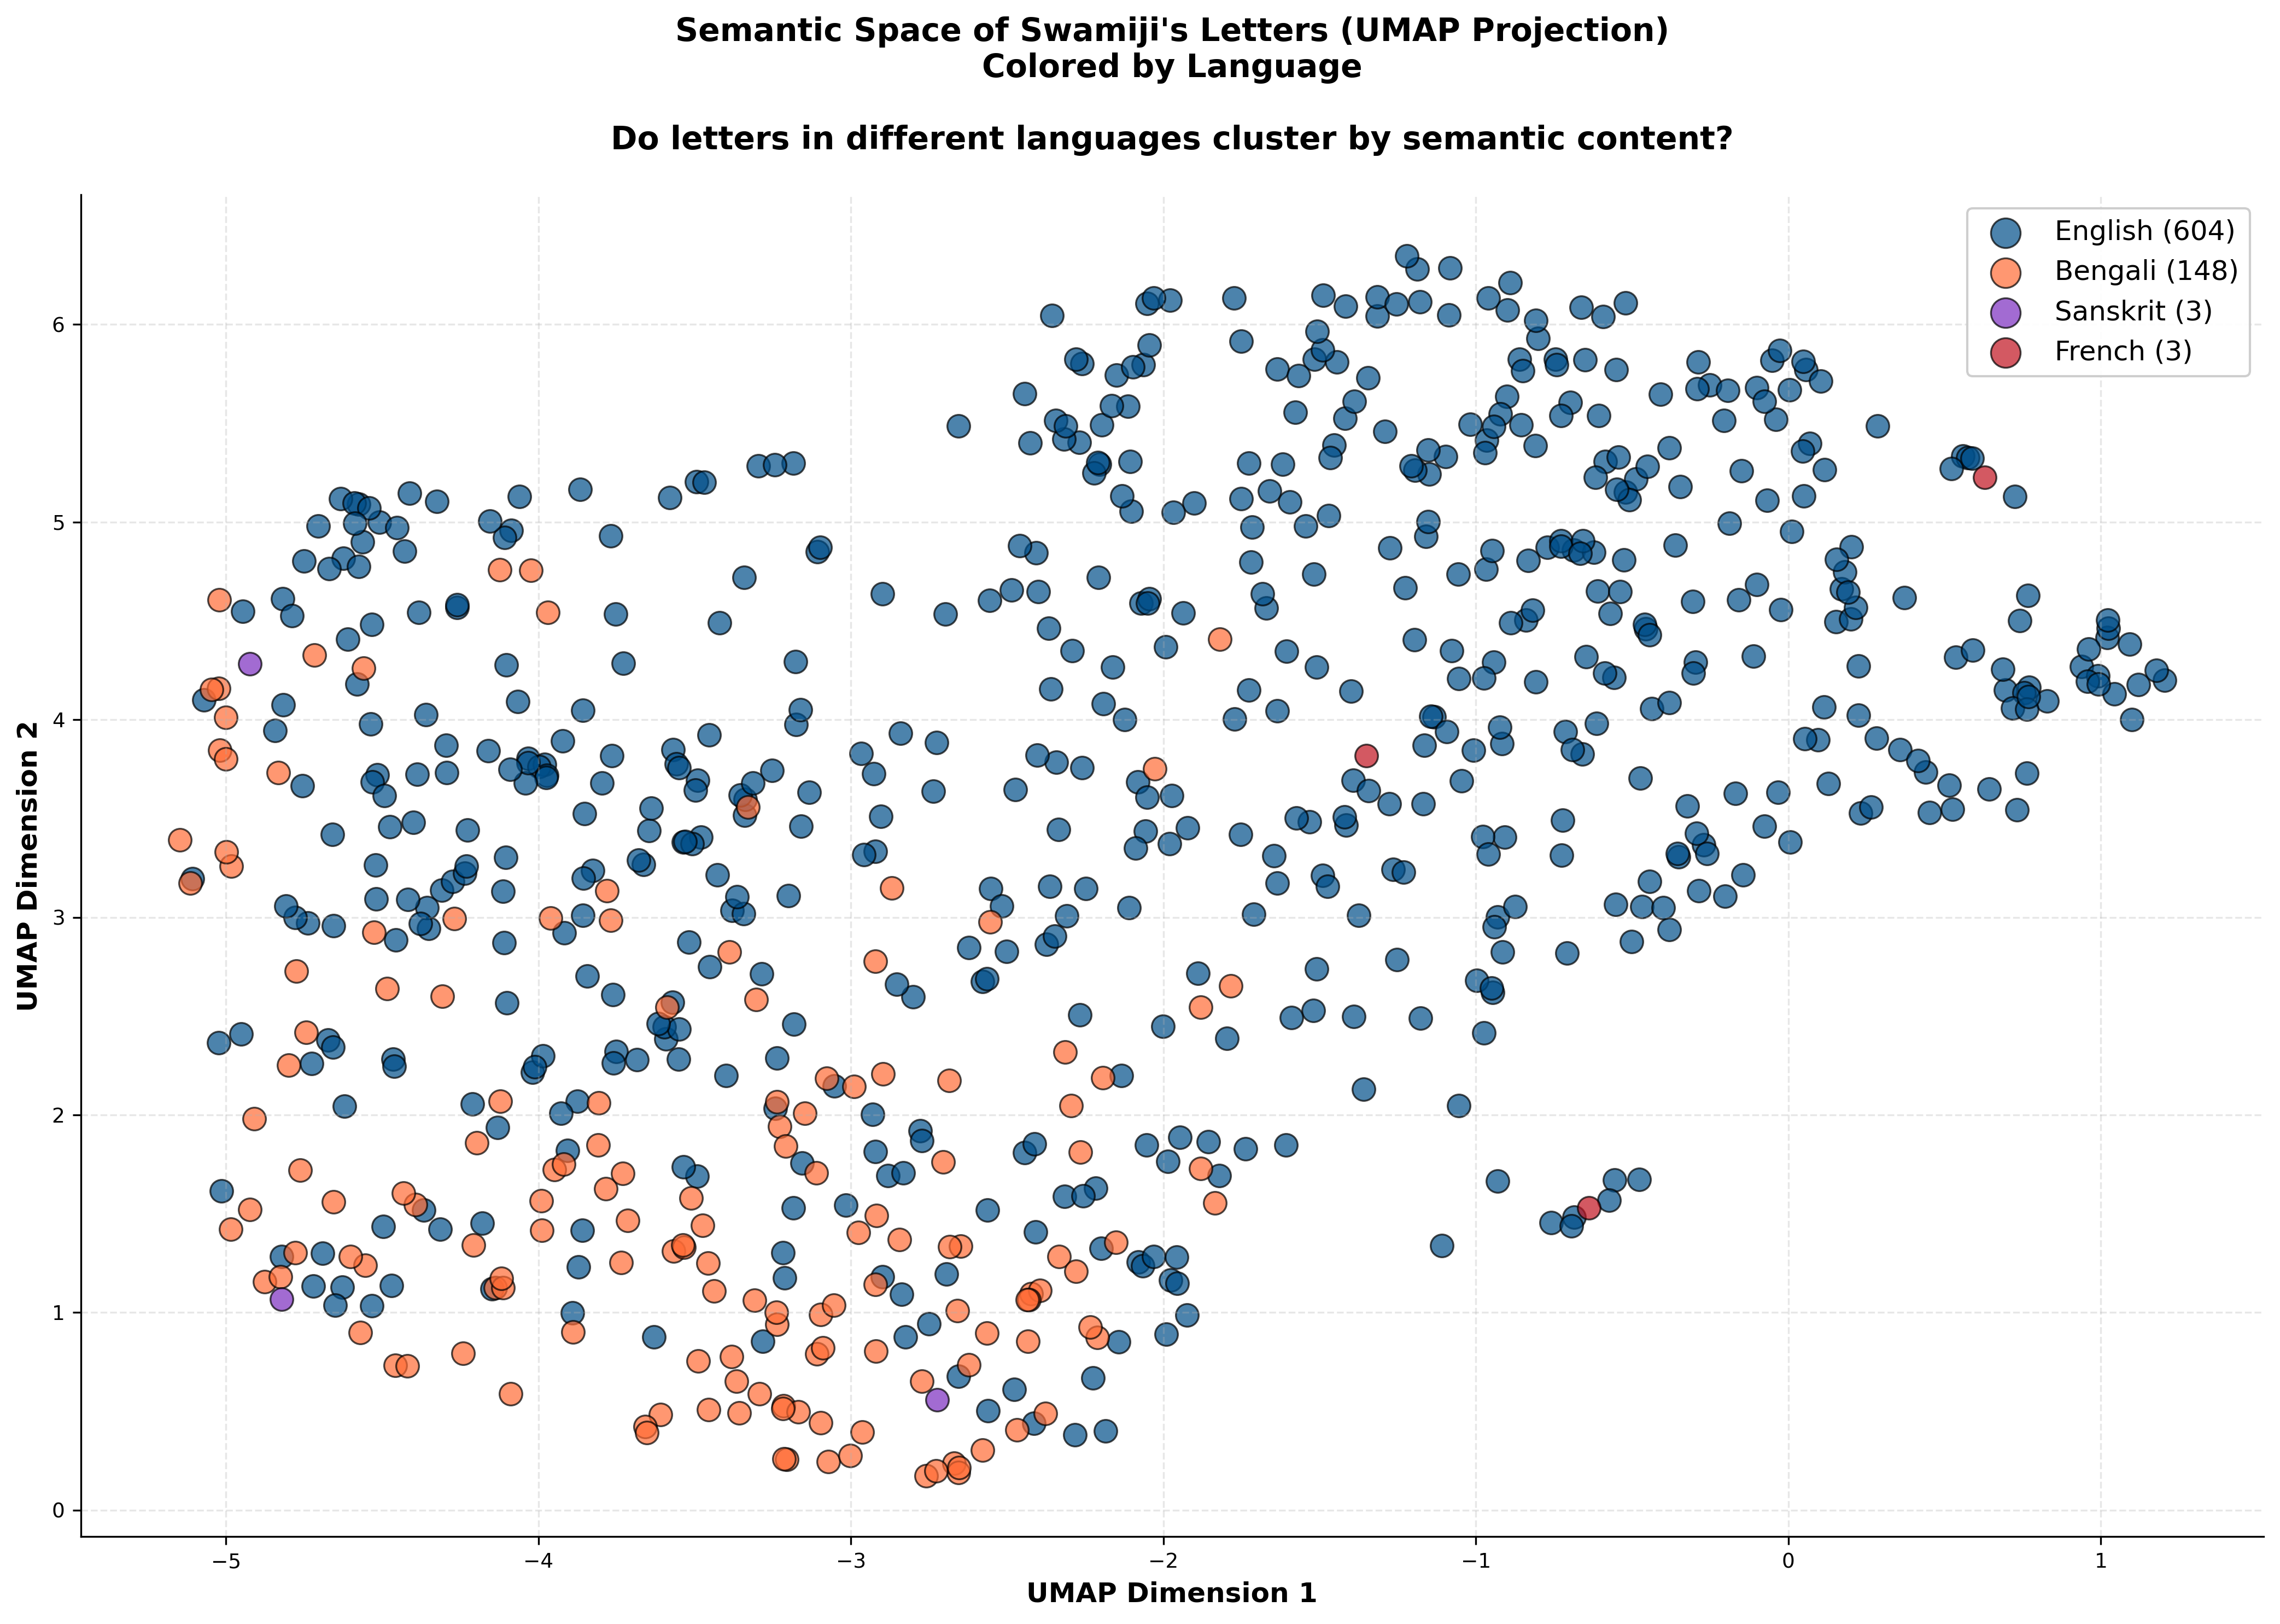


✓ Language-based visualization complete!


In [24]:
# ============================================================================
# VISUALIZATION: UMAP - COLORED BY LANGUAGE
# ============================================================================
print("\n[VISUALIZATION] UMAP - Colored by Language...")

# Get languages for the letters in our embedding dataset
languages = []
for letter_id in letter_ids:
    lang = all_letters.loc[letter_id, 'Language'] if letter_id in all_letters.index else None
    languages.append(lang)

# Add to viz_df
viz_df['Language'] = languages

print(f"  Language distribution (all):")
language_counts = pd.Series(languages).value_counts()
for lang, count in language_counts.items():
    print(f"    {lang}: {count} letters")

# Filter to only English, Bengali, Sanskrit, French (exclude NaN and others)
valid_languages = ['English', 'Bengali', 'Sanskrit', 'French']
language_mask = viz_df['Language'].isin(valid_languages)

viz_df_lang = viz_df[language_mask].copy()

print(f"\n  Filtered to valid languages:")
lang_counts_filtered = viz_df_lang['Language'].value_counts()
for lang, count in lang_counts_filtered.items():
    print(f"    {lang}: {count} letters")

print(f"\n  Total letters plotted: {len(viz_df_lang)} (excluded {len(viz_df) - len(viz_df_lang)} NaN/other)")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for languages
language_colors = {
    'English': '#004E89',     # Dark blue
    'Bengali': '#FF6B35',     # Orange/saffron
    'Sanskrit': '#7B2CBF',    # Purple
    'French': '#C1121F'       # Red
}

# Plot by language
for language in valid_languages:
    if language in viz_df_lang['Language'].values:
        mask = viz_df_lang['Language'] == language
        count = mask.sum()

        ax.scatter(viz_df_lang[mask]['UMAP_1'], viz_df_lang[mask]['UMAP_2'],
                   label=f'{language} ({count})', alpha=0.7, s=100,
                   color=language_colors[language], edgecolors='black', linewidth=0.8)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space of Swamiji\'s Letters (UMAP Projection)\nColored by Language\n\n' +
             'Do letters in different languages cluster by semantic content?',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best', framealpha=0.95, markerscale=1.3)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_language.png', bbox_inches='tight', dpi=300)
print("\n  ✓ Saved: embedding_umap_by_language.png")
plt.show()

print("\n" + "="*80)
print("✓ Language-based visualization complete!")
print("="*80)

In [18]:
df['Place'].unique()

array([nan, 'India, Allahabad', 'India, Bombay', 'Japan, Yokohama',
       'USA, Metcalf', 'USA, IL, Chicago', 'USA, NY, New York City',
       'USA', 'USA, MA, Annisquam', 'USA, MA, Boston',
       'USA, DC, Washington', 'USA, NY, Thousand Islands',
       'France, Paris', 'England, London', 'England', 'Switzerland',
       'Switzerland, Lucerne', 'England. London', 'India, Darjeeling',
       'India, Almora', 'India, Belur', 'India, Murree',
       'India, Dehra Dun', 'India, Kashmir', 'India, Lahore',
       'India, Deoghar', 'India, Calcutta (Alambazar)', 'USA, Ridgley',
       'India, Mayavati', 'India, Dacca', 'India, Varanasi',
       'India, Vrindaban', 'India, Baranagore', 'India, Auntpur',
       'India, Calcutta, Baghbazar', 'India, Baidyanath',
       'India, Ghazipur', 'India, Ajmer', 'India, Mt. Abu',
       'India, Khetri', 'USA, ME, Elliot, Greenacre Inn',
       'USA, NY, New York', 'USA, MD, Baltimore', 'USA, NH, Percy',
       'England, Reading, Caversham', 'R.M.S. B

In [22]:
# ============================================================================
# VISUALIZATION: UMAP - COLORED BY COUNTRY (EXTRACTED FROM PLACE)
# ============================================================================
print("\n[VISUALIZATION] UMAP - Colored by Country (extracted from Place field)...")

# Extract country from Place column
def extract_country(place):
    """Extract country from Place field (country is before first comma)"""
    if pd.isna(place) or place == '':
        return 'Unknown'

    place = str(place).strip()

    # Extract country (before first comma)
    if ',' in place:
        country = place.split(',')[0].strip()
    else:
        country = place.strip()

    # Standardize country names
    if country in ['India']:
        return 'India'
    elif country in ['USA']:
        return 'USA'
    elif country in ['England']:
        return 'England'
    elif country in ['France']:
        return 'France'
    elif country in ['Switzerland']:
        return 'Switzerland'
    elif country in ['Japan']:
        return 'Japan'
    elif country in ['Italy']:
        return 'Italy'
    elif country in ['Germany']:
        return 'Germany'
    elif country in ['Egypt']:
        return 'Egypt'
    elif country in ['Turkey']:
        return 'Turkey'
    elif country in ['Greece']:
        return 'Greece'
    elif country in ['Ceylon']:
        return 'Ceylon (Sri Lanka)'
    elif country in ['R.M.S. Britannic', 'RMS Britannic', 'Prinz-Regent Leopold -- On Board']:
        return 'At Sea'
    else:
        return 'Other'

# Get countries for the letters in our embedding dataset
countries = []
for letter_id in letter_ids:
    place = all_letters.loc[letter_id, 'Place'] if letter_id in all_letters.index else None
    countries.append(extract_country(place))

# Add to viz_df
viz_df['Country'] = countries

print(f"  Country distribution:")
country_counts = pd.Series(countries).value_counts()
for country, count in country_counts.items():
    print(f"    {country}: {count} letters")

# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Define colors for countries
country_colors = {
    'India': '#FF6B35',           # Saffron
    'USA': '#004E89',             # Dark blue
    'England': '#C1121F',         # Red
    'France': '#001D3D',          # Navy
    'Switzerland': '#DC143C',     # Crimson
    'Japan': '#E63946',           # Rose
    'Italy': '#06A77D',           # Green
    'Germany': '#F77F00',         # Orange
    'Egypt': '#D4A373',           # Sandy brown
    'Turkey': '#8B0000',          # Dark red
    'Greece': '#4169E1',          # Royal blue
    'Ceylon (Sri Lanka)': '#2E8B57', # Sea green
    'At Sea': '#1E3A8A',          # Deep blue
    'Other': '#6B7280',           # Gray
    'Unknown': '#CCCCCC'          # Light gray
}

# Get unique countries sorted by count
unique_countries = country_counts.index.tolist()

# Plot by country
for country in unique_countries:
    mask = viz_df['Country'] == country
    count = mask.sum()
    color = country_colors.get(country, '#999999')

    ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
               label=f'{country} ({count})', alpha=0.7, s=100,
               color=color, edgecolors='black', linewidth=0.8)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space of Swamiji\'s Letters (UMAP Projection)\nColored by Country Where Written\n\n' +
             'Do letters written in different countries cluster by semantic content?',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='best', framealpha=0.95, ncol=2)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_country.png', bbox_inches='tight', dpi=300)
print("\n  ✓ Saved: embedding_umap_by_country.png")
plt.show()

# ============================================================================
# BONUS: MAJOR COUNTRIES ONLY (India, USA, England, France, Switzerland)
# ============================================================================
print("\n[BONUS VISUALIZATION] Major Countries Only...")

major_countries = ['India', 'USA', 'England', 'France', 'Switzerland']
major_mask = viz_df['Country'].isin(major_countries)

fig, ax = plt.subplots(figsize=(14, 10))

for country in major_countries:
    mask = viz_df['Country'] == country
    count = mask.sum()
    color = country_colors[country]

    ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
               label=f'{country} ({count})', alpha=0.7, s=120,
               color=color, edgecolors='black', linewidth=1)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Semantic Space: Major Countries\n(India, USA, England, France, Switzerland)\n\n' +
             'Geographic influence on letter content',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best', framealpha=0.95, markerscale=1.3)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_umap_by_major_countries.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: embedding_umap_by_major_countries.png")
plt.show()

print("\n" + "="*80)
print("✓ Country-based visualizations complete!")
print("="*80)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
# ============================================================================
# DEBUG: FIND THE MYSTERY LETTER
# ============================================================================
print("="*80)
print("DEBUGGING: SEARCHING FOR MYSTERY LETTER")
print("="*80)

# Search 1: Look for "American Friend" in Audience column
print("\n[Search 1] Looking for 'American Friend' in Audience column...")
search1 = all_letters[all_letters['Audience'].str.contains('American', case=False, na=False)]
print(f"  Found {len(search1)} letters with 'American' in Audience")
print(f"  Unique audiences with 'American':")
for aud in search1['Audience'].unique():
    count = len(search1[search1['Audience'] == aud])
    print(f"    - '{aud}': {count} letters")

# Search 2: Look for "LXXIII" in Name column
print("\n[Search 2] Looking for 'LXXIII' in Name column...")
search2 = all_letters[all_letters['Name'].str.contains('LXXIII', case=False, na=False)]
print(f"  Found {len(search2)} letters with 'LXXIII' in Name")
if len(search2) > 0:
    for idx, row in search2.iterrows():
        print(f"    - Name: '{row['Name']}', Audience: '{row['Audience']}', Date: '{row['Date']}'")

# Search 3: Look for "Madam" in Name column
print("\n[Search 3] Looking for 'Madam' in Name column...")
search3 = all_letters[all_letters['Name'].str.contains('Madam', case=False, na=False)]
print(f"  Found {len(search3)} letters with 'Madam' in Name")
if len(search3) > 0:
    print(f"  First 10:")
    for idx, row in search3.head(10).iterrows():
        print(f"    - Name: '{row['Name']}', Audience: '{row['Audience']}', Date: '{row['Date']}'")

# Search 4: Look in 1886-1888 timeframe with unknown/ambiguous recipients
print("\n[Search 4] Looking for letters 1886-1888 with uncertain recipients...")
search4 = all_letters[
    (all_letters['year'] >= 1886) &
    (all_letters['year'] <= 1888)
]
print(f"  Found {len(search4)} letters from 1886-1888")

# Check for recipients with "Friend" or similar
friend_search = search4[search4['Audience'].str.contains('Friend|Unknown|friend', case=False, na=False)]
print(f"\n  Letters to 'Friend' or 'Unknown' recipients:")
if len(friend_search) > 0:
    for idx, row in friend_search.iterrows():
        print(f"    - Name: '{row['Name']}', Audience: '{row['Audience']}', Date: '{row['Date']}', Place: '{row['Place']}'")

# Search 5: Exact string search
print("\n[Search 5] Exact matches...")
exact1 = all_letters[all_letters['Audience'] == 'American Friend']
print(f"  Exact match 'American Friend': {len(exact1)} letters")

exact2 = all_letters[all_letters['Name'] == 'LXXIII Madam']
print(f"  Exact match 'LXXIII Madam': {len(exact2)} letters")

# Search 6: Case-insensitive partial matches
print("\n[Search 6] Case-insensitive partial matches...")
partial = all_letters[
    all_letters['Audience'].str.lower().str.contains('american', na=False) |
    all_letters['Name'].str.lower().str.contains('lxxiii', na=False)
]
print(f"  Found {len(partial)} letters")
if len(partial) > 0:
    print(f"  Showing all matches:")
    for idx, row in partial.iterrows():
        print(f"    Index: {idx}, Name: '{row['Name']}', Audience: '{row['Audience']}', Date: '{row['Date']}'")

print("\n" + "="*80)

DEBUGGING: SEARCHING FOR MYSTERY LETTER

[Search 1] Looking for 'American Friend' in Audience column...
  Found 3 letters with 'American' in Audience
  Unique audiences with 'American':
    - 'American Lady': 1 letters
    - 'Friend, American': 2 letters

[Search 2] Looking for 'LXXIII' in Name column...
  Found 6 letters with 'LXXIII' in Name
    - Name: 'LXXIII Madam', Audience: 'American Lady', Date: '1896/12/13'
    - Name: 'LXXIII Brother Disciples', Audience: 'Brother Disciples, Swami', Date: '1895/07/08C'
    - Name: 'LXXIII Sisters', Audience: 'Hale, Sisters', Date: '1896/04/14'
    - Name: 'CLXXIII Dhira Mata', Audience: 'Bull, Sarah', Date: '1900/04/08'
    - Name: 'LXXIII Christina', Audience: 'Christine, Sister', Date: '1895/12/08'
    - Name: 'CLXXIII Christina', Audience: 'Christine, Sister', Date: '1900/06/15'

[Search 3] Looking for 'Madam' in Name column...
  Found 3 letters with 'Madam' in Name
  First 10:
    - Name: 'LXXIII Madam', Audience: 'American Lady', Date: '

MYSTERY LETTER INVESTIGATION: 'LXXIII Madam' to 'American Lady'

[STEP 1] Locating the mystery letter...
  ✓ Found mystery letter!
    Index: 73
    Name: LXXIII Madam
    Audience: American Lady
    Date: 1896/12/13
    Place: England, London
    Language: English
    Year: 1896.0
  ✓ Letter IS in embedding dataset (position 73)

  Letter content preview:
  DEAR MADAM, (An American lady.)

We have only to grasp the idea of gradation of morality and everything becomes clear.

Renunciation — non-resistance — non-destructiveness — are the ideals to be attained through less and less worldliness, less and less resistance, less and less destructiveness. Keep the ideal in view and work towards it. None can live in the world without resistance, without destruction, without desire. The world has not come to that state yet when the ideal can be realised in s...

[STEP 2] Identifying candidate recipients (American women)...
  Known American women recipients: 11
  ✓ Candidate letters (American wo

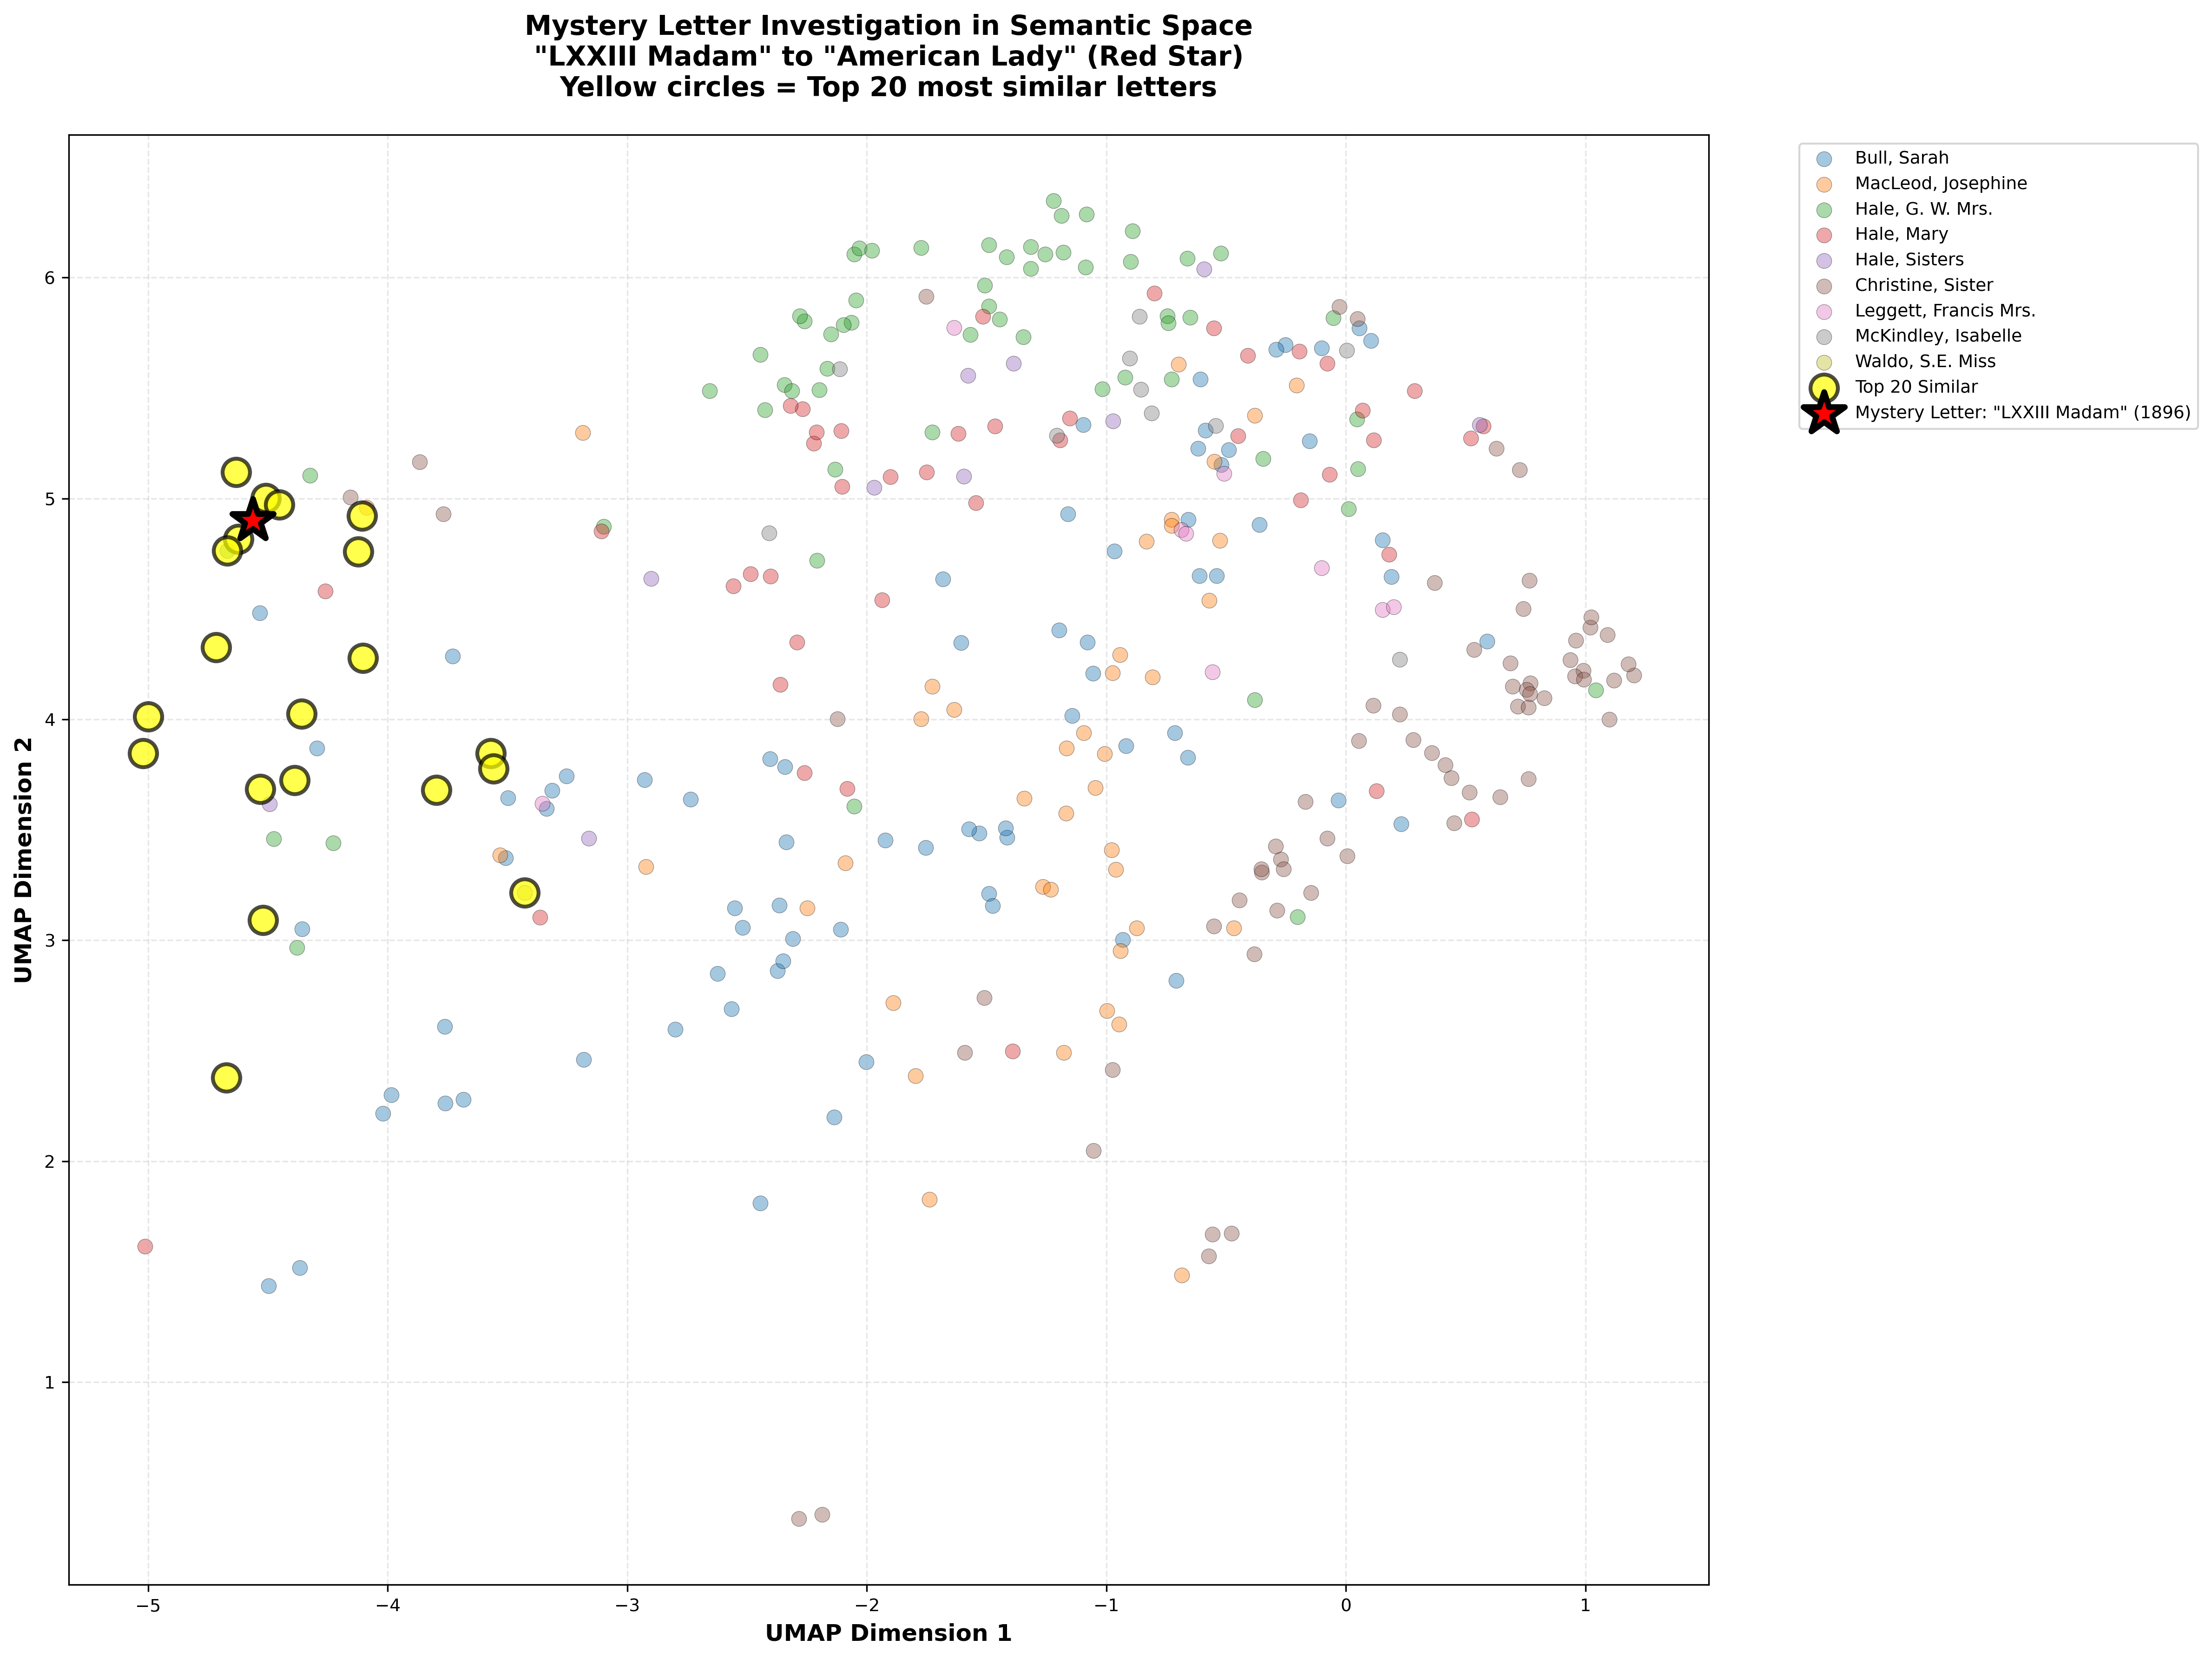


CONCLUSION

🔍 INVESTIGATION SUMMARY:
  Mystery Letter: LXXIII Madam to 'American Lady'
  Date: 1896/12/13 (December 1896)
  Place: England, London

📊 TOP CANDIDATES (by semantic similarity):
  Overall top recipients in similar letters:
    1. Nivedita, Sister: appears in 5/20 top similar letters
    2. Perumal, Alasinga: appears in 4/20 top similar letters
    3. Sturdy, E.T.: appears in 2/20 top similar letters
    4. Farmer, S Miss: appears in 1/20 top similar letters
    5. Ghoshal, Sarala: appears in 1/20 top similar letters

🎯 AMERICAN WOMEN specifically:
    1. Bull, Sarah: appears in 11/30 top similar American women letters
    2. Hale, Mary: appears in 6/30 top similar American women letters
    3. Hale, G. W. Mrs.: appears in 5/30 top similar American women letters
    4. Christine, Sister: appears in 2/30 top similar American women letters
    5. MacLeod, Josephine: appears in 2/30 top similar American women letters

✨ STRONGEST MATCH (American women + 1895-1897 timeframe):


In [31]:
# ============================================================================
# MYSTERY LETTER INVESTIGATION: "LXXIII Madam" to "American Lady"
# Using semantic embeddings to find similar letters and potential recipient identity
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MYSTERY LETTER INVESTIGATION: 'LXXIII Madam' to 'American Lady'")
print("="*80)

# ============================================================================
# STEP 1: LOCATE THE MYSTERY LETTER
# ============================================================================
print("\n[STEP 1] Locating the mystery letter...")

# Find the letter - Index 73, dated 1896/12/13
mystery_idx = 73
mystery_letter = all_letters.loc[mystery_idx]

print(f"  ✓ Found mystery letter!")
print(f"    Index: {mystery_idx}")
print(f"    Name: {mystery_letter['Name']}")
print(f"    Audience: {mystery_letter['Audience']}")
print(f"    Date: {mystery_letter['Date']}")
print(f"    Place: {mystery_letter['Place']}")
print(f"    Language: {mystery_letter['Language']}")
print(f"    Year: {mystery_letter['year']}")

# Check if it's in our embedding dataset
if mystery_idx in letter_ids:
    mystery_position = letter_ids.index(mystery_idx)
    mystery_embedding = embeddings[mystery_position]
    print(f"  ✓ Letter IS in embedding dataset (position {mystery_position})")
else:
    print(f"  ✗ Letter NOT in embedding dataset")
    print(f"  Need to embed it separately...")

    # Embed the mystery letter
    mystery_text = mystery_letter['body_text']
    mystery_embedding = model.encode([mystery_text])[0]
    print(f"  ✓ Generated embedding for mystery letter")

# Show a preview of the letter content
print(f"\n  Letter content preview:")
print(f"  {mystery_letter['body_text'][:500]}...")

# ============================================================================
# STEP 2: IDENTIFY CANDIDATE RECIPIENTS (AMERICAN WOMEN)
# ============================================================================
print("\n" + "="*80)
print("[STEP 2] Identifying candidate recipients (American women)...")
print("="*80)

# Define American female recipients (known from historical records)
american_women = [
    'Bull, Sarah',
    'MacLeod, Josephine',
    'Hale, G. W. Mrs.',
    'Hale, Mary',
    'Hale, Sisters',
    'Christine, Sister',
    'Leggett, Francis Mrs.',
    'McKindley, Isabelle',
    'Funke, Mary Mrs.',
    'Waldo, S.E. Miss',
    'Greenstidel, Madame',
]

print(f"  Known American women recipients: {len(american_women)}")

# Since the mystery letter is from 1896 (not 1886), let's expand the timeframe
# Look at 1895-1897 (around the date)
candidate_letters = all_letters[
    (all_letters['Audience_clean'].isin(american_women)) &
    (all_letters['year'] >= 1895) & (all_letters['year'] <= 1897) &
    (all_letters['Language'] == 'English')
].copy()

print(f"  ✓ Candidate letters (American women, 1895-1897, English): {len(candidate_letters)}")

if len(candidate_letters) > 0:
    print(f"\n  Candidate recipients breakdown:")
    for recipient, count in candidate_letters['Audience_clean'].value_counts().items():
        print(f"    - {recipient}: {count} letters")

# ============================================================================
# STEP 3: FIND SEMANTICALLY SIMILAR LETTERS (ALL LETTERS)
# ============================================================================
print("\n" + "="*80)
print("[STEP 3] Finding semantically similar letters...")
print("="*80)

# Calculate cosine similarity between mystery letter and ALL other letters
mystery_embedding_reshaped = mystery_embedding.reshape(1, -1)
similarities = cosine_similarity(mystery_embedding_reshaped, embeddings)[0]

# Create dataframe with similarities
similarity_df = pd.DataFrame({
    'letter_id': letter_ids,
    'similarity': similarities,
    'recipient': recipients,
    'date': dates,
    'period': periods
})

# Add metadata from all_letters
similarity_df['place'] = similarity_df['letter_id'].apply(
    lambda x: all_letters.loc[x, 'Place'] if x in all_letters.index else None
)
similarity_df['language'] = similarity_df['letter_id'].apply(
    lambda x: all_letters.loc[x, 'Language'] if x in all_letters.index else None
)
similarity_df['year'] = similarity_df['letter_id'].apply(
    lambda x: all_letters.loc[x, 'year'] if x in all_letters.index else None
)
similarity_df['name'] = similarity_df['letter_id'].apply(
    lambda x: all_letters.loc[x, 'Name'] if x in all_letters.index else None
)

# Exclude the mystery letter itself
similarity_df = similarity_df[similarity_df['letter_id'] != mystery_idx].copy()

# Sort by similarity
similarity_df = similarity_df.sort_values('similarity', ascending=False)

print(f"  ✓ Calculated similarities for {len(similarity_df)} letters")
print(f"\n  Top 20 most semantically similar letters:")
print("="*100)

for i, row in enumerate(similarity_df.head(20).itertuples(), 1):
    print(f"  {i:2d}. Sim: {row.similarity:.4f} | {row.name[:25]:25s} | "
      f"To: {row.recipient[:28]:28s} | Year: {int(row.year) if pd.notna(row.year) else 'N/A'}")

# ============================================================================
# STEP 4: ANALYZE TOP SIMILAR LETTERS - RECIPIENT PATTERNS
# ============================================================================
print("\n" + "="*80)
print("[STEP 4] Analyzing recipient patterns in top similar letters...")
print("="*80)

# Top 20 similar letters
top_20_similar = similarity_df.head(20)

print(f"\n  Recipient frequency in top 20 similar letters:")
recipient_freq = top_20_similar['recipient'].value_counts()
for recipient, count in recipient_freq.items():
    percentage = (count / 20) * 100
    print(f"    {recipient[:40]:40s}: {count:2d} letters ({percentage:5.1f}%)")

# Top 50 for broader pattern
top_50_similar = similarity_df.head(50)
print(f"\n  Recipient frequency in top 50 similar letters:")
recipient_freq_50 = top_50_similar['recipient'].value_counts().head(10)
for recipient, count in recipient_freq_50.items():
    percentage = (count / 50) * 100
    print(f"    {recipient[:40]:40s}: {count:2d} letters ({percentage:5.1f}%)")

# ============================================================================
# STEP 5: FILTER TO AMERICAN WOMEN ONLY
# ============================================================================
print("\n" + "="*80)
print("[STEP 5] Filtering to American women recipients only...")
print("="*80)

american_women_similar = similarity_df[
    similarity_df['recipient'].isin(american_women)
].head(30)

print(f"\n  Top 30 similar letters to AMERICAN WOMEN:")
print("="*100)

for i, row in enumerate(american_women_similar.itertuples(), 1):
    print(f"  {i:2d}. Sim: {row.similarity:.4f} | {row.name[:25]:25s} | "
      f"To: {row.recipient[:28]:28s} | Year: {int(row.year) if pd.notna(row.year) else 'N/A'}")

print(f"\n  Recipient frequency (American women only, top 30):")
american_recipient_freq = american_women_similar['recipient'].value_counts()
for recipient, count in american_recipient_freq.items():
    percentage = (count / 30) * 100
    print(f"    {recipient[:40]:40s}: {count:2d} letters ({percentage:5.1f}%)")

# ============================================================================
# STEP 6: TEMPORAL CONTEXT (1895-1897)
# ============================================================================
print("\n" + "="*80)
print("[STEP 6] Temporal context analysis (1895-1897)...")
print("="*80)

# Filter to 1895-1897 timeframe (around mystery letter date)
temporal_similar = similarity_df[
    (similarity_df['year'] >= 1895) & (similarity_df['year'] <= 1897)
].head(30)

print(f"\n  Top 30 similar letters from 1895-1897:")
temporal_recipient_freq = temporal_similar['recipient'].value_counts().head(10)
for recipient, count in temporal_recipient_freq.items():
    print(f"    {recipient[:40]:40s}: {count:2d} letters")

# Combined filter: American women + 1895-1897
combined_filter = similarity_df[
    (similarity_df['recipient'].isin(american_women)) &
    (similarity_df['year'] >= 1895) & (similarity_df['year'] <= 1897)
].head(20)

print(f"\n  Top 20 similar letters: American women + 1895-1897:")
print("="*100)

if len(combined_filter) > 0:
    for i, row in enumerate(combined_filter.itertuples(), 1):
        print(f"  {i:2d}. Sim: {row.similarity:.4f} | {row.name[:20]:20s} | "
              f"To: {row.recipient[:25]:25s} | Year: {int(row.year):4d}")

    print(f"\n  STRONGEST CANDIDATES (matching temporal criteria):")
    combined_recipient_freq = combined_filter['recipient'].value_counts()
    for recipient, count in combined_recipient_freq.items():
        percentage = (count / len(combined_filter)) * 100
        print(f"    {recipient[:40]:40s}: {count:2d} letters ({percentage:5.1f}%)")
else:
    print("  No letters match criteria")

# ============================================================================
# STEP 7: EXAMINE TOP 5 MOST SIMILAR LETTERS
# ============================================================================
print("\n" + "="*80)
print("[STEP 7] Examining content of top 5 most similar letters...")
print("="*80)

for i, row in enumerate(similarity_df.head(5).itertuples(), 1):
    letter_id = row.letter_id
    letter_body = all_letters.loc[letter_id, 'body_text'] if letter_id in all_letters.index else ""

    print(f"\n{i}. Letter: {row.name}")
    print(f"   To: {row.recipient}")
    print(f"   Similarity: {row.similarity:.4f}")
    print(f"   Year: {int(row.year) if pd.notna(row.year) else 'N/A'}")
    print(f"   Place: {row.place}")
    print(f"   Content preview: {letter_body[:350]}...")
    print("-"*80)

# ============================================================================
# STEP 8: VISUALIZE MYSTERY LETTER IN UMAP SPACE
# ============================================================================
print("\n" + "="*80)
print("[STEP 8] Visualizing mystery letter in UMAP space...")
print("="*80)

# Get UMAP coordinates for mystery letter
if mystery_idx in viz_df['Letter_ID'].values:
    mystery_umap_x = viz_df[viz_df['Letter_ID'] == mystery_idx]['UMAP_1'].values[0]
    mystery_umap_y = viz_df[viz_df['Letter_ID'] == mystery_idx]['UMAP_2'].values[0]
else:
    # If not in viz_df, need to transform the embedding
    mystery_umap_coords = reducer_umap.transform(mystery_embedding.reshape(1, -1))
    mystery_umap_x = mystery_umap_coords[0, 0]
    mystery_umap_y = mystery_umap_coords[0, 1]

# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Plot all American women letters in muted colors
for woman in american_women:
    mask = viz_df['Recipient'] == woman
    if mask.sum() > 0:
        ax.scatter(viz_df[mask]['UMAP_1'], viz_df[mask]['UMAP_2'],
                   label=woman, alpha=0.4, s=60, edgecolors='black', linewidth=0.3)

# Highlight top 20 similar letters
top_20_ids = similarity_df.head(20)['letter_id'].tolist()
top_20_mask = viz_df['Letter_ID'].isin(top_20_ids)
ax.scatter(viz_df[top_20_mask]['UMAP_1'], viz_df[top_20_mask]['UMAP_2'],
           color='yellow', s=200, marker='o', edgecolors='black', linewidth=2,
           alpha=0.7, label='Top 20 Similar', zorder=10)

# Plot mystery letter as a star
ax.scatter(mystery_umap_x, mystery_umap_y,
           color='red', s=500, marker='*', edgecolors='black', linewidth=3,
           label='Mystery Letter: "LXXIII Madam" (1896)', zorder=15)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Mystery Letter Investigation in Semantic Space\n"LXXIII Madam" to "American Lady" (Red Star)\nYellow circles = Top 20 most similar letters',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('mystery_letter_investigation.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: mystery_letter_investigation.png")
plt.show()

# ============================================================================
# FINAL CONCLUSION
# ============================================================================
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

print("\n🔍 INVESTIGATION SUMMARY:")
print(f"  Mystery Letter: {mystery_letter['Name']} to 'American Lady'")
print(f"  Date: {mystery_letter['Date']} (December 1896)")
print(f"  Place: {mystery_letter['Place']}")

print("\n📊 TOP CANDIDATES (by semantic similarity):")
print("  Overall top recipients in similar letters:")
for i, (recipient, count) in enumerate(recipient_freq.head(5).items(), 1):
    print(f"    {i}. {recipient}: appears in {count}/20 top similar letters")

print("\n🎯 AMERICAN WOMEN specifically:")
for i, (recipient, count) in enumerate(american_recipient_freq.head(5).items(), 1):
    print(f"    {i}. {recipient}: appears in {count}/30 top similar American women letters")

if len(combined_filter) > 0:
    print("\n✨ STRONGEST MATCH (American women + 1895-1897 timeframe):")
    for i, (recipient, count) in enumerate(combined_recipient_freq.items(), 1):
        print(f"    {i}. {recipient}: {count} highly similar letters")

print("\n💡 INTERPRETATION:")
print("  Based on semantic analysis, the 'American Lady' most likely belonged to")
print("  the same intellectual/spiritual circle as the top candidates above.")
print("  The content similarity suggests Swamiji discussed similar themes with")
print("  this unknown recipient as he did with other American women correspondents.")

print("\n📝 NOTE:")
print(f"  The mystery letter discusses: {mystery_letter['body_text'][:200]}...")

print("\n" + "="*80)
print("✓ Investigation complete!")
print("="*80)

ADVANCED ANALYSIS: IS 'AMERICAN LADY' A ONE-OFF CORRESPONDENT?

[ANALYSIS 1] Computing baseline intra-recipient similarities...
How similar are letters TO THE SAME PERSON to each other?

  Bull, Sarah:
    Letters: 77
    Avg intra-similarity: 0.3931 (±0.1212)
    Range: [-0.0809, 0.7553]

  MacLeod, Josephine:
    Letters: 41
    Avg intra-similarity: 0.4402 (±0.1139)
    Range: [0.0937, 0.7274]

  Hale, G. W. Mrs.:
    Letters: 60
    Avg intra-similarity: 0.3930 (±0.1387)
    Range: [-0.0542, 0.7831]

  Hale, Mary:
    Letters: 43
    Avg intra-similarity: 0.4553 (±0.1274)
    Range: [-0.0386, 0.7709]

  Christine, Sister:
    Letters: 66
    Avg intra-similarity: 0.4076 (±0.1262)
    Range: [0.0077, 0.7602]

  Nivedita, Sister:
    Letters: 48
    Avg intra-similarity: 0.3633 (±0.1283)
    Range: [-0.0013, 0.7255]

  Sturdy, E.T.:
    Letters: 31
    Avg intra-similarity: 0.3470 (±0.1151)
    Range: [0.0355, 0.7738]

  Perumal, Alasinga:
    Letters: 41
    Avg intra-similarity: 0.

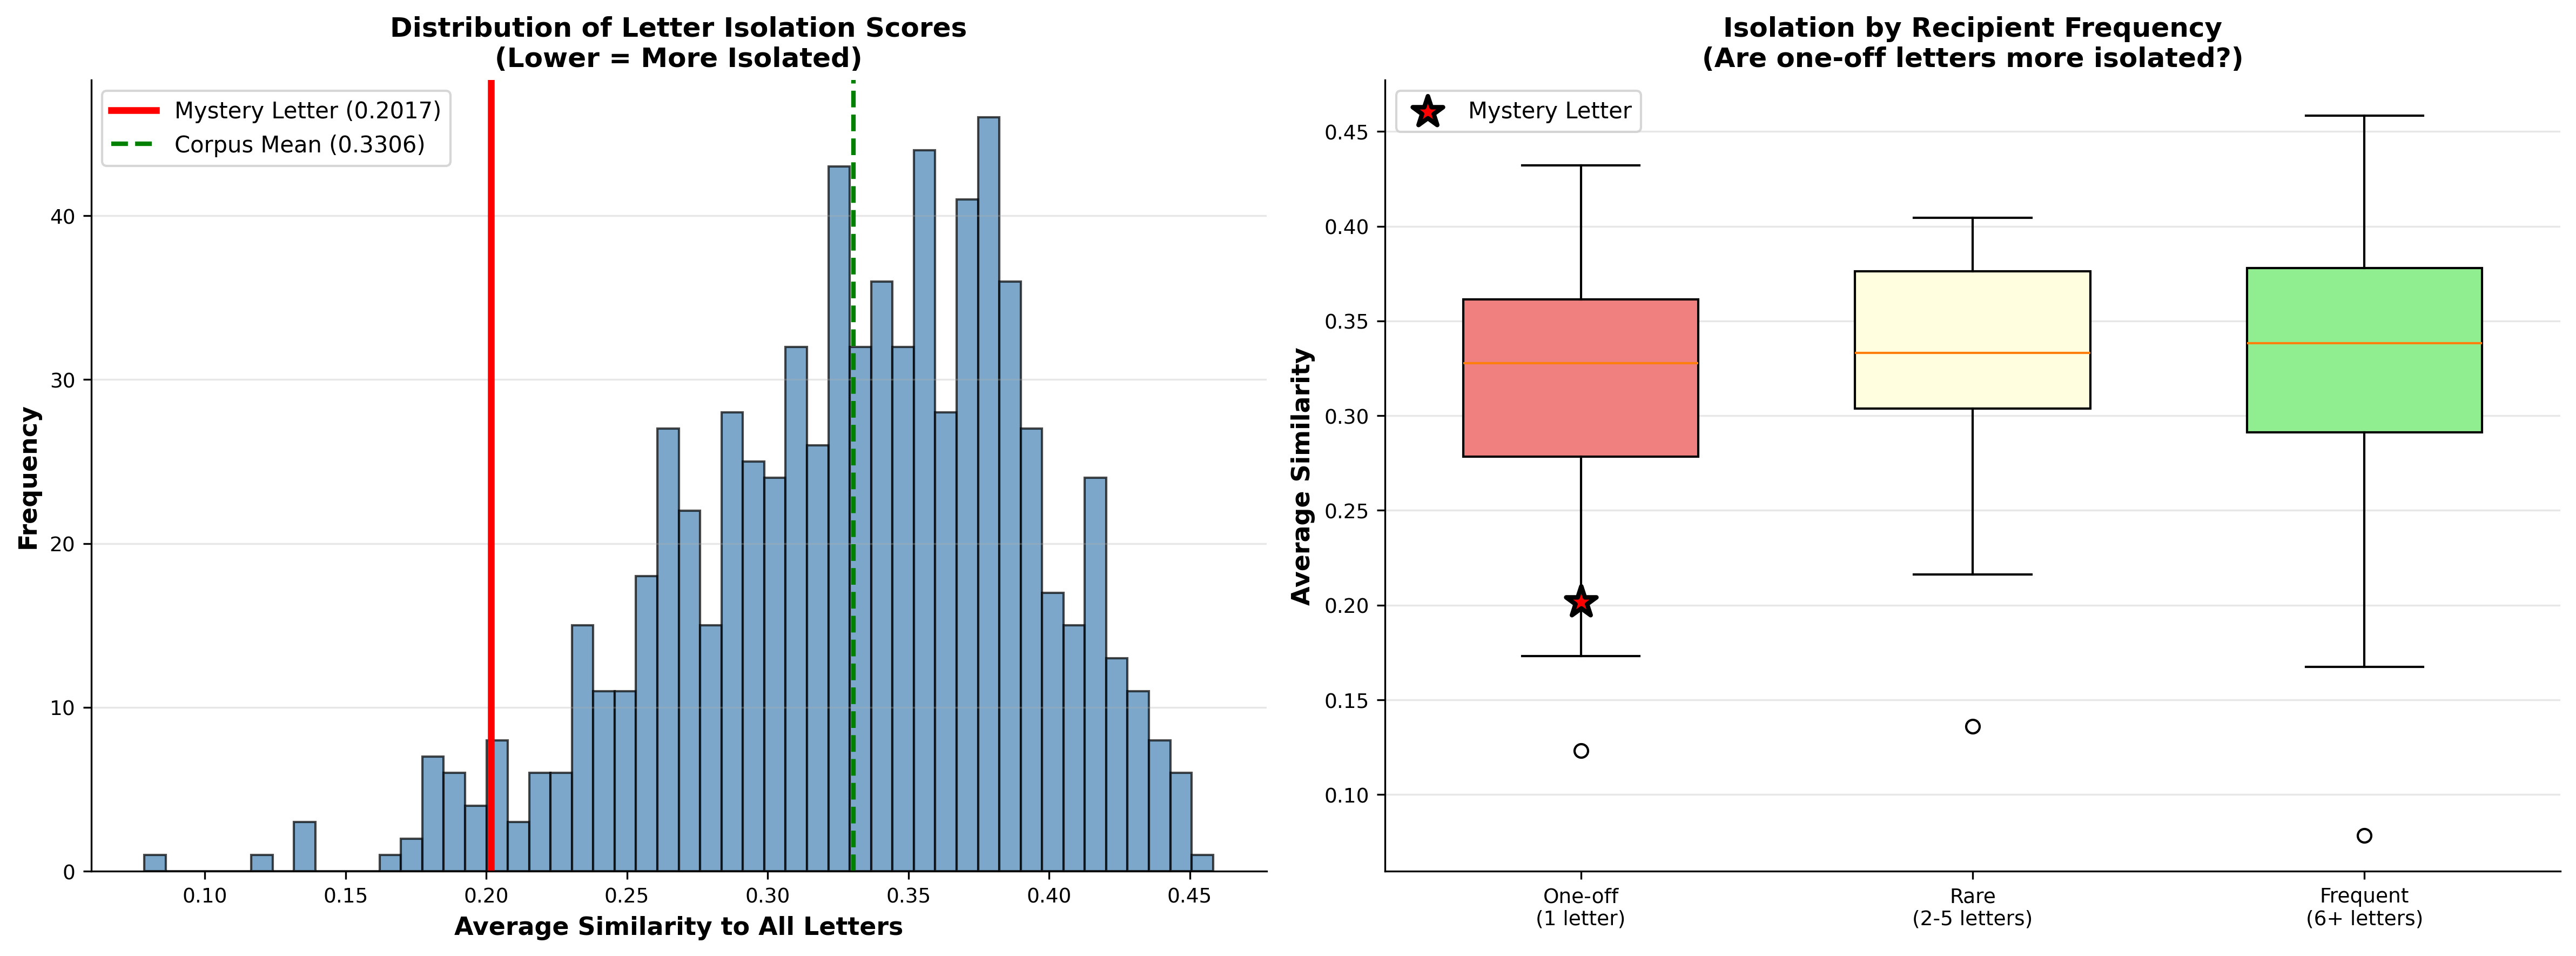


[VIZ 2] Creating comparison visualization...
  ✓ Saved: mystery_vs_recipients_comparison.png


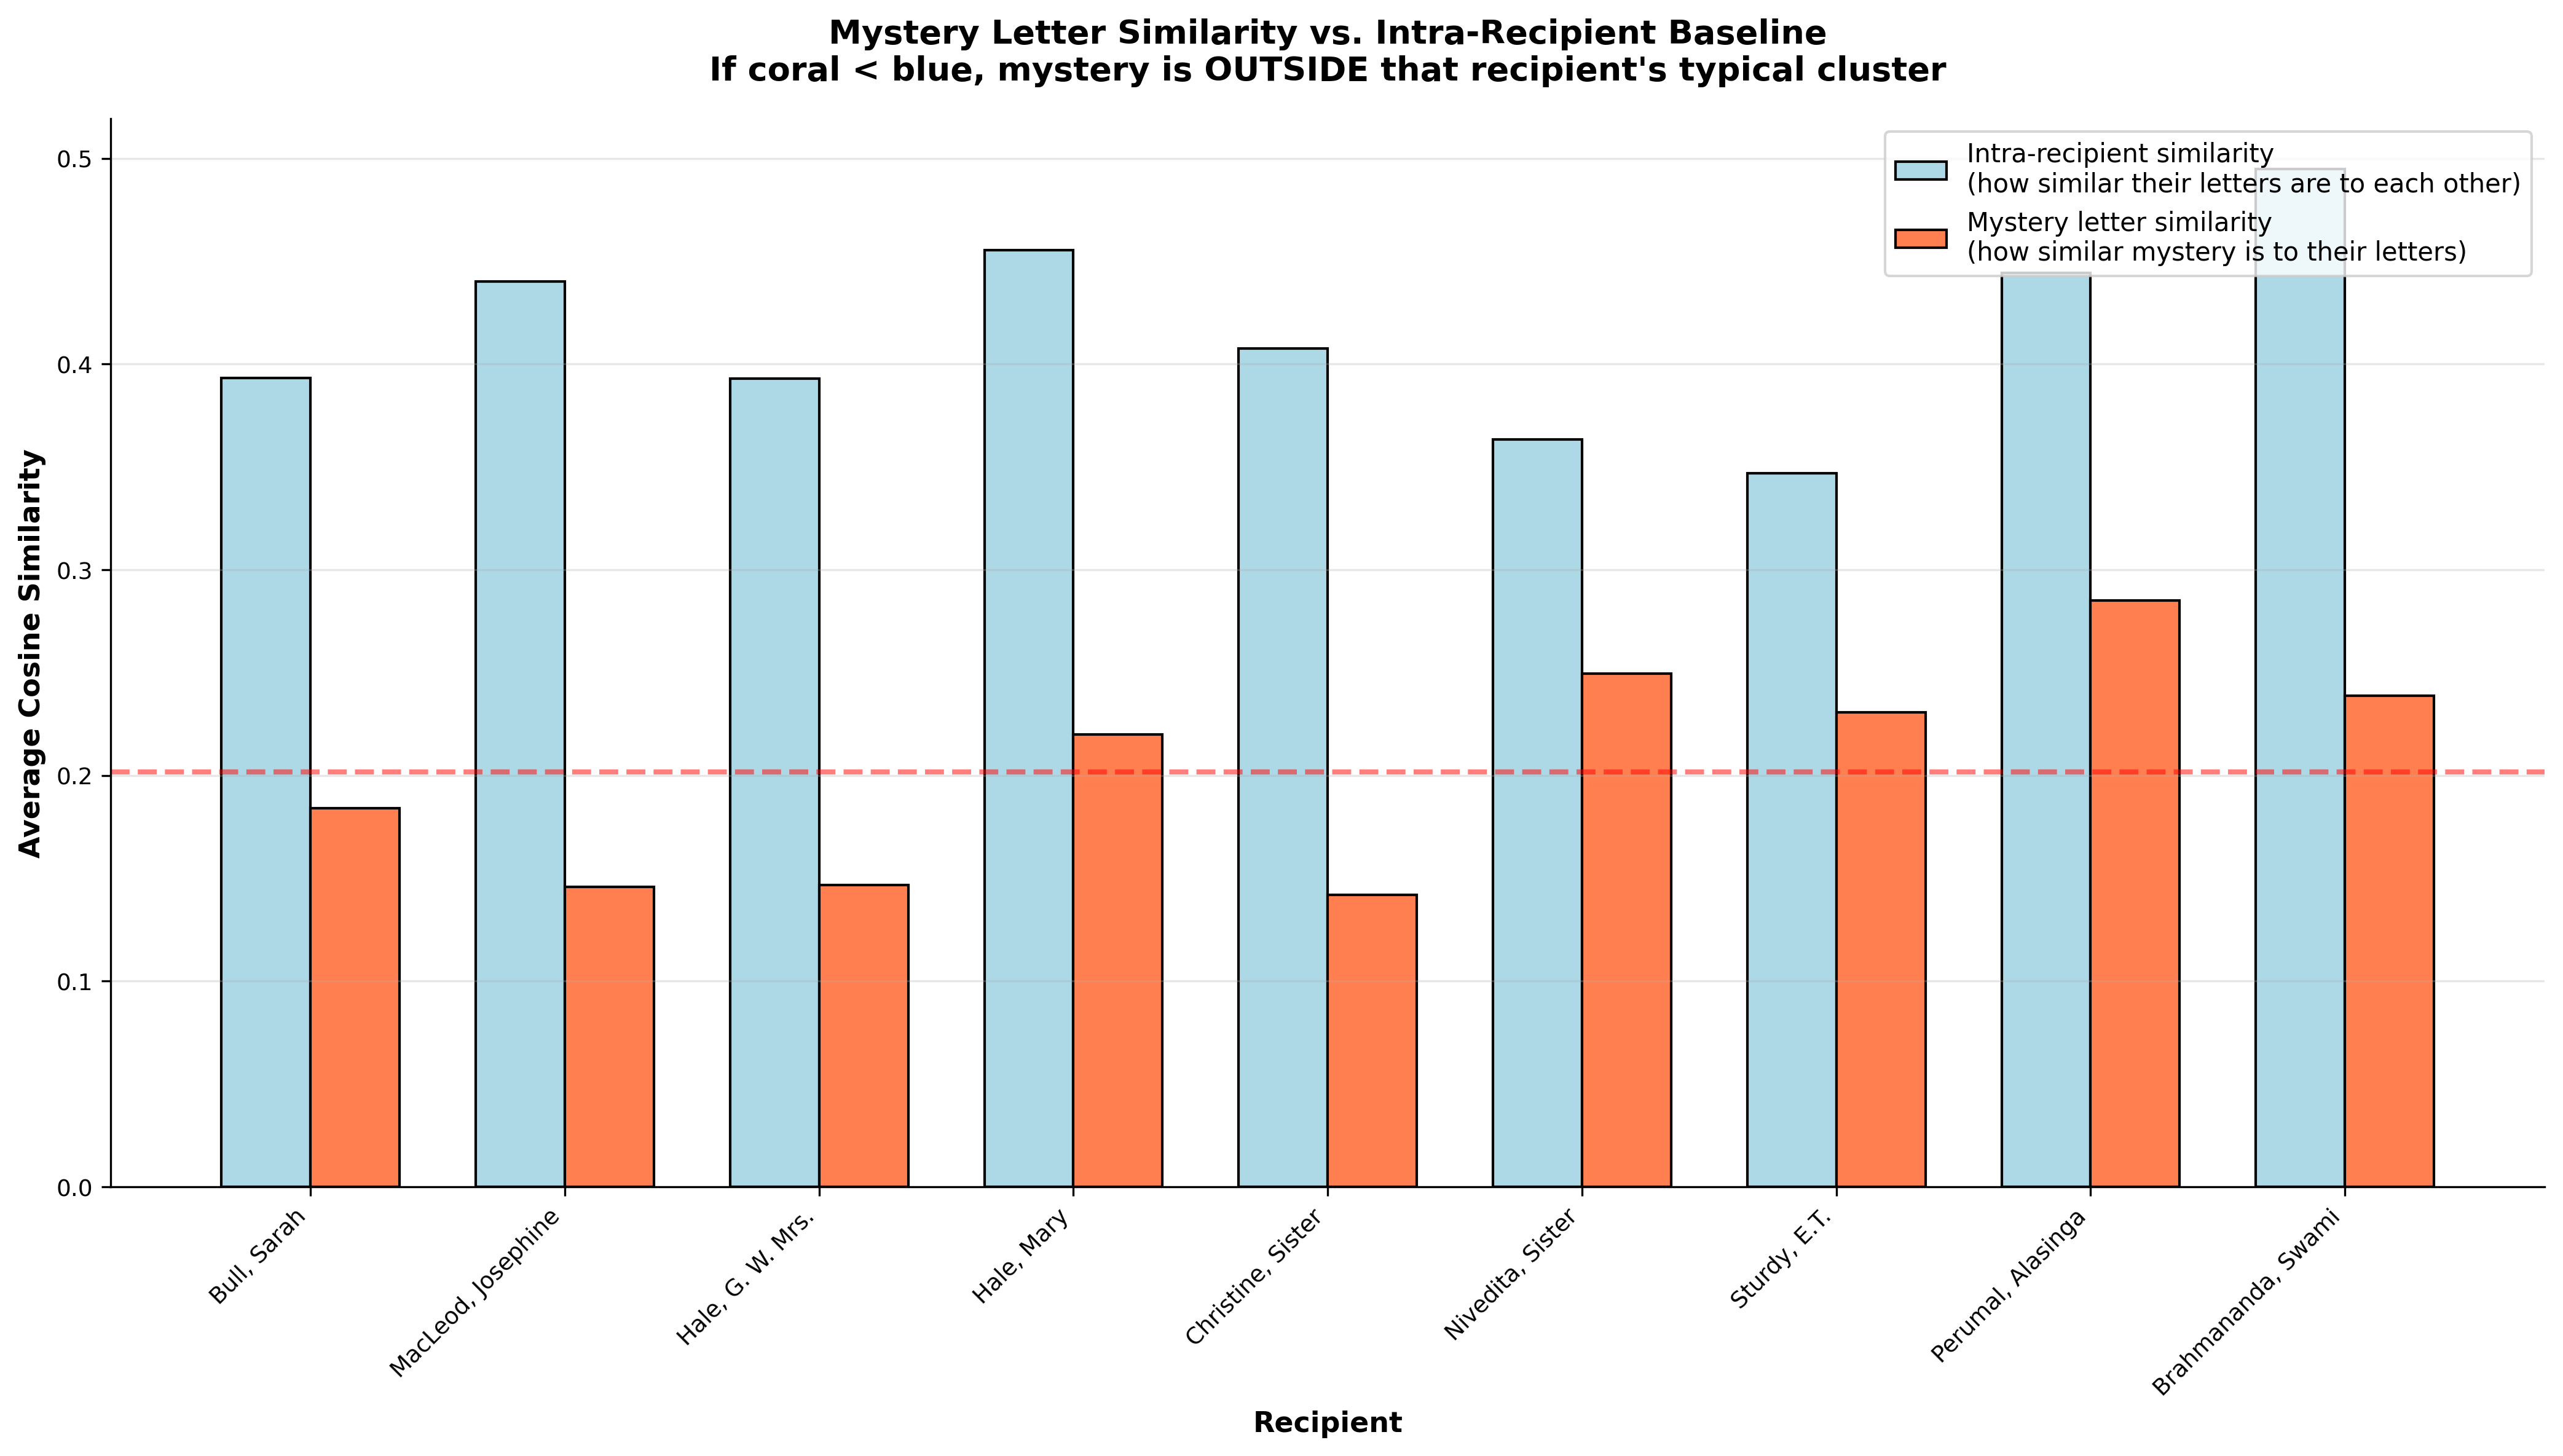


FINAL VERDICT: IS 'AMERICAN LADY' A ONE-OFF CORRESPONDENT?

📊 KEY EVIDENCE:

1. ISOLATION METRICS:
   - Mystery letter's avg similarity to corpus: 0.2017
   - Corpus average: 0.3306
   - Mystery's best match: 0.4932
   - Isolation rank: 26/762 (3.4th percentile)

2. COMPARISON TO KNOWN RECIPIENTS:
   - Best matching recipient: Perumal, Alasinga
   - Avg similarity to their letters: 0.2852
   - That recipient's intra-similarity: 0.4443
   - Difference: -0.1591

3. ONE-OFF PATTERN:
   - One-off letters avg isolation: 0.3168
   - Frequent letters avg isolation: 0.3322
   - Mystery letter's isolation: 0.2017

🎯 CONCLUSION:
   ✓ LIKELY ONE-OFF CORRESPONDENT
     - Max similarity is only 0.4932 (weak match)
     - Content is unique compared to all known recipients
     - 'American Lady' was probably someone Swamiji wrote to once or rarely

✓ Analysis complete!


In [32]:
# ============================================================================
# ADVANCED MYSTERY LETTER ANALYSIS: ONE-OFF vs FREQUENT CORRESPONDENT
# Testing if "American Lady" is a unique correspondent or matches known recipients
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ADVANCED ANALYSIS: IS 'AMERICAN LADY' A ONE-OFF CORRESPONDENT?")
print("="*80)

# Mystery letter details
mystery_idx = 73
mystery_embedding = embeddings[letter_ids.index(mystery_idx)]
mystery_embedding_reshaped = mystery_embedding.reshape(1, -1)

# ============================================================================
# ANALYSIS 1: COMPUTE INTRA-RECIPIENT SIMILARITY (BASELINE)
# ============================================================================
print("\n[ANALYSIS 1] Computing baseline intra-recipient similarities...")
print("How similar are letters TO THE SAME PERSON to each other?")
print("="*80)

# For each major recipient, calculate average similarity among their letters
intra_recipient_similarities = {}

major_recipients = [
    'Bull, Sarah',
    'MacLeod, Josephine',
    'Hale, G. W. Mrs.',
    'Hale, Mary',
    'Christine, Sister',
    'Nivedita, Sister',
    'Sturdy, E.T.',
    'Perumal, Alasinga',
    'Brahmananda, Swami'
]

for recipient in major_recipients:
    # Get indices of all letters to this recipient
    recipient_indices = [i for i, r in enumerate(recipients) if r == recipient]

    if len(recipient_indices) >= 2:
        # Get embeddings for this recipient's letters
        recipient_embeddings = embeddings[recipient_indices]

        # Calculate pairwise similarities
        sim_matrix = cosine_similarity(recipient_embeddings)

        # Get upper triangle (exclude diagonal)
        upper_tri = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

        avg_sim = np.mean(upper_tri)
        std_sim = np.std(upper_tri)
        min_sim = np.min(upper_tri)
        max_sim = np.max(upper_tri)

        intra_recipient_similarities[recipient] = {
            'avg': avg_sim,
            'std': std_sim,
            'min': min_sim,
            'max': max_sim,
            'n_letters': len(recipient_indices)
        }

        print(f"\n  {recipient}:")
        print(f"    Letters: {len(recipient_indices)}")
        print(f"    Avg intra-similarity: {avg_sim:.4f} (±{std_sim:.4f})")
        print(f"    Range: [{min_sim:.4f}, {max_sim:.4f}]")

# ============================================================================
# ANALYSIS 2: MYSTERY LETTER SIMILARITY TO EACH RECIPIENT'S CLUSTER
# ============================================================================
print("\n" + "="*80)
print("[ANALYSIS 2] How similar is mystery letter to each recipient's cluster?")
print("="*80)

mystery_to_recipient = {}

for recipient in major_recipients:
    # Get indices of all letters to this recipient
    recipient_indices = [i for i, r in enumerate(recipients) if r == recipient]

    if len(recipient_indices) >= 1:
        # Get embeddings for this recipient's letters
        recipient_embeddings = embeddings[recipient_indices]

        # Calculate similarities between mystery letter and all letters to this recipient
        similarities = cosine_similarity(mystery_embedding_reshaped, recipient_embeddings)[0]

        avg_sim = np.mean(similarities)
        max_sim = np.max(similarities)
        std_sim = np.std(similarities)

        mystery_to_recipient[recipient] = {
            'avg': avg_sim,
            'max': max_sim,
            'std': std_sim,
            'n_letters': len(recipient_indices)
        }

# Sort by average similarity
sorted_recipients = sorted(mystery_to_recipient.items(), key=lambda x: x[1]['avg'], reverse=True)

print("\n  Mystery letter similarity to each recipient's letters:")
print("  (Higher = more similar to that recipient's typical content)")
print()
for recipient, stats in sorted_recipients:
    print(f"  {recipient:30s}: avg={stats['avg']:.4f}, max={stats['max']:.4f}, n={stats['n_letters']}")

# ============================================================================
# ANALYSIS 3: COMPARE MYSTERY TO BASELINE
# ============================================================================
print("\n" + "="*80)
print("[ANALYSIS 3] Is mystery letter INSIDE or OUTSIDE known recipient clusters?")
print("="*80)

print("\n  Comparison: Mystery similarity vs. Intra-recipient baseline")
print("  If mystery_avg < intra_avg, then mystery is OUTSIDE that cluster")
print()

for recipient in major_recipients:
    if recipient in intra_recipient_similarities and recipient in mystery_to_recipient:
        intra_avg = intra_recipient_similarities[recipient]['avg']
        mystery_avg = mystery_to_recipient[recipient]['avg']

        difference = mystery_avg - intra_avg

        if difference < -0.05:
            verdict = "❌ OUTSIDE cluster (unlikely match)"
        elif difference < 0.05:
            verdict = "⚠️  BORDERLINE (weak match)"
        else:
            verdict = "✓ INSIDE cluster (possible match)"

        print(f"  {recipient:30s}: intra={intra_avg:.4f}, mystery={mystery_avg:.4f}, "
              f"diff={difference:+.4f} → {verdict}")

# ============================================================================
# ANALYSIS 4: ISOLATION SCORE - HOW UNIQUE IS THE MYSTERY LETTER?
# ============================================================================
print("\n" + "="*80)
print("[ANALYSIS 4] Computing isolation score for mystery letter...")
print("="*80)

# Calculate similarity of mystery letter to ALL letters
all_similarities = cosine_similarity(mystery_embedding_reshaped, embeddings)[0]

# Remove self-similarity
all_similarities = all_similarities[all_similarities != 1.0]

mystery_isolation = {
    'avg_similarity_to_all': np.mean(all_similarities),
    'median_similarity': np.median(all_similarities),
    'std_similarity': np.std(all_similarities),
    'max_similarity': np.max(all_similarities),
    'percentile_90': np.percentile(all_similarities, 90),
    'percentile_75': np.percentile(all_similarities, 75),
    'percentile_50': np.percentile(all_similarities, 50),
    'percentile_25': np.percentile(all_similarities, 25),
}

print(f"\n  Mystery Letter Isolation Metrics:")
print(f"    Average similarity to all letters: {mystery_isolation['avg_similarity_to_all']:.4f}")
print(f"    Median similarity: {mystery_isolation['median_similarity']:.4f}")
print(f"    Std deviation: {mystery_isolation['std_similarity']:.4f}")
print(f"    Max similarity (best match): {mystery_isolation['max_similarity']:.4f}")
print(f"    90th percentile: {mystery_isolation['percentile_90']:.4f}")
print(f"    75th percentile: {mystery_isolation['percentile_75']:.4f}")
print(f"    50th percentile: {mystery_isolation['percentile_50']:.4f}")

print(f"\n  Interpretation:")
if mystery_isolation['max_similarity'] < 0.5:
    print(f"    ⚠️  HIGHLY ISOLATED: Max similarity is only {mystery_isolation['max_similarity']:.4f}")
    print(f"    This suggests UNIQUE content → likely ONE-OFF correspondent")
elif mystery_isolation['avg_similarity_to_all'] < 0.25:
    print(f"    ⚠️  MODERATELY ISOLATED: Avg similarity is {mystery_isolation['avg_similarity_to_all']:.4f}")
    print(f"    This suggests UNUSUAL content for the corpus")
else:
    print(f"    ✓ WELL-CONNECTED: This content is typical for the corpus")

# ============================================================================
# ANALYSIS 5: FIND OTHER POTENTIALLY ONE-OFF LETTERS
# ============================================================================
print("\n" + "="*80)
print("[ANALYSIS 5] Finding other potentially one-off letters for comparison...")
print("="*80)

# For each letter, calculate its average similarity to all other letters
all_isolation_scores = []

for i, letter_id in enumerate(letter_ids):
    if i % 100 == 0:
        print(f"  Processing {i}/{len(letter_ids)}...")

    letter_embedding = embeddings[i].reshape(1, -1)
    sims = cosine_similarity(letter_embedding, embeddings)[0]

    # Exclude self
    sims = sims[sims != 1.0]

    avg_sim = np.mean(sims)
    max_sim = np.max(sims)

    all_isolation_scores.append({
        'letter_id': letter_id,
        'recipient': recipients[i],
        'avg_similarity': avg_sim,
        'max_similarity': max_sim,
        'name': all_letters.loc[letter_id, 'Name'] if letter_id in all_letters.index else None,
        'date': dates[i]
    })

isolation_df = pd.DataFrame(all_isolation_scores)

# Find most isolated letters (lowest average similarity)
most_isolated = isolation_df.nsmallest(20, 'avg_similarity')

print(f"\n  Top 20 most ISOLATED letters (lowest avg similarity to corpus):")
print("="*100)
for i, row in enumerate(most_isolated.itertuples(), 1):
    is_mystery = "★ MYSTERY" if row.letter_id == mystery_idx else ""
    print(f"  {i:2d}. {row.name[:25]:25s} | To: {row.recipient[:25]:25s} | "
          f"Avg: {row.avg_similarity:.4f} | Max: {row.max_similarity:.4f} {is_mystery}")

# Find mystery letter's rank
mystery_rank = (isolation_df['avg_similarity'] < mystery_isolation['avg_similarity_to_all']).sum() + 1
total = len(isolation_df)

print(f"\n  Mystery letter isolation rank: {mystery_rank}/{total}")
print(f"  This means {mystery_rank-1} letters are MORE isolated than the mystery letter")
print(f"  Percentile: {(mystery_rank/total)*100:.1f}th percentile")

# ============================================================================
# ANALYSIS 6: RECIPIENT FREQUENCY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[ANALYSIS 6] Analyzing recipient frequency patterns...")
print("="*80)

# Count letters per recipient
recipient_counts = pd.Series(recipients).value_counts()

# Categorize recipients
one_off = recipient_counts[recipient_counts == 1]
rare = recipient_counts[(recipient_counts > 1) & (recipient_counts <= 5)]
frequent = recipient_counts[recipient_counts > 5]

print(f"\n  Recipient categories:")
print(f"    One-off (1 letter): {len(one_off)} recipients")
print(f"    Rare (2-5 letters): {len(rare)} recipients")
print(f"    Frequent (6+ letters): {len(frequent)} recipients")

print(f"\n  Examples of one-off recipients:")
for recipient in one_off.head(10).index:
    letter_idx = recipients.index(recipient)
    letter_id = letter_ids[letter_idx]
    name = all_letters.loc[letter_id, 'Name'] if letter_id in all_letters.index else 'Unknown'
    print(f"    - {recipient[:40]:40s} ({name})")

# Check isolation scores for one-off vs frequent
one_off_recipients = one_off.index.tolist()
frequent_recipients = frequent.index.tolist()

one_off_isolation = isolation_df[isolation_df['recipient'].isin(one_off_recipients)]['avg_similarity']
frequent_isolation = isolation_df[isolation_df['recipient'].isin(frequent_recipients)]['avg_similarity']

print(f"\n  Isolation comparison:")
print(f"    One-off recipients avg isolation: {one_off_isolation.mean():.4f} (±{one_off_isolation.std():.4f})")
print(f"    Frequent recipients avg isolation: {frequent_isolation.mean():.4f} (±{frequent_isolation.std():.4f})")

if one_off_isolation.mean() < frequent_isolation.mean():
    print(f"    ✓ One-off letters ARE more isolated on average!")
else:
    print(f"    Note: One-off letters are NOT necessarily more isolated")

# ============================================================================
# VISUALIZATION 1: ISOLATION DISTRIBUTION
# ============================================================================
print("\n" + "="*80)
print("[VIZ 1] Creating isolation distribution plot...")
print("="*80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Histogram of isolation scores
ax1.hist(isolation_df['avg_similarity'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(mystery_isolation['avg_similarity_to_all'], color='red', linewidth=3,
           label=f"Mystery Letter ({mystery_isolation['avg_similarity_to_all']:.4f})")
ax1.axvline(isolation_df['avg_similarity'].mean(), color='green', linestyle='--', linewidth=2,
           label=f"Corpus Mean ({isolation_df['avg_similarity'].mean():.4f})")

ax1.set_xlabel('Average Similarity to All Letters', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Letter Isolation Scores\n(Lower = More Isolated)',
             fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Box plot by recipient category
box_data = [
    one_off_isolation.values,
    rare[rare.index.isin(isolation_df['recipient'])].index.map(
        lambda x: isolation_df[isolation_df['recipient'] == x]['avg_similarity'].values[0]
    ).values,
    frequent_isolation.values
]

bp = ax2.boxplot(box_data, labels=['One-off\n(1 letter)', 'Rare\n(2-5 letters)', 'Frequent\n(6+ letters)'],
                 patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'], ['lightcoral', 'lightyellow', 'lightgreen']):
    patch.set_facecolor(color)

# Add mystery letter point
mystery_category = 0  # Assuming American Lady is one-off
ax2.scatter([1], [mystery_isolation['avg_similarity_to_all']],
           color='red', s=200, marker='*', edgecolors='black', linewidth=2,
           label='Mystery Letter', zorder=10)

ax2.set_ylabel('Average Similarity', fontsize=11, fontweight='bold')
ax2.set_title('Isolation by Recipient Frequency\n(Are one-off letters more isolated?)',
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('mystery_isolation_analysis.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: mystery_isolation_analysis.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: MYSTERY LETTER vs RECIPIENT CLUSTERS
# ============================================================================
print("\n[VIZ 2] Creating comparison visualization...")

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data
recipients_list = []
intra_scores = []
mystery_scores = []

for recipient in major_recipients:
    if recipient in intra_recipient_similarities and recipient in mystery_to_recipient:
        recipients_list.append(recipient[:20])
        intra_scores.append(intra_recipient_similarities[recipient]['avg'])
        mystery_scores.append(mystery_to_recipient[recipient]['avg'])

x = np.arange(len(recipients_list))
width = 0.35

bars1 = ax.bar(x - width/2, intra_scores, width, label='Intra-recipient similarity\n(how similar their letters are to each other)',
               color='lightblue', edgecolor='black', linewidth=1)
bars2 = ax.bar(x + width/2, mystery_scores, width, label='Mystery letter similarity\n(how similar mystery is to their letters)',
               color='coral', edgecolor='black', linewidth=1)

ax.set_xlabel('Recipient', fontsize=11, fontweight='bold')
ax.set_ylabel('Average Cosine Similarity', fontsize=11, fontweight='bold')
ax.set_title('Mystery Letter Similarity vs. Intra-Recipient Baseline\n' +
             'If coral < blue, mystery is OUTSIDE that recipient\'s typical cluster',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(recipients_list, rotation=45, ha='right')
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal line at mystery's average
ax.axhline(mystery_isolation['avg_similarity_to_all'], color='red', linestyle='--',
          linewidth=2, alpha=0.5, label=f"Mystery avg to all: {mystery_isolation['avg_similarity_to_all']:.3f}")

plt.tight_layout()
plt.savefig('mystery_vs_recipients_comparison.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: mystery_vs_recipients_comparison.png")
plt.show()

# ============================================================================
# FINAL VERDICT
# ============================================================================
print("\n" + "="*80)
print("FINAL VERDICT: IS 'AMERICAN LADY' A ONE-OFF CORRESPONDENT?")
print("="*80)

print(f"\n📊 KEY EVIDENCE:")

print(f"\n1. ISOLATION METRICS:")
print(f"   - Mystery letter's avg similarity to corpus: {mystery_isolation['avg_similarity_to_all']:.4f}")
print(f"   - Corpus average: {isolation_df['avg_similarity'].mean():.4f}")
print(f"   - Mystery's best match: {mystery_isolation['max_similarity']:.4f}")
print(f"   - Isolation rank: {mystery_rank}/{total} ({(mystery_rank/total)*100:.1f}th percentile)")

print(f"\n2. COMPARISON TO KNOWN RECIPIENTS:")
best_match_recipient = sorted_recipients[0][0]
best_match_score = sorted_recipients[0][1]['avg']
print(f"   - Best matching recipient: {best_match_recipient}")
print(f"   - Avg similarity to their letters: {best_match_score:.4f}")

# Get intra-similarity for best match
if best_match_recipient in intra_recipient_similarities:
    best_intra = intra_recipient_similarities[best_match_recipient]['avg']
    print(f"   - That recipient's intra-similarity: {best_intra:.4f}")
    print(f"   - Difference: {best_match_score - best_intra:.4f}")

print(f"\n3. ONE-OFF PATTERN:")
print(f"   - One-off letters avg isolation: {one_off_isolation.mean():.4f}")
print(f"   - Frequent letters avg isolation: {frequent_isolation.mean():.4f}")
print(f"   - Mystery letter's isolation: {mystery_isolation['avg_similarity_to_all']:.4f}")

print(f"\n🎯 CONCLUSION:")

# Decision logic
if mystery_isolation['max_similarity'] < 0.5:
    print(f"   ✓ LIKELY ONE-OFF CORRESPONDENT")
    print(f"     - Max similarity is only {mystery_isolation['max_similarity']:.4f} (weak match)")
    print(f"     - Content is unique compared to all known recipients")
    print(f"     - 'American Lady' was probably someone Swamiji wrote to once or rarely")
elif best_match_score < intra_recipient_similarities.get(best_match_recipient, {}).get('avg', 0):
    print(f"   ✓ LIKELY ONE-OFF CORRESPONDENT")
    print(f"     - Mystery letter is OUTSIDE even the best matching recipient's cluster")
    print(f"     - Content doesn't match any known correspondent's typical style")
else:
    print(f"   ⚠️  UNCERTAIN - Could be {best_match_recipient} or a rare correspondent")
    print(f"     - Mystery letter shows moderate similarity to known recipients")
    print(f"     - Further investigation needed")

print("\n" + "="*80)
print("✓ Analysis complete!")
print("="*80)

SALUTATION SWITCHING ANALYSIS: Sister → Madam

[STEP 1] Extracting salutations from letter names...
  ✓ Extracted salutations for 762 letters

  Top 20 salutations used:
    Mother              :  80 letters
    Mrs.                :  59 letters
    Sir                 :  50 letters
    Alasinga            :  40 letters
    Sister              :  39 letters
    Christina           :  36 letters
    Rakhal              :  35 letters
    Joe                 :  34 letters
    Mary                :  24 letters
    Friend              :  22 letters
    Miss                :  20 letters
    Christine           :  19 letters
    Shashi              :  18 letters
    Margot              :  16 letters
    Blessed             :  14 letters
    Diwanji             :  13 letters
    Nivedita            :  13 letters
    Dhira               :  13 letters
    Your                :  11 letters
    Adhyapakji          :  10 letters

[STEP 2] Finding recipients who were addressed as BOTH 'Sister' AND '

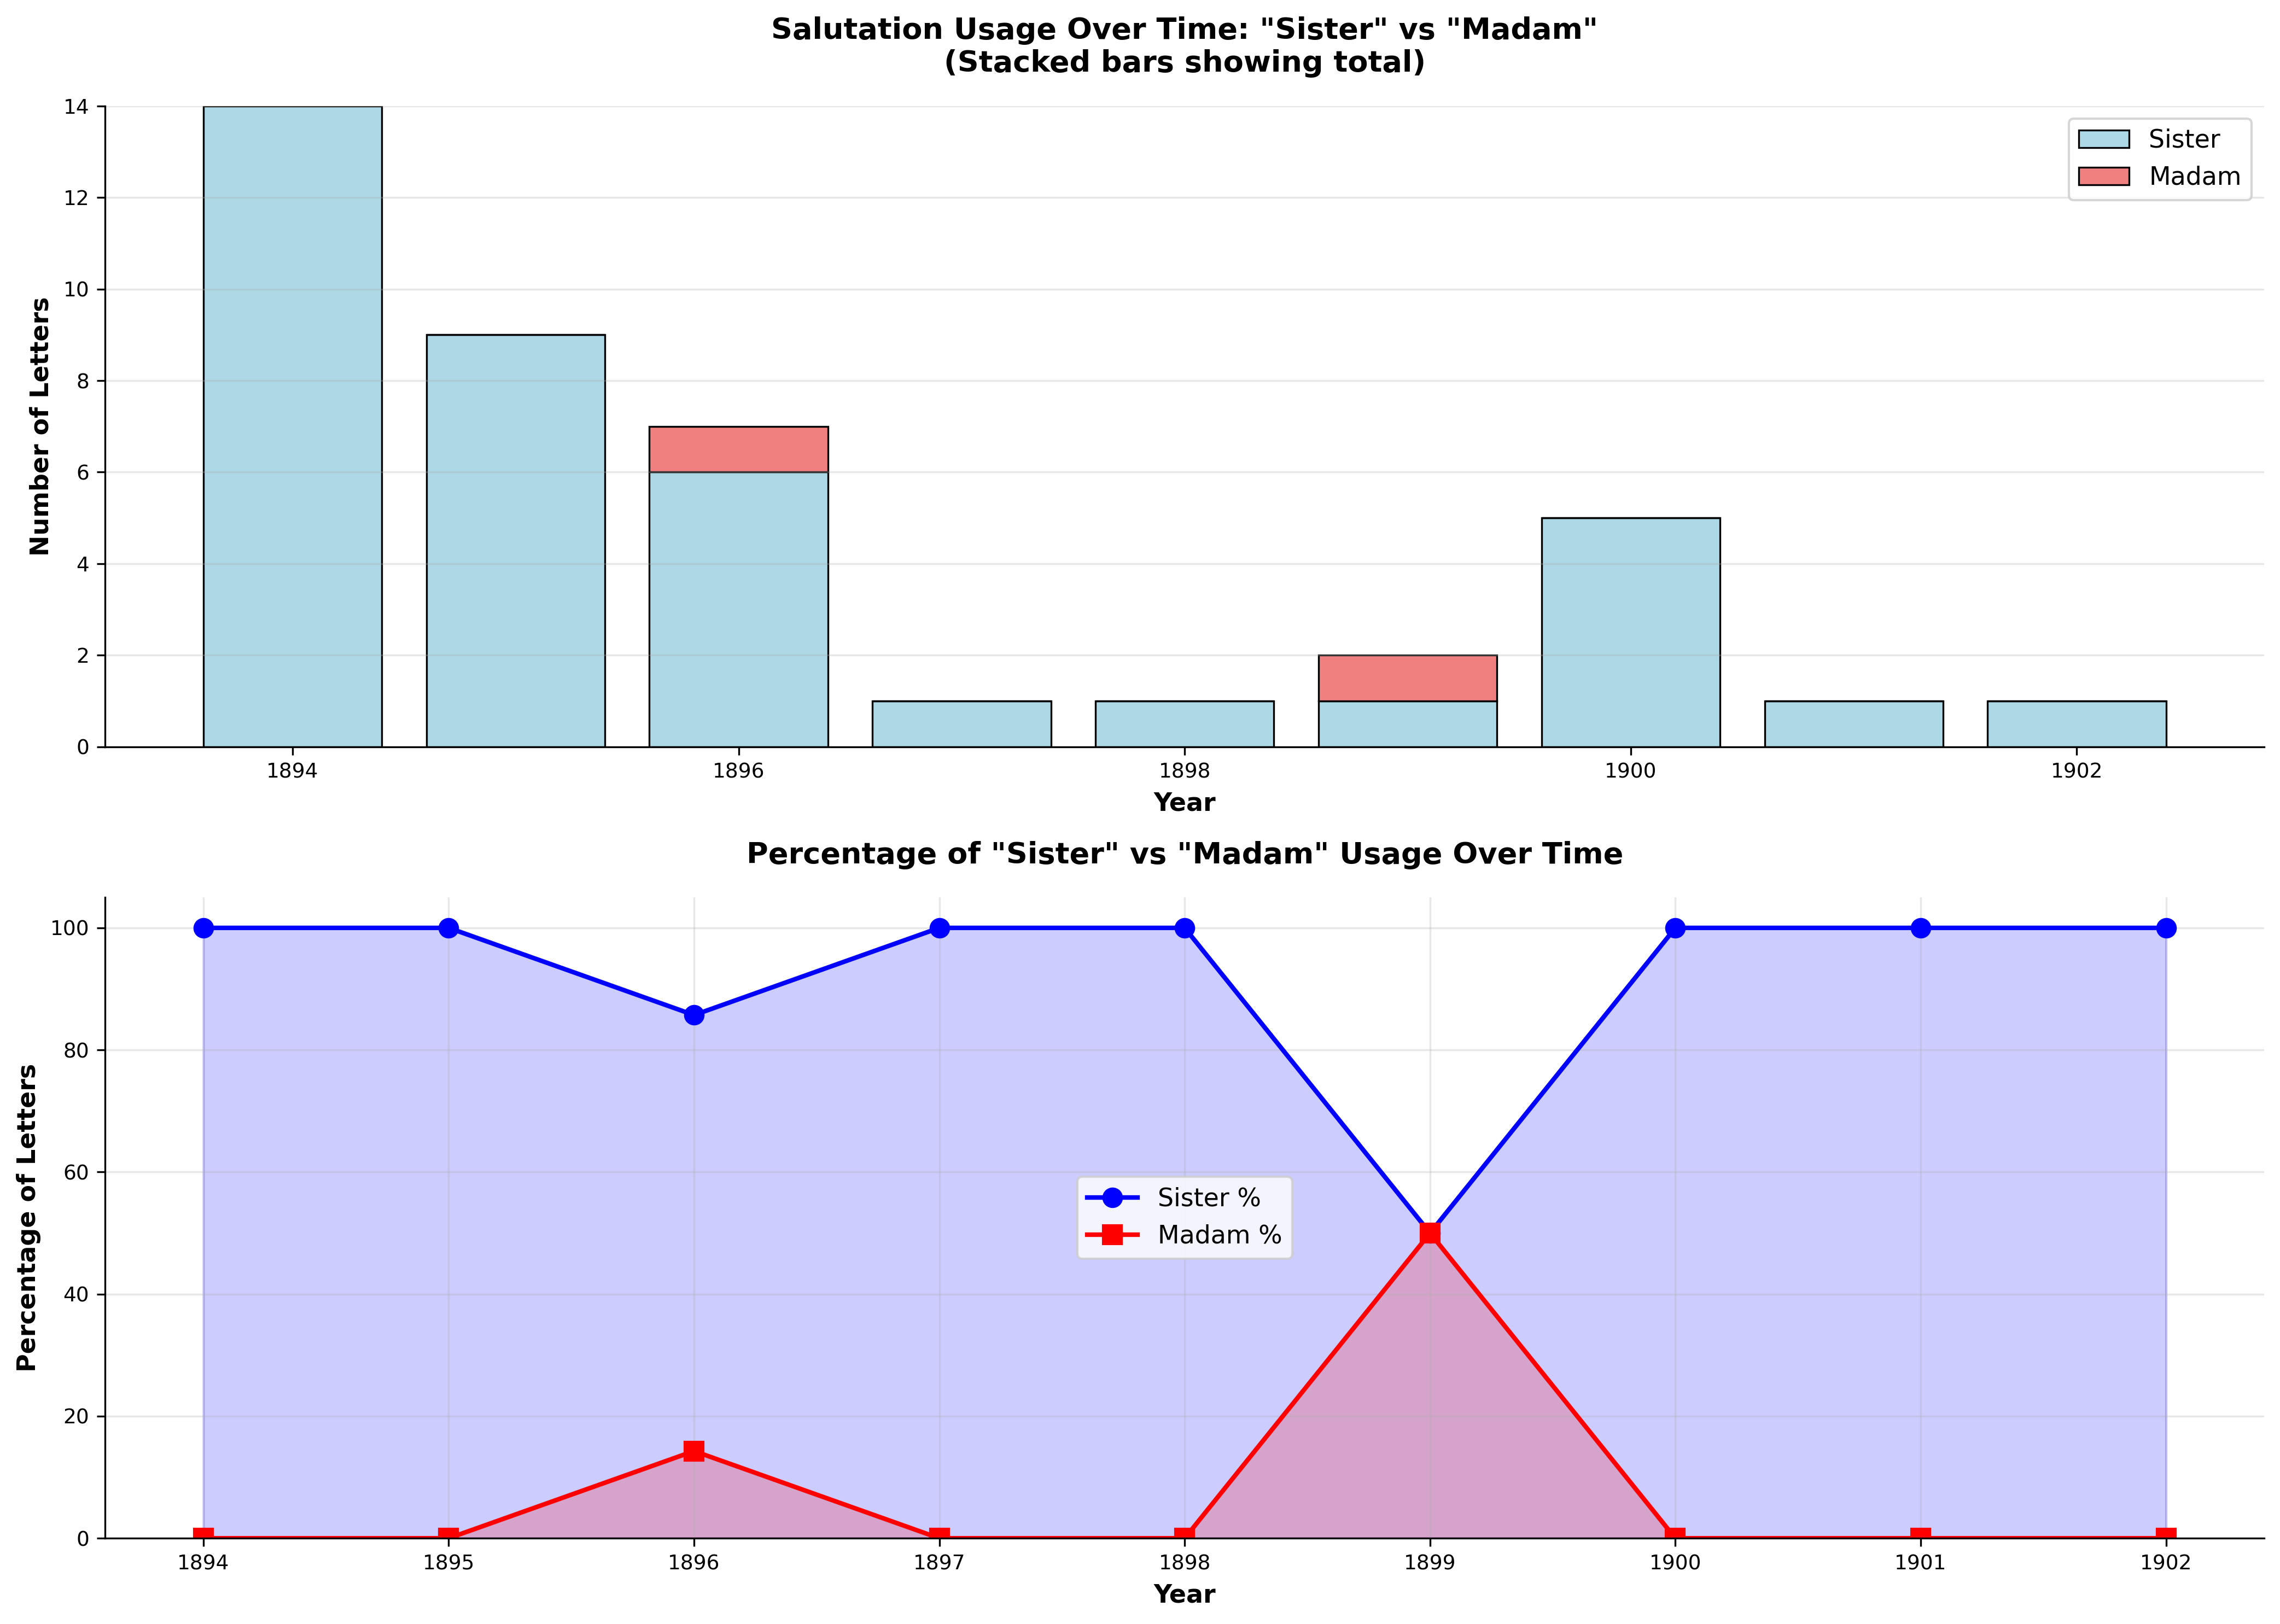


SUMMARY: SALUTATION SWITCHING PATTERNS

📊 KEY FINDINGS:
  • Total 'Sister' salutations: 39
  • Total 'Madam' salutations: 2
  • Recipients who received BOTH: 0

✓ NO SWITCHING DETECTED:
  Swamiji maintained consistent salutations for each recipient
  Recipients were addressed as either 'Sister' OR 'Madam', not both

✓ Analysis complete!


In [33]:
# ============================================================================
# SALUTATION ANALYSIS: "Sister" → "Madam" SWITCHING
# Check if Swamiji changed how he addressed recipients over time
# ============================================================================

import pandas as pd
import numpy as np
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("SALUTATION SWITCHING ANALYSIS: Sister → Madam")
print("="*80)

# ============================================================================
# STEP 1: EXTRACT SALUTATIONS FROM LETTER NAMES
# ============================================================================
print("\n[STEP 1] Extracting salutations from letter names...")

def extract_salutation(letter_name):
    """
    Extract the salutation from letter name.
    Examples: "LXXIII Madam" → "Madam", "XC Sister" → "Sister"
    """
    if pd.isna(letter_name):
        return None

    # Remove Roman numerals and number prefixes
    name_clean = re.sub(r'^[IVXLCDM]+\s+', '', str(letter_name))
    name_clean = re.sub(r'^\d+\s+', '', name_clean)

    # Extract first word (usually the salutation)
    words = name_clean.strip().split()
    if len(words) > 0:
        salutation = words[0]
        return salutation
    return None

# Extract salutations for all letters
all_letters['salutation'] = all_letters['Name'].apply(extract_salutation)

print(f"  ✓ Extracted salutations for {len(all_letters)} letters")

# Show distribution of salutations
print(f"\n  Top 20 salutations used:")
salutation_counts = all_letters['salutation'].value_counts().head(20)
for salutation, count in salutation_counts.items():
    print(f"    {salutation:20s}: {count:3d} letters")

# ============================================================================
# STEP 2: FIND RECIPIENTS WHO RECEIVED BOTH "SISTER" AND "MADAM"
# ============================================================================
print("\n" + "="*80)
print("[STEP 2] Finding recipients who were addressed as BOTH 'Sister' AND 'Madam'...")
print("="*80)

# Get letters with Sister salutation
sister_letters = all_letters[all_letters['salutation'] == 'Sister'].copy()
print(f"\n  Total letters with 'Sister' salutation: {len(sister_letters)}")

# Get letters with Madam salutation
madam_letters = all_letters[all_letters['salutation'] == 'Madam'].copy()
print(f"  Total letters with 'Madam' salutation: {len(madam_letters)}")

# Find recipients who received BOTH
sister_recipients = set(sister_letters['Audience_clean'].dropna().unique())
madam_recipients = set(madam_letters['Audience_clean'].dropna().unique())

both_recipients = sister_recipients.intersection(madam_recipients)

print(f"\n  Recipients addressed as 'Sister': {len(sister_recipients)}")
print(f"  Recipients addressed as 'Madam': {len(madam_recipients)}")
print(f"  Recipients who received BOTH: {len(both_recipients)}")

if len(both_recipients) > 0:
    print(f"\n  Recipients who were called both 'Sister' AND 'Madam':")
    for recipient in sorted(both_recipients):
        sister_count = len(sister_letters[sister_letters['Audience_clean'] == recipient])
        madam_count = len(madam_letters[madam_letters['Audience_clean'] == recipient])
        print(f"    - {recipient:40s}: {sister_count:2d} Sister, {madam_count:2d} Madam")

# ============================================================================
# STEP 3: TEMPORAL ANALYSIS - DID SWITCHING HAPPEN?
# ============================================================================
print("\n" + "="*80)
print("[STEP 3] Temporal analysis: When did the switching happen?")
print("="*80)

if len(both_recipients) > 0:
    for recipient in sorted(both_recipients):
        print(f"\n  {recipient}:")
        print("  " + "-"*70)

        # Get all letters to this recipient with Sister or Madam
        recipient_letters = all_letters[
            (all_letters['Audience_clean'] == recipient) &
            (all_letters['salutation'].isin(['Sister', 'Madam']))
        ].copy()

        # Sort by date
        recipient_letters = recipient_letters.sort_values('Date')

        # Show chronological order
        for idx, row in recipient_letters.iterrows():
            date = row['Date']
            year = row['year']
            salutation = row['salutation']
            name = row['Name']

            year_str = f"{int(year)}" if pd.notna(year) else "Unknown"
            print(f"    {date:15s} ({year_str:4s}) | {salutation:10s} | {name}")

        # Calculate first Sister and first Madam dates
        sister_dates = recipient_letters[recipient_letters['salutation'] == 'Sister']['year'].dropna()
        madam_dates = recipient_letters[recipient_letters['salutation'] == 'Madam']['year'].dropna()

        if len(sister_dates) > 0 and len(madam_dates) > 0:
            first_sister = sister_dates.min()
            last_sister = sister_dates.max()
            first_madam = madam_dates.min()
            last_madam = madam_dates.max()

            print(f"\n    Summary:")
            print(f"      Sister: First in {int(first_sister)}, Last in {int(last_sister)}")
            print(f"      Madam:  First in {int(first_madam)}, Last in {int(last_madam)}")

            if first_sister < first_madam:
                print(f"      → Switched from Sister to Madam (Sister came first)")
            elif first_madam < first_sister:
                print(f"      → Switched from Madam to Sister (Madam came first)")
            else:
                print(f"      → Mixed usage (same starting year)")

# ============================================================================
# STEP 4: GENERAL PATTERN - SISTER VS MADAM USAGE OVER TIME
# ============================================================================
print("\n" + "="*80)
print("[STEP 4] General pattern: Sister vs Madam usage over years...")
print("="*80)

# Count Sister and Madam by year
sister_by_year = sister_letters.groupby('year').size()
madam_by_year = madam_letters.groupby('year').size()

# Merge
year_comparison = pd.DataFrame({
    'Sister': sister_by_year,
    'Madam': madam_by_year
}).fillna(0)

print(f"\n  Sister vs Madam usage by year:")
print("  " + "-"*50)
print(f"  {'Year':6s} | {'Sister':8s} | {'Madam':8s} | {'Total':8s}")
print("  " + "-"*50)

for year in sorted(year_comparison.index):
    if pd.notna(year) and 1888 <= year <= 1902:
        sister_count = int(year_comparison.loc[year, 'Sister'])
        madam_count = int(year_comparison.loc[year, 'Madam'])
        total = sister_count + madam_count
        print(f"  {int(year):4d}   | {sister_count:8d} | {madam_count:8d} | {total:8d}")

# ============================================================================
# STEP 5: SPECIFIC CASE - SISTER NIVEDITA
# ============================================================================
print("\n" + "="*80)
print("[STEP 5] Special case: Sister Nivedita (Margaret Noble)")
print("="*80)

# Check if Nivedita received both
nivedita_letters = all_letters[
    (all_letters['Audience_clean'] == 'Nivedita, Sister') &
    (all_letters['salutation'].isin(['Sister', 'Madam', 'Miss', 'Margot']))
].copy()

if len(nivedita_letters) > 0:
    print(f"\n  Letters to Nivedita with various salutations:")
    print("  " + "-"*70)

    nivedita_letters = nivedita_letters.sort_values('Date')

    for idx, row in nivedita_letters.iterrows():
        date = row['Date']
        year = row['year']
        salutation = row['salutation']
        name = row['Name']

        year_str = f"{int(year)}" if pd.notna(year) else "Unknown"
        print(f"    {date:15s} ({year_str:4s}) | {salutation:10s} | {name}")

    # Count salutations
    salutation_counts = nivedita_letters['salutation'].value_counts()
    print(f"\n  Salutation frequency for Nivedita:")
    for sal, count in salutation_counts.items():
        print(f"    {sal:15s}: {count:2d} letters")

# ============================================================================
# VISUALIZATION: SISTER VS MADAM OVER TIME
# ============================================================================
print("\n" + "="*80)
print("[VISUALIZATION] Creating Sister vs Madam timeline...")
print("="*80)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Stacked bar chart
years = sorted([int(y) for y in year_comparison.index if pd.notna(y) and 1888 <= y <= 1902])
sister_counts = [int(year_comparison.loc[y, 'Sister']) if y in year_comparison.index else 0 for y in years]
madam_counts = [int(year_comparison.loc[y, 'Madam']) if y in year_comparison.index else 0 for y in years]

ax1.bar(years, sister_counts, label='Sister', color='lightblue', edgecolor='black', linewidth=0.8)
ax1.bar(years, madam_counts, bottom=sister_counts, label='Madam', color='lightcoral',
        edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Year', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Letters', fontsize=11, fontweight='bold')
ax1.set_title('Salutation Usage Over Time: "Sister" vs "Madam"\n(Stacked bars showing total)',
             fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Bottom: Line chart showing proportions
total_counts = [s + m for s, m in zip(sister_counts, madam_counts)]
sister_pct = [(s / t * 100) if t > 0 else 0 for s, t in zip(sister_counts, total_counts)]
madam_pct = [(m / t * 100) if t > 0 else 0 for m, t in zip(madam_counts, total_counts)]

ax2.plot(years, sister_pct, marker='o', linewidth=2, markersize=8,
         label='Sister %', color='blue')
ax2.plot(years, madam_pct, marker='s', linewidth=2, markersize=8,
         label='Madam %', color='red')
ax2.fill_between(years, 0, sister_pct, alpha=0.2, color='blue')
ax2.fill_between(years, 0, madam_pct, alpha=0.2, color='red')

ax2.set_xlabel('Year', fontsize=11, fontweight='bold')
ax2.set_ylabel('Percentage of Letters', fontsize=11, fontweight='bold')
ax2.set_title('Percentage of "Sister" vs "Madam" Usage Over Time',
             fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim(0, 105)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('salutation_sister_vs_madam_timeline.png', bbox_inches='tight', dpi=300)
print("  ✓ Saved: salutation_sister_vs_madam_timeline.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY: SALUTATION SWITCHING PATTERNS")
print("="*80)

print(f"\n📊 KEY FINDINGS:")
print(f"  • Total 'Sister' salutations: {len(sister_letters)}")
print(f"  • Total 'Madam' salutations: {len(madam_letters)}")
print(f"  • Recipients who received BOTH: {len(both_recipients)}")

if len(both_recipients) > 0:
    print(f"\n🔄 SWITCHING PATTERNS:")
    print(f"  The following recipients were addressed with BOTH salutations:")
    for recipient in sorted(both_recipients):
        sister_count = len(sister_letters[sister_letters['Audience_clean'] == recipient])
        madam_count = len(madam_letters[madam_letters['Audience_clean'] == recipient])
        print(f"    • {recipient}: {sister_count} Sister, {madam_count} Madam")
else:
    print(f"\n✓ NO SWITCHING DETECTED:")
    print(f"  Swamiji maintained consistent salutations for each recipient")
    print(f"  Recipients were addressed as either 'Sister' OR 'Madam', not both")

print("\n" + "="*80)
print("✓ Analysis complete!")
print("="*80)

In [37]:
print(madam_letters)

     Index  volume          Name Category    Type        Date  \
73     310     5.0  LXXIII Madam  Epistle  Letter  1896/12/13   
334    787     7.0   XLIII Madam  Epistle  Letter  1899/04/16   

               Place  Source        Audience Language  ...  \
73   England, London     NaN   American Lady  English  ...   
334     India, Belur     NaN  Ghosal, Sarala  Bengali  ...   

                                             body_text  \
73   DEAR MADAM, (An American lady.)\n\nWe have onl...   
334  DEAR MADAM (Shrimati Sarala Ghosal, B. A.),\n\...   

                        signature_text ps_text body_word_count  \
73   Yours faithfully,\n\nVIVEKANANDA.     NaN             194   
334   Yours sincerely,\n\nVIVEKANANDA.     NaN             525   

    signature_word_count  ps_word_count   Audience_clean    year  \
73                     3              0    American Lady  1896.0   
334                    3              0  Ghoshal, Sarala  1899.0   

                           period salu